In [1]:
# necessary imports
from collections import defaultdict
from functools import reduce
import json
from pathlib import Path
import pickle
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy
from scipy.stats import pointbiserialr
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix, classification_report, log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [2]:
# reading in data
acct_df = pd.read_parquet(Path('../../q2data/q2-ucsd-acctDF.pqt'))
cons_df = pd.read_parquet(Path('../../q2data/q2-ucsd-consDF.pqt'))
trxn_df = pd.read_parquet(Path('../../q2data/q2-ucsd-trxnDF.pqt'))

In [3]:
# changing column types for processing
acct_df.balance_date = pd.to_datetime(acct_df.balance_date)
acct_df = acct_df.astype({'prism_consumer_id': int, 'prism_account_id': int})

cons_df.evaluation_date = pd.to_datetime(cons_df.evaluation_date)
cons_df = cons_df.astype({'prism_consumer_id': int})

trxn_df.posted_date = pd.to_datetime(trxn_df.posted_date)
trxn_df = trxn_df.astype({'prism_consumer_id': int, 'prism_transaction_id': int})

In [4]:
# replacing category ints with actual values
cat_mappings = pd.read_csv(Path("../../q2data/q2-ucsd-cat-map.csv"))
cat_mappings = dict(zip(cat_mappings['category_id'], cat_mappings['category']))
trxn_df.category = trxn_df.category.replace(cat_mappings)

In [5]:
display(acct_df, cons_df, trxn_df)

prism_consumer_id  prism_account_id account_type balance_date   balance
0                   3023                 0      SAVINGS   2021-08-31     90.57
1                   3023                 1     CHECKING   2021-08-31    225.95
2                   4416                 2      SAVINGS   2022-03-31  15157.17
3                   4416                 3     CHECKING   2022-03-31     66.42
4                   4227                 4     CHECKING   2021-07-31   7042.90
...                  ...               ...          ...          ...       ...
24461              11500             24461     CHECKING   2022-03-27    732.75
24462              11615             24462      SAVINGS   2022-03-30      5.00
24463              11615             24463     CHECKING   2022-03-30   1956.46
24464              12210             24464     CHECKING   2022-03-28   2701.51
24465              11615             24465     CHECKING   2022-03-30   7967.45

[24466 rows x 5 columns]

prism_consumer_id evaluation_date  credit_score  DQ_TARGET
0                      0      2021-09-01         726.0        0.0
1                      1      2021-07-01         626.0        0.0
2                      2      2021-05-01         680.0        0.0
3                      3      2021-03-01         734.0        0.0
4                      4      2021-10-01         676.0        0.0
...                  ...             ...           ...        ...
14995              14995      2022-03-08         655.0        NaN
14996              14996      2022-01-15         625.0        NaN
14997              14997      2022-01-31         688.0        NaN
14998              14998      2022-03-08         722.0        NaN
14999              14999      2022-02-12         751.0        NaN

[15000 rows x 4 columns]

prism_consumer_id  prism_transaction_id            category  amount  \
0                     3023                     0       MISCELLANEOUS    0.05   
1                     3023                     1                LOAN  481.56   
2                     3023                     2       MISCELLANEOUS    0.05   
3                     3023                     3       MISCELLANEOUS    0.07   
4                     3023                     4       MISCELLANEOUS    0.06   
...                    ...                   ...                 ...     ...   
6407316              10533               6405304     BILLS_UTILITIES    4.96   
6407317              10533               6405305                LOAN   63.48   
6407318              10533               6405306                LOAN   53.99   
6407319              10533               6405307                LOAN  175.98   
6407320              10533               6405308  FOOD_AND_BEVERAGES   16.04   

        credit_or_debit posted_date  
0                CREDIT  2021-04-16  
1                CREDIT  2021-04-30  
2                CREDIT  2021-05-16  
3                CREDIT  2021-06-16  
4                CREDIT  2021-07-16  
...                 ...         ...  
6407316           DEBIT  2022-03-11  
6407317           DEBIT  2022-03-30  
6407318           DEBIT  2022-03-30  
6407319           DEBIT  2022-03-31  
6407320           DEBIT  2022-03-31  

[6407321 rows x 6 columns]

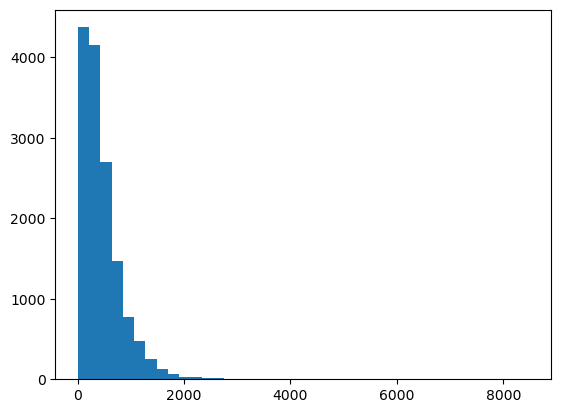

In [6]:
# distribution of number of transactions per consumer
trxn_counts = trxn_df.groupby('prism_consumer_id').count().prism_transaction_id
plt.hist(trxn_counts, bins=40)
plt.show()

In [7]:
# creating separate df for consumers with DQ_TARGET values
cons_df_no_na = cons_df[~cons_df['DQ_TARGET'].isna()]

In [7]:
def exclude_consumers(cons_df, acct_df, trxn_df):
    # minimum number of transactions
    trxn_counts = trxn_df.groupby('prism_consumer_id')['prism_transaction_id'].count()
    cons_at_least_2_trxns = set(trxn_counts[trxn_counts >= 2].index)

    # consumers with non zero balance
    balance_sum = acct_df.groupby('prism_consumer_id')['balance'].sum()
    cons_non_zero_balances = set(balance_sum[balance_sum != 0].index)

    # consumers with at least 1 credit and debit transaction
    credit_debit_counts = trxn_df.groupby('prism_consumer_id')['credit_or_debit'].value_counts().unstack(fill_value=0)
    credit_debit_counts.columns = ['num_credits', 'num_debits']
    cons_non_zero_credits = set(credit_debit_counts[credit_debit_counts.num_credits > 0].index)
    cons_non_zero_debits = set(credit_debit_counts[credit_debit_counts.num_debits > 0].index)
    cons_has_both_credits_debits = set(credit_debit_counts[((credit_debit_counts.num_credits > 0) & (credit_debit_counts.num_debits > 0))].index)

    return cons_at_least_2_trxns.intersection(cons_non_zero_balances).intersection(cons_has_both_credits_debits)

In [8]:
def filter_time_window(df, days=None, months=None, years=None):
    """
    Filters transactions for each consumer over some time period
    Args:
        df (pd.DataFrame): dataframe to window over 
        days (int): number of days to go back
        months (int): number of months to go back
        years (int): number of years to go back
    Returns:
        pd.DataFrame: windowed dataframe
    """
    def filter_group(group):
        latest_date = group['posted_date'].max()  # Get latest transaction date per consumer
        cutoff_date = latest_date - pd.DateOffset(days=days or 0, months=months or 0, years=years or 0)
        return group[group['posted_date'] >= cutoff_date]  # Filter transactions

    return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)

In [9]:
def compute_balance_delta(balance_filtered, label):
    # Get last balance per consumer
    last_balance = balance_filtered.groupby('prism_consumer_id')['curr_balance'].last().reset_index()
    last_balance = last_balance.rename(columns={'curr_balance': 'curr_balance_last'})
    
    # Get earliest balance in the filtered dataset
    first_balance = balance_filtered.groupby('prism_consumer_id')['curr_balance'].first().reset_index()
    first_balance = first_balance.rename(columns={'curr_balance': 'curr_balance_first'})
    
    # Merge and compute balance delta
    df_merged = last_balance.merge(first_balance, on='prism_consumer_id', how='left')
    df_merged[f'balance_delta_{label}'] = df_merged['curr_balance_last'] - df_merged['curr_balance_first']
    
    # Keep only relevant columns
    return df_merged[['prism_consumer_id', f'balance_delta_{label}']]

In [10]:
def calc_balances_all(acctDF, trxnDF):
    check_acct_totals = acctDF[acctDF.account_type == 'CHECKING'].groupby(['prism_consumer_id', 'balance_date']).sum()
    check_acct_totals = check_acct_totals.reset_index()
    check_acct_totals = check_acct_totals.drop(axis=1,labels='prism_account_id')

    # Merge transactions with account balances
    merged = trxnDF.merge(
        check_acct_totals[['prism_consumer_id', 'balance_date', 'balance']], 
        on='prism_consumer_id', how='left'
    )

    # Identify pre and post transactions
    merged['is_pre'] = merged['posted_date'] <= merged['balance_date']

    # Set adjustment values based on pre/post period
    merged['adjustment'] = 0.0
    merged.loc[merged['is_pre'] & (merged['credit_or_debit'] == 'CREDIT'), 'adjustment'] = -merged['amount']
    merged.loc[merged['is_pre'] & (merged['credit_or_debit'] == 'DEBIT'), 'adjustment'] = merged['amount']
    merged.loc[~merged['is_pre'] & (merged['credit_or_debit'] == 'CREDIT'), 'adjustment'] = merged['amount']
    merged.loc[~merged['is_pre'] & (merged['credit_or_debit'] == 'DEBIT'), 'adjustment'] = -merged['amount']

    # Pre-balance transactions: Sort descending and apply reverse cumsum
    pre_trans = merged[merged['is_pre']].sort_values(by=['prism_consumer_id', 'posted_date'], ascending=[True, False])
    pre_trans['curr_balance'] = pre_trans.groupby('prism_consumer_id')['adjustment'].cumsum() + pre_trans.groupby('prism_consumer_id')['balance'].transform('first')

    # Post-balance transactions: Sort ascending and apply forward cumsum
    post_trans = merged[~merged['is_pre']].sort_values(by=['prism_consumer_id', 'posted_date'], ascending=[True, True])
    post_trans['curr_balance'] = post_trans.groupby('prism_consumer_id')['adjustment'].cumsum() + post_trans.groupby('prism_consumer_id')['balance'].transform('first')

    # Combine results
    result = pd.concat([pre_trans, post_trans]).sort_values(by=['prism_consumer_id', 'posted_date'])

    # returns balanceDF
    return result[['prism_consumer_id', 'prism_transaction_id', 'category', 'amount', 'credit_or_debit', 'posted_date', 'curr_balance']].sort_values(by='posted_date', ascending=False)

In [11]:
def create_balance_features(balanceDF, consDF):
    balance_ftrs = balanceDF.groupby('prism_consumer_id')['curr_balance'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    balance_ftrs.columns = ['balance_' + x for x in balance_ftrs.columns]
    balance_last_14_days = filter_time_window(balanceDF, days=14)
    balance_last_30_days = filter_time_window(balanceDF, days=30)
    balance_last_3_months = filter_time_window(balanceDF, months=1)
    balance_last_6_months = filter_time_window(balanceDF, months=6)
    balance_last_year = filter_time_window(balanceDF, years=1)
    
    balance_last_14_days_metrics = balance_last_14_days.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    balance_last_14_days_metrics.columns = ['balance_last_14_days_' + x for x in balance_last_14_days_metrics.columns]
    
    balance_last_30_days_metrics = balance_last_30_days.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    balance_last_30_days_metrics.columns = ['balance_last_30_days_' + x for x in balance_last_30_days_metrics.columns]
    
    balance_last_3_months_metrics = balance_last_3_months.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    balance_last_3_months_metrics.columns = ['balance_last_3_months_' + x for x in balance_last_3_months_metrics.columns]
    
    balance_last_6_months_metrics = balance_last_6_months.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    balance_last_6_months_metrics.columns = ['balance_last_6_months_' + x for x in balance_last_6_months_metrics.columns]
    
    balance_last_year_metrics = balance_last_year.groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    balance_last_year_metrics.columns = ['balance_last_1_year_' + x for x in balance_last_year_metrics.columns]
    
    balance_dfs = [consDF[['prism_consumer_id']], balance_ftrs, balance_last_14_days_metrics, balance_last_30_days_metrics, balance_last_3_months_metrics, balance_last_6_months_metrics, balance_last_year_metrics]
    balance_ftrs = reduce(lambda left, right: pd.merge(left, right, on='prism_consumer_id', how='left'), balance_dfs)

    balance_delta_overall = compute_balance_delta(balanceDF, 'overall')
    balance_delta_14d = compute_balance_delta(balance_last_14_days, '14d')
    balance_delta_30d = compute_balance_delta(balance_last_30_days, '30d')
    balance_delta_3m = compute_balance_delta(balance_last_3_months, '3m')
    balance_delta_6m = compute_balance_delta(balance_last_6_months, '6m')
    balance_delta_1y = compute_balance_delta(balance_last_year, '1y')

    balance_deltas_dfs = [consDF[['prism_consumer_id']], balance_delta_overall, balance_delta_14d, balance_delta_30d, balance_delta_3m, balance_delta_6m, balance_delta_1y]
    balance_deltas_ftrs = reduce(lambda left, right: pd.merge(left, right, on='prism_consumer_id', how='left'), balance_deltas_dfs)

    return balance_ftrs, balance_deltas_ftrs

In [12]:
def create_inflows_outflows_features(trxn_df):
    # creating relevant outflows df with only expenses
    debits_not_expenses = ['SELF_TRANSFER', 'ATM_CASH']
    credits_not_income = ['SELF_TRANSFER', 'LOAN', 'REFUND'] # maybe TAX
    
    outflows_agg_df = trxn_df[(trxn_df.credit_or_debit == 'DEBIT') & (~trxn_df['category'].isin(debits_not_expenses))] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    outflows_agg_df.columns = ['OUTFLOWS_amt_' + col for col in outflows_agg_df.columns]
    inflows_agg_df = trxn_df[(trxn_df.credit_or_debit == 'CREDIT') & (~trxn_df['category'].isin(credits_not_income))] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    inflows_agg_df.columns = ['INFLOWS_amt_' + col for col in inflows_agg_df.columns]
    
    ### creating filtered window transactions dfs for inflows and outflows ###
    trxn_df_last_14_days = filter_time_window(trxn_df, days=14)
    trxn_df_last_30_days = filter_time_window(trxn_df, days=30)
    trxn_df_last_3_months = filter_time_window(trxn_df, months=3)
    trxn_df_last_6_months = filter_time_window(trxn_df, months=6)
    trxn_df_last_year = filter_time_window(trxn_df, years=1)

    # grabbing debits and credits across time periods
    debits_df_last_14_days = trxn_df_last_14_days[trxn_df_last_14_days.credit_or_debit == 'DEBIT']
    debits_df_last_30_days = trxn_df_last_30_days[trxn_df_last_30_days.credit_or_debit == 'DEBIT']
    debits_df_last_3_months = trxn_df_last_3_months[trxn_df_last_3_months.credit_or_debit == 'DEBIT']
    debits_df_last_6_months = trxn_df_last_6_months[trxn_df_last_6_months.credit_or_debit == 'DEBIT']
    debits_df_last_year = trxn_df_last_year[trxn_df_last_year.credit_or_debit == 'DEBIT']
    
    credits_df_last_14_days = trxn_df_last_14_days[trxn_df_last_14_days.credit_or_debit == 'CREDIT']
    credits_df_last_30_days = trxn_df_last_30_days[trxn_df_last_30_days.credit_or_debit == 'CREDIT']
    credits_df_last_3_months = trxn_df_last_3_months[trxn_df_last_3_months.credit_or_debit == 'CREDIT']
    credits_df_last_6_months = trxn_df_last_6_months[trxn_df_last_6_months.credit_or_debit == 'CREDIT']
    credits_df_last_year = trxn_df_last_year[trxn_df_last_year.credit_or_debit == 'CREDIT']

    # creating windowed expenses aggregate metrics
    outflows_last_14_days_agg_df = debits_df_last_14_days[~debits_df_last_14_days['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    outflows_last_14_days_agg_df.columns = ['OUTFLOWS_amt_last_14_days_' + col for col in outflows_last_14_days_agg_df.columns]
    
    outflows_last_30_days_agg_df = debits_df_last_30_days[~debits_df_last_30_days['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    outflows_last_30_days_agg_df.columns = ['OUTFLOWS_amt_last_30_days_' + col for col in outflows_last_30_days_agg_df.columns]
    
    outflows_last_3_months_agg_df = debits_df_last_3_months[~debits_df_last_3_months['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    outflows_last_3_months_agg_df.columns = ['OUTFLOWS_amt_last_3_months_' + col for col in outflows_last_3_months_agg_df.columns]
    
    outflows_last_6_months_agg_df = debits_df_last_6_months[~debits_df_last_6_months['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    outflows_last_6_months_agg_df.columns = ['OUTFLOWS_amt_last_6_months_' + col for col in outflows_last_6_months_agg_df.columns]
    
    outflows_last_year_agg_df = debits_df_last_year[~debits_df_last_year['category'].isin(debits_not_expenses)] \
                            .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    outflows_last_year_agg_df.columns = ['OUTFLOWS_amt_last_year_' + col for col in outflows_last_year_agg_df.columns]

    # creating windowed inflows aggregate metrics
    inflows_last_14_days_agg_df = credits_df_last_14_days[~credits_df_last_14_days['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    inflows_last_14_days_agg_df.columns = ['INFLOWS_amt_last_14_days_' + col for col in inflows_last_14_days_agg_df.columns]
    
    inflows_last_30_days_agg_df = credits_df_last_30_days[~credits_df_last_30_days['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    inflows_last_30_days_agg_df.columns = ['INFLOWS_amt_last_30_days_' + col for col in inflows_last_30_days_agg_df.columns]
    
    inflows_last_3_months_agg_df = credits_df_last_3_months[~credits_df_last_3_months['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    inflows_last_3_months_agg_df.columns = ['INFLOWS_amt_last_3_months_' + col for col in inflows_last_3_months_agg_df.columns]
    
    inflows_last_6_months_agg_df = credits_df_last_6_months[~credits_df_last_6_months['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    inflows_last_6_months_agg_df.columns = ['INFLOWS_amt_last_6_months_' + col for col in inflows_last_6_months_agg_df.columns]
    
    inflows_last_year_agg_df = credits_df_last_year[~credits_df_last_year['category'].isin(credits_not_income)] \
                    .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max', 'sum'])
    inflows_last_year_agg_df.columns = ['INFLOWS_amt_last_year_' + col for col in inflows_last_year_agg_df.columns]

    all_outflows_dfs = [
                             outflows_agg_df, outflows_last_14_days_agg_df, outflows_last_30_days_agg_df,
                             outflows_last_3_months_agg_df, outflows_last_6_months_agg_df, outflows_last_year_agg_df,
                         ]

    all_inflows_dfs = [
                             inflows_agg_df, inflows_last_14_days_agg_df, inflows_last_30_days_agg_df,
                             inflows_last_3_months_agg_df, inflows_last_6_months_agg_df, inflows_last_year_agg_df,
                         ]

    return all_outflows_dfs, all_inflows_dfs

In [13]:
def create_binary_features(trxn_df):
    # creating flags for risky categories
    risky_categories = ['GAMBLING', 'BNPL', 'OVERDRAFT'] # removed small dollar advance because no rows have it 
    trxn_category_table = trxn_df.pivot_table(index='prism_consumer_id', columns='category', values='amount', aggfunc='size', fill_value=0)
    
    gambling_flag_df = pd.DataFrame((trxn_category_table['GAMBLING'] > 0).astype(int)).reset_index()
    bnpl_flag_df = pd.DataFrame((trxn_category_table['BNPL'] > 0).astype(int)).reset_index()
    overdraft_flag_df = pd.DataFrame((trxn_category_table['OVERDRAFT'] > 0).astype(int)).reset_index()

    return [gambling_flag_df, bnpl_flag_df, overdraft_flag_df]

In [14]:
def generate_category_features(trxnDF, categories):
    """
    Generates transaction-based features for each selected category over multiple time windows.
    
    Parameters:
        trxnDF (pd.DataFrame): DataFrame containing transaction data.
        categories (str or list): One or more transaction categories to filter.

    Returns:
        pd.DataFrame: Aggregated features per prism_consumer_id.
    """
    if isinstance(categories, str):
        categories = [categories]

    trxnDF['posted_date'] = pd.to_datetime(trxnDF['posted_date'])

    time_windows = {
        'overall': None,
        'last_14_days': 14,
        'last_30_days': 30,
        'last_3_months': 90,
        'last_6_months': 180,
        'last_year': 365
    }

    features_dict = {}

    for category in categories:
        # filter transactions for the current category
        filtered_trxn = trxnDF[trxnDF['category'] == category].copy()

        # get last posted date per consumer
        last_posted_dates = filtered_trxn.groupby('prism_consumer_id')['posted_date'].max()

        for window_name, days in time_windows.items():
            if days is None:
                df_time_filtered = filtered_trxn
            else:
                # consumer-specific time filters
                df_time_filtered = filtered_trxn.merge(last_posted_dates, on='prism_consumer_id', suffixes=('', '_latest'))
                df_time_filtered = df_time_filtered[df_time_filtered['posted_date'] >= (df_time_filtered['posted_date_latest'] - pd.Timedelta(days=days))]
                df_time_filtered = df_time_filtered.drop(columns=['posted_date_latest'])

            # aggregate features
            agg_features = df_time_filtered.groupby('prism_consumer_id')['amount'].agg(
                mean='mean',
                median='median',
                std='std',
                max='max',
                min='min',
                count='count',
                sum='sum'
            )

            # total transaction count per consumer in the time window
            total_trxn_counts = trxnDF.groupby('prism_consumer_id')['amount'].count()

            # compute percentage of transactions in this category for the time window
            percentage_trxn = (agg_features['count'] / total_trxn_counts).fillna(0)
            percentage_trxn = percentage_trxn.rename(f"{category}_{window_name}_percent")

            agg_features = agg_features.rename(columns=lambda x: f"{category}_{window_name}_{x}")

            features_dict[f"{category}_{window_name}"] = pd.concat([agg_features, percentage_trxn], axis=1)


    final_features = pd.concat(features_dict.values(), axis=1).fillna(0)
    return final_features

In [15]:
def compute_threshold_stats(df, thresholds, cat_label):
    # Count total gambling transactions
    counts = df.groupby('prism_consumer_id').size().reset_index(name=f'{cat_label}_count')

    # Check thresholds
    threshold_flags = df.groupby('prism_consumer_id')['amount'].agg(lambda x: [any(x >= t) for t in thresholds]).apply(pd.Series)
    threshold_flags.columns = [f'{cat_label}_over_{t}' for t in thresholds]
    threshold_flags = threshold_flags.astype(bool)  # Convert to True/False

    # Merge counts and flags
    result = counts.merge(threshold_flags, on='prism_consumer_id', how='left')

    return result

In [16]:
def create_features_df(cons_df, acct_df, trxn_df, exclude=False):
    # if we want to do scoring exclusions, then have new cons_df with filtered consumers
    if exclude:
        kept_consumers = exclude_consumers(cons_df, acct_df, trxn_df)
        cons_df = cons_df[cons_df.prism_consumer_id.isin(kept_consumers)]
        
    # creating sum of balances feature
    sum_of_balance_df = pd.DataFrame(acct_df.groupby('prism_consumer_id')['balance'].sum()) \
                       .rename(columns={'balance': 'sum_of_balance'}).reset_index()

    # creating credit_minus_debit feature
    credit_minus_debit_df = pd.DataFrame(trxn_df.groupby('prism_consumer_id') \
                            .apply(
                                lambda group: group.loc[group["credit_or_debit"] == "CREDIT", "amount"].sum()
                                            - group.loc[group["credit_or_debit"] == "DEBIT", "amount"].sum()
                                )).reset_index().rename(columns={0: "credit_minus_debit"})

    # number of "income" sources for each consumer -- TODO: disregard credits that aren't actual income
    num_income_sources = trxn_df[trxn_df.credit_or_debit == 'CREDIT'].groupby('prism_consumer_id')['category'].nunique()
    num_income_source_df = pd.DataFrame(num_income_sources).reset_index() \
                                    .rename(columns=
                                            {'index': 'prism_consumer_id', 
                                             'category': 'num_income_source'}
                                           )
    
    # number of accounts for each consumer
    num_accounts_df = acct_df.groupby('prism_consumer_id')['account_type'].count().reset_index() \
                             .rename(columns={'account_type': 'num_accounts'})

    # TODO: something for has savings account
    
    all_outflows_dfs, all_inflows_dfs = create_inflows_outflows_features(trxn_df)
    binary_features_dfs = create_binary_features(trxn_df)

    # create category features
    cat_ok = ['SELF_TRANSFER', 'EXTERNAL_TRANSFER', 'DEPOSIT', 'PAYCHECK',
       'MISCELLANEOUS', 'PAYCHECK_PLACEHOLDER', 'REFUND',
       'INVESTMENT_INCOME', 'OTHER_BENEFITS', 
       'SMALL_DOLLAR_ADVANCE', 'TAX', 'LOAN', 'INSURANCE',
       'FOOD_AND_BEVERAGES', 'UNCATEGORIZED', 'GENERAL_MERCHANDISE',
       'AUTOMOTIVE', 'GROCERIES', 'ATM_CASH', 'ENTERTAINMENT', 'TRAVEL',
       'ESSENTIAL_SERVICES', 'ACCOUNT_FEES', 'HOME_IMPROVEMENT',
       'OVERDRAFT', 'CREDIT_CARD_PAYMENT', 'HEALTHCARE_MEDICAL', 'PETS',
       'EDUCATION', 'GIFTS_DONATIONS', 'BILLS_UTILITIES', 'MORTGAGE',
       'RENT', 'BNPL', 'AUTO_LOAN',
       'BANKING_CATCH_ALL', 'DEBT', 'FITNESS', 'TRANSPORATION', 'LEGAL',
       'GOVERNMENT_SERVICES', 'RISK_CATCH_ALL', 'RTO_LTO', 'INVESTMENT',
       'GAMBLING', 'CORPORATE_PAYMENTS', 'TIME_OR_STUFF', 'PENSION']
    category_features = generate_category_features(trxn_df, cat_ok)

    # create balance features
    balanceDF = calc_balances_all(acct_df, trxn_df)
    balance_ftrs, balance_deltas_ftrs = create_balance_features(balanceDF, cons_df)

    # balance_features_df, category_features_df = read_other_data('balance_features_2.csv', 'category_features_2.csv')
    # balance_features_df = balance_features_df.drop(columns='Unnamed: 0')
    
    # merging all features into features df
    features_df = reduce(lambda left, right: left.merge(right, on='prism_consumer_id', how='left'), 
                         [cons_df, sum_of_balance_df, credit_minus_debit_df, num_income_source_df, 
                          num_accounts_df, balance_ftrs, balance_deltas_ftrs, category_features] + 
                         all_outflows_dfs + all_inflows_dfs + binary_features_dfs
                        )
    fill_na_cols = features_df.columns.difference(['DQ_TARGET'])
    features_df[fill_na_cols] = features_df[fill_na_cols].fillna(0)
 
    return features_df

In [17]:
# balanceDF = calc_balances_all(acct_df, trxn_df)

In [18]:
# balance_ftrs, balance_deltas_ftrs = create_balance_features(balanceDF, cons_df)

In [19]:
# cat_ok = ['SELF_TRANSFER', 'EXTERNAL_TRANSFER', 'DEPOSIT', 'PAYCHECK',
#        'MISCELLANEOUS', 'PAYCHECK_PLACEHOLDER', 'REFUND',
#        'INVESTMENT_INCOME', 'OTHER_BENEFITS', 
#        'SMALL_DOLLAR_ADVANCE', 'TAX', 'LOAN', 'INSURANCE',
#        'FOOD_AND_BEVERAGES', 'UNCATEGORIZED', 'GENERAL_MERCHANDISE',
#        'AUTOMOTIVE', 'GROCERIES', 'ATM_CASH', 'ENTERTAINMENT', 'TRAVEL',
#        'ESSENTIAL_SERVICES', 'ACCOUNT_FEES', 'HOME_IMPROVEMENT',
#        'OVERDRAFT', 'CREDIT_CARD_PAYMENT', 'HEALTHCARE_MEDICAL', 'PETS',
#        'EDUCATION', 'GIFTS_DONATIONS', 'BILLS_UTILITIES', 'MORTGAGE',
#        'RENT', 'BNPL', 'AUTO_LOAN',
#        'BANKING_CATCH_ALL', 'DEBT', 'FITNESS', 'TRANSPORATION', 'LEGAL',
#        'GOVERNMENT_SERVICES', 'RISK_CATCH_ALL', 'RTO_LTO', 'INVESTMENT',
#        'GAMBLING', 'CORPORATE_PAYMENTS', 'TIME_OR_STUFF', 'PENSION']
# category_features = generate_category_features(trxn_df, cat_ok)

In [20]:
# features_df = create_features_df(cons_df, acct_df, trxn_df)

In [21]:
with open('../../src/build/final_features_df.pkl', 'rb') as f:
    features_df = pickle.load(f)

In [22]:
has_savings_df = acct_df.groupby('prism_consumer_id', as_index=False).agg(HAS_SAVINGS_ACCT=('account_type', lambda x: int('SAVINGS' in x.values)))
features_df = features_df.merge(has_savings_df, on='prism_consumer_id', how='left')
features_df['HAS_SAVINGS_ACCT'] =  features_df['HAS_SAVINGS_ACCT'].fillna(0)
features_df = features_df.rename(columns={'sum_of_balance': 'sum_acct_balances'})
features_df_DQ_no_na = features_df[~features_df.DQ_TARGET.isna()]

In [23]:
features_df.shape, 'GAMBLING' in features_df

((15000, 2430), True)

In [22]:
# max_features_lst = list(range(50, 2500, 50))
X_train, X_test, y_train, y_test = split_data(features_df_DQ_no_na, test_size=0.5)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)
X_train_standardized, X_val_standardized, X_test_standardized = standardize(X_train, X_val, X_test)
feature_coefs = get_lasso_features(X_train_standardized, y_train)

NameError: name 'split_data' is not defined

In [ ]:
feature_coefs_df = pd.DataFrame(feature_coefs).rename(columns={0: 'feature', 1: 'importance'})

In [130]:
# getting rid of low variance features (based on standardized data)
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)
X_train_std_reduced = pd.DataFrame(selector.fit_transform(X_train_standardized), columns=X_train_standardized.columns[selector.get_support()])
# do it for raw data because I need it for correlation matrix
X_train_reduced = pd.DataFrame(selector.transform(X_train[X_train_standardized.columns]), columns=X_train_standardized.columns[selector.get_support()])
X_train_std_reduced.shape, X_train_reduced.shape

((7500, 2282), (7500, 2282))

In [135]:
# getting rid of low variance features in val and test datasets
X_val_std_reduced = pd.DataFrame(selector.transform(X_val_standardized), columns=X_train_standardized.columns[selector.get_support()])
X_test_std_reduced = pd.DataFrame(selector.transform(X_test_standardized), columns=X_train_standardized.columns[selector.get_support()])

In [132]:
# creating correlation matrix (based on raw data, ignoring binary variables)
binary_variables = ['HAS_SAVINGS_ACCT', 'GAMBLING', 'OVERDRAFT', 'BNPL']
# ignore_cols = ['prism_consumer_id', 'evaluation_date', 'DQ_TARGET']
X_train_reduced_corr = X_train_reduced.drop(columns=binary_variables).corr()

In [133]:
corr_threshold = 0.9
high_corr_features = np.where(np.abs(X_train_reduced_corr) > corr_threshold)
correlated_pairs = [(X_train_reduced_corr.index[x], X_train_reduced_corr.columns[y]) 
                    for x, y in zip(*high_corr_features) if x != y]

In [136]:
# dropping features in correlated pairs based on l1 importance
to_drop = set()
for feature_1, feature_2 in correlated_pairs:
    if feature_1 not in to_drop and feature_2 not in to_drop:
        if feature_coefs_df[feature_coefs_df['feature'] == feature_1]['importance'].iloc[0] < \
           feature_coefs_df[feature_coefs_df['feature'] == feature_2]['importance'].iloc[0]:
            to_drop.add(feature_1)
        else:
            to_drop.add(feature_2)  # Keep one and drop the other

X_train_std_reduced = X_train_std_reduced.drop(columns=to_drop)
X_train_std_reduced.shape

(7500, 674)

In [140]:
X_val_std_reduced = X_val_std_reduced.drop(columns=to_drop)
X_test_std_reduced = X_test_std_reduced.drop(columns=to_drop)

Training Time: 22.6476 seconds


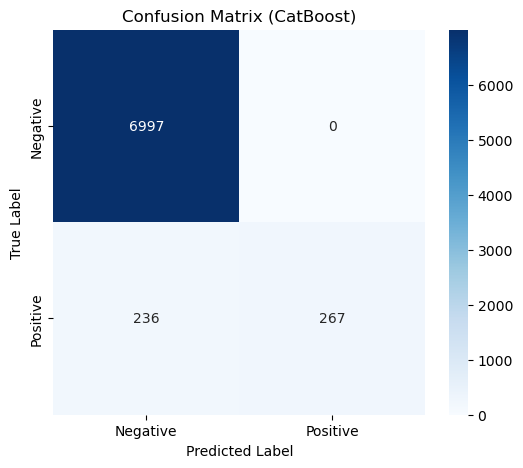

CatBoost metrics:
	ROC_AUC: 0.9920528280936078
	Accuracy: 0.9685333333333334
	Precision: 1.0
	Recall: 0.5308151093439364
	F1-Score: 0.6935064935064935


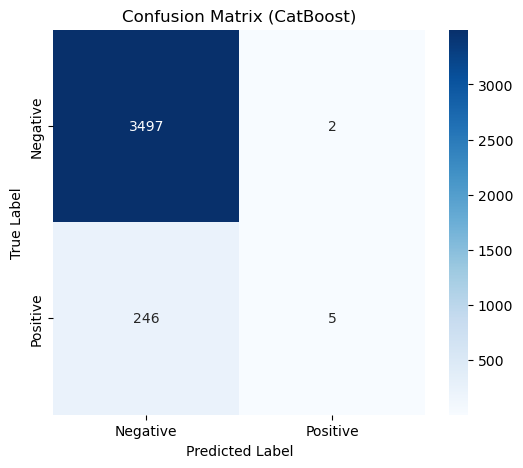

CatBoost metrics:
	ROC_AUC: 0.7770797347904752
	Accuracy: 0.9338666666666666
	Precision: 0.7142857142857143
	Recall: 0.0199203187250996
	F1-Score: 0.03875968992248062


In [141]:
# testing model after getting rid of highly correlated features
model, metrics = train_and_evaluate(X_train_std_reduced, y_train, X_val_std_reduced, y_val, model_type='CatBoost')

In [163]:
X_train_resampled, y_train_resampled = resample_data(X_train_std_reduced, y_train)

Training Time: 24.2621 seconds


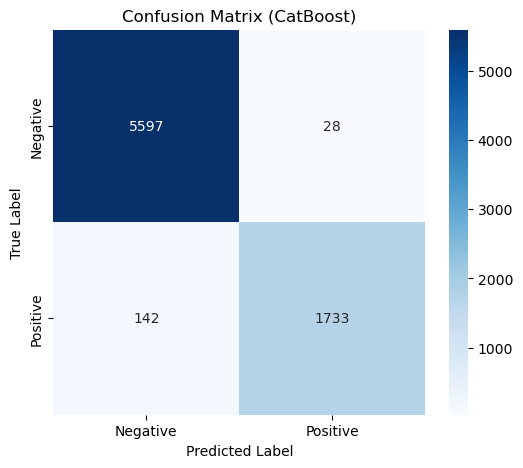

CatBoost metrics:
	ROC_AUC: 0.998829842962963
	Accuracy: 0.9773333333333334
	Precision: 0.9840999432140829
	Recall: 0.9242666666666667
	F1-Score: 0.9532453245324533


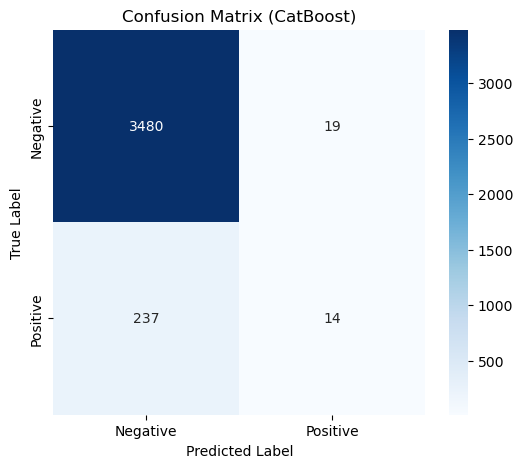

CatBoost metrics:
	ROC_AUC: 0.7632192009327651
	Accuracy: 0.9317333333333333
	Precision: 0.42424242424242425
	Recall: 0.055776892430278883
	F1-Score: 0.09859154929577464


In [149]:
# testing model after getting rid of highly correlated features and using SMOTE
model, metrics = train_and_evaluate(X_train_resampled, y_train_resampled, X_val_std_reduced, y_val, model_type='CatBoost')

Training Time: 23.3414 seconds


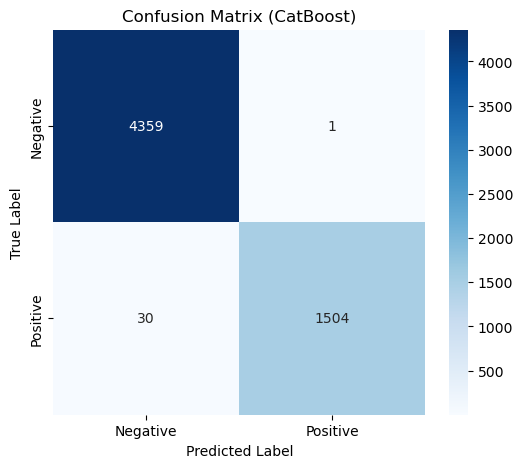

CatBoost metrics:
	ROC_AUC: 0.9999620228939153
	Accuracy: 0.994740413980319
	Precision: 0.9993355481727575
	Recall: 0.9804432855280313
	F1-Score: 0.9897992760776572


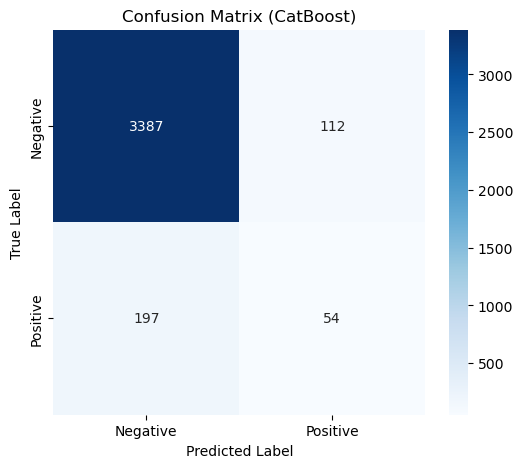

CatBoost metrics:
	ROC_AUC: 0.7631207095026582
	Accuracy: 0.9176
	Precision: 0.3253012048192771
	Recall: 0.2151394422310757
	F1-Score: 0.2589928057553957


In [168]:
# testing model after getting rid of highly correlated features and using SMOTEENN
model, metrics = train_and_evaluate(X_train_resampled, y_train_resampled, X_val_std_reduced, y_val, model_type='CatBoost')

[LightGBM] [Info] Number of positive: 1534, number of negative: 4360
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 151676
[LightGBM] [Info] Number of data points in the train set: 5894, number of used features: 671
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260265 -> initscore=-1.044593
[LightGBM] [Info] Start training from score -1.044593
Training Time: 1.8965 seconds


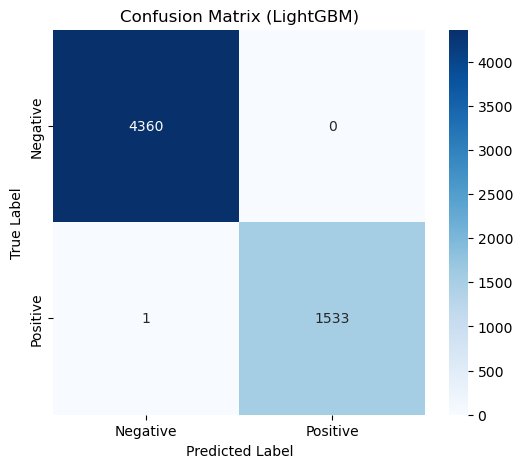

LightGBM metrics:
	ROC_AUC: 1.0
	Accuracy: 0.999830335934849
	Precision: 1.0
	Recall: 0.999348109517601
	F1-Score: 0.9996739484838605


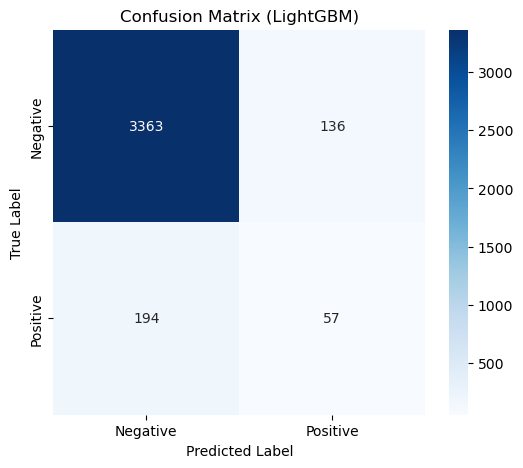

LightGBM metrics:
	ROC_AUC: 0.7733046095127919
	Accuracy: 0.912
	Precision: 0.29533678756476683
	Recall: 0.22709163346613545
	F1-Score: 0.25675675675675674


In [169]:
# testing model after getting rid of highly correlated features and using SMOTEENN
model, metrics = train_and_evaluate(X_train_resampled, y_train_resampled, X_val_std_reduced, y_val, model_type='LightGBM')

In [ ]:
# TODO: 

/tmp/ipykernel_418/1857701302.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = sch.linkage(distance_matrix, method="ward")


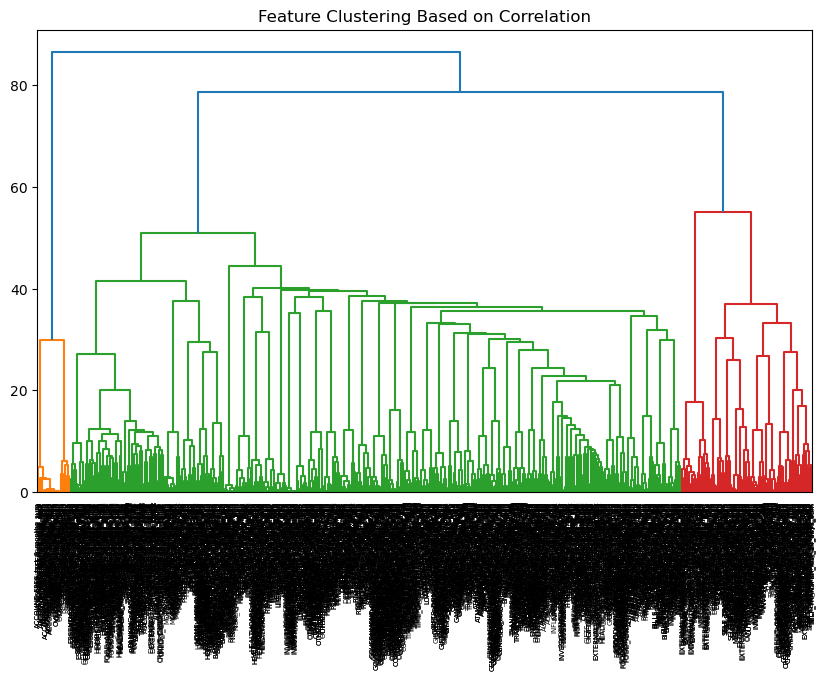

In [113]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Convert correlation matrix into distance matrix
distance_matrix = 1 - np.abs(X_train_reduced_corr)

# Perform hierarchical clustering
linkage = sch.linkage(distance_matrix, method="ward")

# Plot Dendrogram
plt.figure(figsize=(10, 6))
sch.dendrogram(linkage, labels=X_train_reduced_corr.columns, leaf_rotation=90)
plt.title("Feature Clustering Based on Correlation")
plt.show()

#### Plotting Features

In [176]:
def plot_feature_distribution(features_df, feature, x_min=5, x_max=95):
    # plotting distributions of sum of balance for delinquent vs nondelinquent consumers
    features_df_dq0 = features_df[features_df.DQ_TARGET == 0]
    features_df_dq1 = features_df[features_df.DQ_TARGET == 1]
    if "count" in feature:
        sns.boxplot(features_df, x='DQ_TARGET', y=feature)
        plt.xticks(ticks=[0, 1], labels=["NON-DELINQUENT", "DELINQUENT"])
        plt.xlabel("DELINQUENCY")
    else:
        plt.hist(features_df_dq0[feature], bins=400, alpha=0.5, density=True, edgecolor="black", label=f"{feature} (NON-DELINQUENT)")
        plt.hist(features_df_dq1[feature], bins=100, alpha=0.5, density=True, edgecolor="black", label=f"{feature} (DELINQUENT)")
        x_min, x_max = np.percentile(features_df[feature], [x_min, x_max])
        plt.xlim(x_min, x_max)
        plt.xlabel(feature)
        plt.ylabel("Proportion")
        plt.grid(True)
        plt.legend(fontsize="small")
    
    plt.title(f"{feature} Distribution by Delinquency")
    plt.tight_layout()
    plt.savefig(f"../../q2_result/{feature}_distribution.png")
    plt.show()

    return plt.gcf()

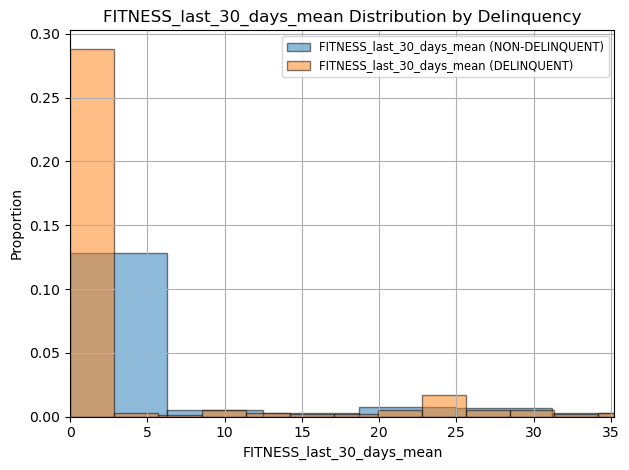

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [177]:
plot_feature_distribution(features_df, 'FITNESS_last_30_days_mean', 0, 95)

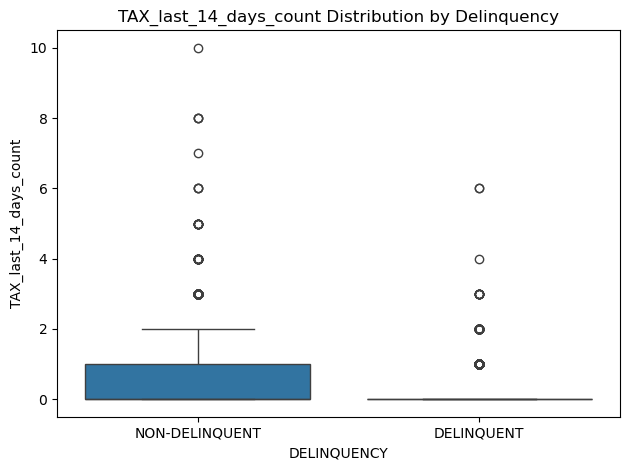

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [142]:
plot_feature_distribution(features_df, "TAX_last_14_days_count")

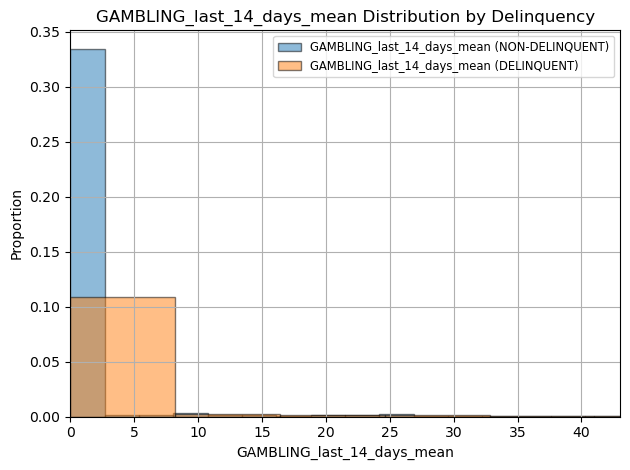

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [133]:
plot_feature_distribution(features_df, 'GAMBLING_last_14_days_mean', 5, 95)

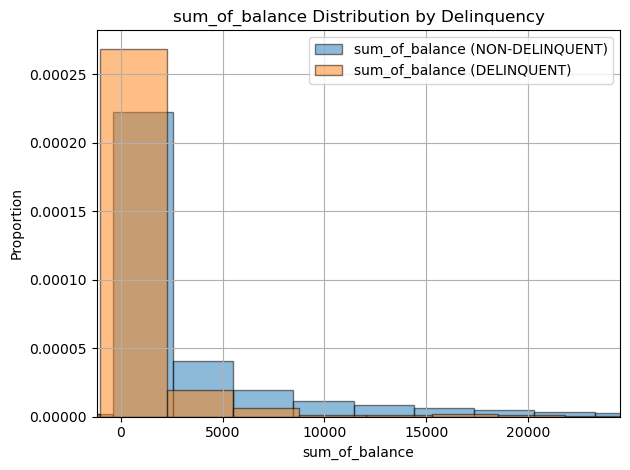

<Figure size 640x480 with 0 Axes>

In [116]:
fig = plot_feature_distribution(features_df, "sum_of_balance", 0.1, 95) # 0.1, 95

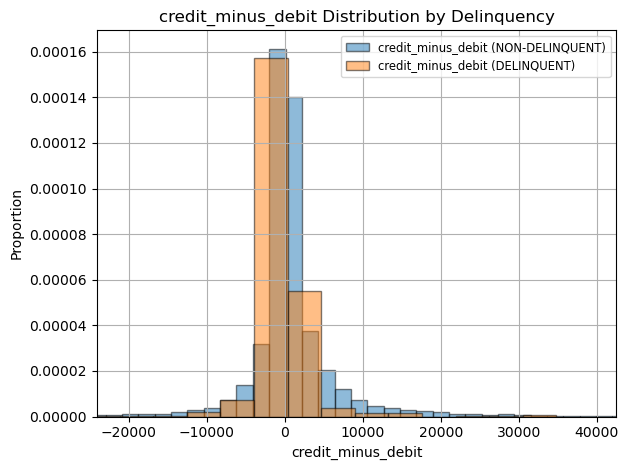

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [119]:
plot_feature_distribution(features_df, "credit_minus_debit", 1, 99)

## Week 1 

**Single best feature to predict `DQ_TARGET`**

**Simple**
- sum of a consumer's `balance`
- `credit_score` seems like an obvious one
- sum of consumer's credit - sum of consumer's debit

In [17]:
# getting outflow (debit) and inflow (credit) categories
debit_cats = set(trxn_df[trxn_df['credit_or_debit'] == 'DEBIT']['category'].value_counts().index)
credit_cats = set(trxn_df[trxn_df['credit_or_debit'] == 'CREDIT']['category'].value_counts().index)

In [18]:
# creating sum of balances feature
sum_of_balance = pd.DataFrame(acct_df.groupby('prism_consumer_id')['balance'].sum()) \
                   .rename(columns={'balance': 'sum_of_balance'}).reset_index()
# use left outer join because we want features for all consumers even if it is NA for now
features_df = cons_df.merge(sum_of_balance, left_on='prism_consumer_id', right_on='prism_consumer_id', how='left')

**Note: balances have different meaning based on account type, i.e. a credit card balance (outflow) vs checkings balance (inflow)**

#### Feature significance metrics

In [13]:
# r2 value for sum of balance feature #
# getting rows where neither features are NA
cons_sum_balance_df_no_na = features_df[(~features_df['DQ_TARGET'].isna()) & (~features_df['sum_of_balance'].isna())]
sum_balance_r2 = np.corrcoef(
        cons_sum_balance_df_no_na['DQ_TARGET'], 
        cons_sum_balance_df_no_na['sum_of_balance']
    )[0][1]**2
sum_balance_r2

0.0015695061588102432

In [14]:
# KS test pvalue for sum of balance feature
cons_sum_balance_dq0 = cons_sum_balance_df_no_na[cons_sum_balance_df_no_na["DQ_TARGET"] == 0.0]
cons_sum_balance_dq1 = cons_sum_balance_df_no_na[cons_sum_balance_df_no_na["DQ_TARGET"] == 1.0]
scipy.stats.ks_2samp(cons_sum_balance_dq0["sum_of_balance"], cons_sum_balance_dq1["sum_of_balance"]).pvalue

3.7555463168404585e-99

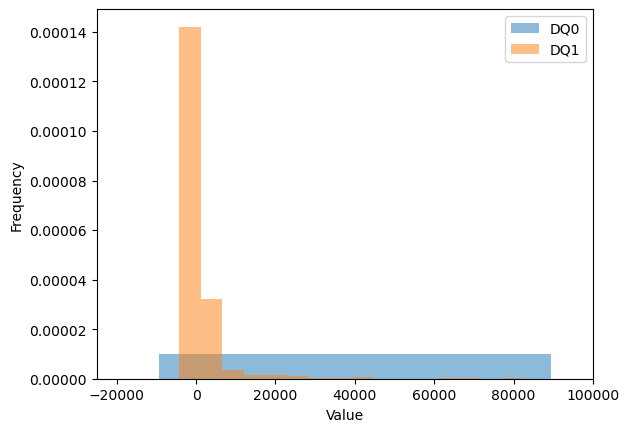

In [15]:
# plotting distributions of sum of balance for delinquent vs nondelinquent consumers
plt.hist(cons_sum_balance_dq0["sum_of_balance"], bins=30, alpha=0.5, density=True, label="DQ0")
plt.hist(cons_sum_balance_dq1["sum_of_balance"], bins=30, alpha=0.5, density=True, label="DQ1")

plt.xlim(-25000, 100000)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('')
plt.legend()
plt.show()

In [16]:
# r2 value of credit score feature
credit_score_r2 = np.corrcoef(cons_df_no_na['credit_score'], cons_df_no_na['DQ_TARGET'])[0][1]**2
credit_score_r2

0.06828206045598226

In [17]:
# point biserial value for credit score feature
credit_score_pbr = scipy.stats.pointbiserialr(cons_df_no_na['credit_score'], cons_df_no_na['DQ_TARGET'])
credit_score_pbr.pvalue

1.5212196313474402e-186

In [18]:
# calculating credit_minus_debit feature
credit_minus_debit = trxn_df.groupby('prism_consumer_id') \
                            .apply(
                                lambda group: group.loc[group["credit_or_debit"] == "CREDIT", "amount"].sum()
                                            - group.loc[group["credit_or_debit"] == "DEBIT", "amount"].sum()
                                )

/tmp/ipykernel_352/3454179167.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [19]:
# merging credit_minus_debit feature with features_df
features_df = features_df.merge(pd.DataFrame(credit_minus_debit).reset_index() \
                                          .rename(columns={0: "credit_minus_debit"}), 
                                                 on='prism_consumer_id',
                                                 how='left')
cons_credit_minus_debit_dq0 = features_df[features_df["DQ_TARGET"] == 0.0]
cons_credit_minus_debit_dq0_no_na = cons_credit_minus_debit_dq0[~cons_credit_minus_debit_dq0["credit_minus_debit"].isna()]
cons_credit_minus_debit_dq1 = features_df[features_df["DQ_TARGET"] == 1.0]
cons_credit_minus_debit_dq1_no_na = cons_credit_minus_debit_dq1[~cons_credit_minus_debit_dq1["credit_minus_debit"].isna()]
# calculating KS stat for credit_minus_debit feature for delinquent / nondelinquent consumers
scipy.stats.ks_2samp(cons_credit_minus_debit_dq0_no_na["credit_minus_debit"], cons_credit_minus_debit_dq1_no_na["credit_minus_debit"]).pvalue

1.643182347946055e-26

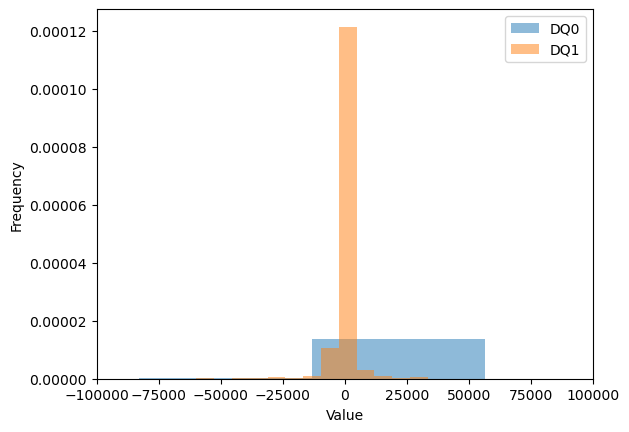

In [20]:
# # plotting distributions of credit_minus_debit for delinquent vs nondelinquent consumers
plt.hist(cons_credit_minus_debit_dq0["credit_minus_debit"], bins=30, alpha=0.5, density=True, label="DQ0")
plt.hist(cons_credit_minus_debit_dq1["credit_minus_debit"], bins=30, alpha=0.5, density=True, label="DQ1")

plt.xlim(-100000, 100000)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('')
plt.legend()
plt.show()

## Week 2

**New balance features**
- percent change in balance from earliest date to latest date
- account balance less than 0
  
**New income features**
- number of income transactions
- standard deviation of income
- number of income sources

In [10]:
def calc_balance_delta(rand_cons):
    """
    Calculating change in balance from first transaction to last transaction.
    Args:
        rand_cons (int): consumer id
    Returns:
        float: change in balance
    """
    rand_cons_acct_df = acct_df[acct_df.prism_consumer_id == rand_cons]
    rand_cons_trxn_df = trxn_df[trxn_df.prism_consumer_id == rand_cons].sort_values(by='posted_date')
    
    avg_balance_date = np.mean(rand_cons_acct_df.balance_date)
    balance = sum(rand_cons_acct_df.balance)
    
    before_balance_date_df = rand_cons_trxn_df[rand_cons_trxn_df.posted_date <= avg_balance_date]
    after_balance_date_df = rand_cons_trxn_df[rand_cons_trxn_df.posted_date > avg_balance_date]
    
    initial_balance = balance + sum(before_balance_date_df[before_balance_date_df.credit_or_debit == "DEBIT"].amount) - \
                               sum(before_balance_date_df[before_balance_date_df.credit_or_debit == "CREDIT"].amount) 
    ending_balance = balance + sum(after_balance_date_df[after_balance_date_df.credit_or_debit == "CREDIT"].amount) - \
                               sum(after_balance_date_df[after_balance_date_df.credit_or_debit == "DEBIT"].amount) 
    if initial_balance == 0:
        return 1
    else:
        return ((ending_balance - initial_balance) / initial_balance)

In [25]:
# growth in balance for each consumer
balance_deltas = cons_df['prism_consumer_id'].apply(calc_balance_delta)

CPU times: user 5min 21s, sys: 2.58 s, total: 5min 24s
Wall time: 1min 53s


In [26]:
# creating balance_delta dataframe and merging with other features generated
balance_delta_df = pd.DataFrame(balance_deltas).reset_index() \
                                               .rename(columns=
                                                       {'index': 'prism_consumer_id', 
                                                        'prism_consumer_id': 'balance_delta'}
                                                      )
features_df = features_df.merge(balance_delta_df, left_on='prism_consumer_id', right_on='prism_consumer_id', how='left')

In [27]:
# number of "income" sources for each consumer -- TODO: disregard credits that aren't actual income
num_income_sources = trxn_df[trxn_df.credit_or_debit == 'CREDIT'].groupby('prism_consumer_id')['category'].nunique()
num_income_source_df = pd.DataFrame(num_income_sources).reset_index() \
                                .rename(columns=
                                        {'index': 'prism_consumer_id', 
                                         'category': 'num_income_source'}
                                       )
num_income_source_df

prism_consumer_id  num_income_source
0                      0                  7
1                      1                  6
2                      2                  8
3                      3                  9
4                      4                  5
...                  ...                ...
14471              14995                  6
14472              14996                  6
14473              14997                  5
14474              14998                 10
14475              14999                  6

[14476 rows x 2 columns]

In [29]:
# merging num_income_source and std_income features
features_df = features_df.merge(num_income_source_df, on='prism_consumer_id', how='left')
features_df = features_df.merge(std_income_df, on='prism_consumer_id', how='left')
features_df

prism_consumer_id evaluation_date  credit_score  DQ_TARGET  \
0                      0      2021-09-01         726.0        0.0   
1                      1      2021-07-01         626.0        0.0   
2                      2      2021-05-01         680.0        0.0   
3                      3      2021-03-01         734.0        0.0   
4                      4      2021-10-01         676.0        0.0   
...                  ...             ...           ...        ...   
14995              14995      2022-03-08         655.0        NaN   
14996              14996      2022-01-15         625.0        NaN   
14997              14997      2022-01-31         688.0        NaN   
14998              14998      2022-03-08         722.0        NaN   
14999              14999      2022-02-12         751.0        NaN   

       sum_of_balance  credit_minus_debit  balance_delta  num_income_source  \
0              320.37             -521.59      -0.379272                7.0   
1             3302.42             1805.43       3.245659                6.0   
2             2805.36              430.13       0.203075                8.0   
3             7667.01             2795.24       0.481150                9.0   
4              394.55            -2543.60      -1.421784                5.0   
...               ...                 ...            ...                ...   
14995             NaN             -543.80       1.000000                6.0   
14996         6821.92              878.01       0.147716                6.0   
14997             NaN              163.74       1.000000                5.0   
14998             NaN              413.80       1.000000               10.0   
14999         2000.94              297.73       0.174805                6.0   

       INFLOWS_std  
0       494.177258  
1       383.271173  
2       609.314103  
3       844.130789  
4       368.114382  
...            ...  
14995   329.312758  
14996  1076.542076  
14997  2448.997302  
14998  1701.940647  
14999   394.697351  

[15000 rows x 9 columns]

In [30]:
# creating separate features df for non-NA DQ_TARGET rows
features_df_no_na = features_df[~features_df.DQ_TARGET.isna()]

**NEXT STEPS**
- begin considering category nuances
- more specific time recurrence

## Week 3

#### Feature Creation

In [34]:
# creating relevant outflows df with only expenses
debits_not_expenses = ['SELF_TRANSFER', 'ATM_CASH']
credits_not_income = ['SELF_TRANSFER', 'LOAN', 'REFUND'] # maybe TAX

outflows_agg_df = trxn_df[(trxn_df.credit_or_debit == 'DEBIT') & (~trxn_df['category'].isin(debits_not_expenses))] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_agg_df.columns = ['OUTFLOWS_amt_' + col for col in outflows_agg_df.columns]
inflows_agg_df = trxn_df[(trxn_df.credit_or_debit == 'CREDIT') & (~trxn_df['category'].isin(credits_not_income))] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_agg_df.columns = ['INFLOWS_amt_' + col for col in inflows_agg_df.columns]

In [35]:
### creating filtered window transactions dfs for inflows and outflows ###
trxn_df_last_14_days = filter_time_window(trxn_df, days=14)
trxn_df_last_30_days = filter_time_window(trxn_df, days=30)
trxn_df_last_3_months = filter_time_window(trxn_df, months=3)
trxn_df_last_6_months = filter_time_window(trxn_df, months=6)
trxn_df_last_year = filter_time_window(trxn_df, years=1)

/tmp/ipykernel_354/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_354/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('prism_consumer_id', group_keys=False).apply(filter_group)
/tmp/ipykernel_354/1975635858.py:17: DeprecationWarning: DataFrameGroupBy.apply operated o

In [36]:
# grabbing debits and credits across time periods
debits_df_last_14_days = trxn_df_last_14_days[trxn_df_last_14_days.credit_or_debit == 'DEBIT']
debits_df_last_30_days = trxn_df_last_30_days[trxn_df_last_30_days.credit_or_debit == 'DEBIT']
debits_df_last_3_months = trxn_df_last_3_months[trxn_df_last_3_months.credit_or_debit == 'DEBIT']
debits_df_last_6_months = trxn_df_last_6_months[trxn_df_last_6_months.credit_or_debit == 'DEBIT']
debits_df_last_year = trxn_df_last_year[trxn_df_last_year.credit_or_debit == 'DEBIT']

credits_df_last_14_days = trxn_df_last_14_days[trxn_df_last_14_days.credit_or_debit == 'CREDIT']
credits_df_last_30_days = trxn_df_last_30_days[trxn_df_last_30_days.credit_or_debit == 'CREDIT']
credits_df_last_3_months = trxn_df_last_3_months[trxn_df_last_3_months.credit_or_debit == 'CREDIT']
credits_df_last_6_months = trxn_df_last_6_months[trxn_df_last_6_months.credit_or_debit == 'CREDIT']
credits_df_last_year = trxn_df_last_year[trxn_df_last_year.credit_or_debit == 'CREDIT']

In [37]:
# creating windowed expenses aggregate metrics
outflows_last_14_days_agg_df = debits_df_last_14_days[~debits_df_last_14_days['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_14_days_agg_df.columns = ['OUTFLOWS_amt_last_14_days_' + col for col in outflows_last_14_days_agg_df.columns]

outflows_last_30_days_agg_df = debits_df_last_30_days[~debits_df_last_30_days['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_30_days_agg_df.columns = ['OUTFLOWS_amt_last_30_days_' + col for col in outflows_last_30_days_agg_df.columns]

outflows_last_3_months_agg_df = debits_df_last_3_months[~debits_df_last_3_months['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_3_months_agg_df.columns = ['OUTFLOWS_amt_last_3_months_' + col for col in outflows_last_3_months_agg_df.columns]

outflows_last_6_months_agg_df = debits_df_last_6_months[~debits_df_last_6_months['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_6_months_agg_df.columns = ['OUTFLOWS_amt_last_6_months_' + col for col in outflows_last_6_months_agg_df.columns]

outflows_last_year_agg_df = debits_df_last_year[~debits_df_last_year['category'].isin(debits_not_expenses)] \
                        .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
outflows_last_year_agg_df.columns = ['OUTFLOWS_amt_last_year_' + col for col in outflows_last_year_agg_df.columns]

In [38]:
# creating windowed expenses aggregate metrics
inflows_last_14_days_agg_df = credits_df_last_14_days[~credits_df_last_14_days['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_14_days_agg_df.columns = ['INFLOWS_amt_last_14_days_' + col for col in inflows_last_14_days_agg_df.columns]

inflows_last_30_days_agg_df = credits_df_last_30_days[~credits_df_last_30_days['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_30_days_agg_df.columns = ['INFLOWS_amt_last_30_days_' + col for col in inflows_last_30_days_agg_df.columns]

inflows_last_3_months_agg_df = credits_df_last_3_months[~credits_df_last_3_months['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_3_months_agg_df.columns = ['INFLOWS_amt_last_3_months_' + col for col in inflows_last_3_months_agg_df.columns]

inflows_last_6_months_agg_df = credits_df_last_6_months[~credits_df_last_6_months['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_6_months_agg_df.columns = ['INFLOWS_amt_last_6_months_' + col for col in inflows_last_6_months_agg_df.columns]

inflows_last_year_agg_df = credits_df_last_year[~credits_df_last_year['category'].isin(credits_not_income)] \
                .groupby('prism_consumer_id')['amount'].agg(['mean', 'std', 'median', 'min', 'max'])
inflows_last_year_agg_df.columns = ['INFLOWS_amt_last_year_' + col for col in inflows_last_year_agg_df.columns]

In [39]:
# combining outflows across time periods into features df
features_df = reduce(lambda left, right: left.merge(right, on='prism_consumer_id', how='left'), 
                     [
                         features_df, outflows_agg_df, outflows_last_14_days_agg_df, outflows_last_30_days_agg_df,
                         outflows_last_3_months_agg_df, outflows_last_6_months_agg_df, outflows_last_year_agg_df,
                     ])

In [40]:
# combining inflows across time periods into features df
features_df = reduce(lambda left, right: left.merge(right, on='prism_consumer_id', how='left'), 
                     [
                         features_df, inflows_agg_df, inflows_last_14_days_agg_df, inflows_last_30_days_agg_df,
                         inflows_last_3_months_agg_df, inflows_last_6_months_agg_df, inflows_last_year_agg_df,
                     ])

In [41]:
# creating flags for risky categories
risky_categories = ['GAMBLING', 'BNPL', 'OVERDRAFT'] # removed small dollar advance because no rows have it # TODO ADD OVERDRAFT
trxn_category_table = trxn_df.pivot_table(index='prism_consumer_id', columns='category', values='amount', aggfunc='size', fill_value=0)
gambling_flag_df = pd.DataFrame((trxn_category_table['GAMBLING'] > 0).astype(int)).reset_index()
bnpl_flag_df = pd.DataFrame((trxn_category_table['BNPL'] > 0).astype(int)).reset_index()
overdraft_flag_df = pd.DataFrame((trxn_category_table['OVERDRAFT'] > 0).astype(int)).reset_index()

In [42]:
# combining risky flags into features df
features_df = features_df.merge(gambling_flag_df, on='prism_consumer_id', how='left')
features_df = features_df.merge(bnpl_flag_df, on='prism_consumer_id', how='left')
features_df = features_df.merge(overdraft_flag_df, on='prism_consumer_id', how='left')
features_df

prism_consumer_id evaluation_date  credit_score  DQ_TARGET  \
0                      0      2021-09-01         726.0        0.0   
1                      1      2021-07-01         626.0        0.0   
2                      2      2021-05-01         680.0        0.0   
3                      3      2021-03-01         734.0        0.0   
4                      4      2021-10-01         676.0        0.0   
...                  ...             ...           ...        ...   
14995              14995      2022-03-08         655.0        NaN   
14996              14996      2022-01-15         625.0        NaN   
14997              14997      2022-01-31         688.0        NaN   
14998              14998      2022-03-08         722.0        NaN   
14999              14999      2022-02-12         751.0        NaN   

       sum_of_balance  credit_minus_debit  balance_delta  num_income_source  \
0              320.37             -521.59      -0.379272                7.0   
1             3302.42             1805.43       3.245659                6.0   
2             2805.36              430.13       0.203075                8.0   
3             7667.01             2795.24       0.481150                9.0   
4              394.55            -2543.60      -1.421784                5.0   
...               ...                 ...            ...                ...   
14995             NaN             -543.80       1.000000                6.0   
14996         6821.92              878.01       0.147716                6.0   
14997             NaN              163.74       1.000000                5.0   
14998             NaN              413.80       1.000000               10.0   
14999         2000.94              297.73       0.174805                6.0   

       INFLOWS_std  OUTFLOWS_amt_mean  ...  INFLOWS_amt_last_6_months_min  \
0       494.177258          39.480227  ...                           0.02   
1       383.271173          41.397870  ...                           0.07   
2       609.314103          36.461969  ...                           0.02   
3       844.130789          51.027282  ...                           0.12   
4       368.114382          45.212308  ...                           0.02   
...            ...                ...  ...                            ...   
14995   329.312758          50.569211  ...                          13.13   
14996  1076.542076          87.960888  ...                           0.01   
14997  2448.997302         106.366888  ...                           0.82   
14998  1701.940647          56.062056  ...                           9.99   
14999   394.697351          83.175202  ...                           3.65   

       INFLOWS_amt_last_6_months_max  INFLOWS_amt_last_year_mean  \
0                            1400.00                  419.119310   
1                            1400.00                  509.625161   
2                            4694.48                  227.158437   
3                            4398.00                  493.122308   
4                             760.00                  431.771786   
...                              ...                         ...   
14995                        1321.53                  350.099722   
14996                        2000.00                  525.609667   
14997                        1734.41                  355.277015   
14998                        3084.03                  757.206183   
14999                        2000.00                  396.238780   

       INFLOWS_amt_last_year_std  INFLOWS_amt_last_year_median  \
0                     523.059901                         49.25   
1                     476.805740                        747.81   
2                     868.028778                          0.42   
3                     942.228631                          0.77   
4                     378.225565                        460.00   
...                          ...                           ...   
14995                 363

In [43]:
# what it should be: ((15000, 72), True)
features_df.shape, 'GAMBLING' in features_df.columns

((15000, 72), True)

In [44]:
# pulling in balance features (aman) and category features (tracy)
balance_features_df = pd.read_csv('balance_ftrs.csv')
category_features_df = pd.read_csv('category_features.csv')

In [45]:
final_features_df = features_df.merge(balance_features_df, on='prism_consumer_id', how='left')

In [46]:
final_features_df = final_features_df.merge(category_features_df, on='prism_consumer_id', how='left')

In [47]:
final_features_df = final_features_df.drop(columns=['evaluation_date', 'credit_score']) # drop credit score
final_features_df = final_features_df[~final_features_df['DQ_TARGET'].isna()].fillna(0)

In [48]:
final_features_df

DQ_TARGET  sum_of_balance  credit_minus_debit  balance_delta  \
0            0.0          320.37             -521.59      -0.379272   
1            0.0         3302.42             1805.43       3.245659   
2            0.0         2805.36              430.13       0.203075   
3            0.0         7667.01             2795.24       0.481150   
4            0.0          394.55            -2543.60      -1.421784   
...          ...             ...                 ...            ...   
13995        0.0         1028.80              844.51       4.582506   
13996        0.0        11495.77             -321.80      -0.027231   
13997        0.0         2396.85               47.76       0.020331   
13998        0.0        14835.71             9486.36       1.773367   
13999        0.0          -41.00            -1189.10      -1.035711   

       num_income_source  INFLOWS_std  OUTFLOWS_amt_mean  OUTFLOWS_amt_std  \
0                    7.0   494.177258          39.480227         67.764723   
1                    6.0   383.271173          41.397870        124.649452   
2                    8.0   609.314103          36.461969         66.402281   
3                    9.0   844.130789          51.027282         68.022199   
4                    5.0   368.114382          45.212308         58.783697   
...                  ...          ...                ...               ...   
13995                4.0    72.440995           0.000000          0.000000   
13996                9.0   680.179827          90.099577        309.556912   
13997                6.0   562.410612         825.034444       1207.119639   
13998                8.0  1559.836439         106.514343        528.716026   
13999                7.0   678.347465         115.622648        295.890738   

       OUTFLOWS_amt_median  OUTFLOWS_amt_min  ...  PENSION_last_6_months_std  \
0                   20.000              1.08  ...                   0.000000   
1                   19.280              0.92  ...                   0.000000   
2                   15.335              0.00  ...                   0.000000   
3                   27.600              0.72  ...                   0.000000   
4                   25.870              0.00  ...                   0.000000   
...                    ...               ...  ...                        ...   
13995                0.000              0.00  ...                   0.000000   
13996               35.000              1.00  ...                   0.000000   
13997               87.030              0.90  ...                   0.000000   
13998               10.000              0.01  ...                  49.074773   
13999               35.000              1.71  ...                   0.000000   

       PENSION_last_6_months_max  PENSION_last_6_months_min  \
0                            0.0                        0.0   
1                            0.0                        0.0   
2                            0.0                        0.0   
3                            0.0                        0.0   
4                            0.0                        0.0   
...                          ...                        ...   
13995                        0.0                        0.0   
13996                        0.0                        0.0   
13997                        0.0                        0.0   
13998                     1527.0                     1442.0   
13999                        0.0                        0.0   

       PENSION_last_6_months_count  PENSION_last_year_mean  \
0                              0.0                0.000000   
1                              0.0                0.000000   
2                              0.0                0.000000   
3                              0.0                0.000000   
4                              0.0                0.000000   
...                            ...                     ...   
13995                          0.0                0.000000   
139

In [49]:
# (12000, 1895), True
final_features_df.shape, 'GAMBLING' in final_features_df.columns

((12000, 1894), True)

#### Model Building

In [24]:
import time
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostClassifier # pip install
from lightgbm import LGBMClassifier # pip install
from xgboost import XGBClassifier 

import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
def train_and_evaluate(X_train, y_train, X_test, y_test, model_type):
    """Trains and evaluates the specified model."""

    def get_metrics(X, y):
        # Predict on training data
        y_pred = model.predict(X)
        y_prob = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else y_pred
    
        # Evaluation Metrics
        metrics = {
            "ROC_AUC": roc_auc_score(y, y_prob),
            "Accuracy": accuracy_score(y, y_pred),
            "Precision": precision_score(y, y_pred),
            "Recall": recall_score(y, y_pred),
            "F1-Score": f1_score(y, y_pred),
            # "Confusion Matrix": confusion_matrix(y, y_pred)
        }

        # Confusion Matrix
        cm = confusion_matrix(y, y_pred)
        
        # Plot Confusion Matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(f"Confusion Matrix ({model_type})")
        plt.show()
    
        # Print Metrics
        print(f'{model_type} metrics:')
        for metric, value in metrics.items():
            print(f"\t{metric}: {value}")

        return metrics
    
    models = {
        "HistGB": HistGradientBoostingClassifier(),
        "CatBoost": CatBoostClassifier(random_seed=42, verbose=0),
        "LightGBM": LGBMClassifier(),
        "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=-1)
    }
    
    if model_type not in models:
        raise ValueError(f"Unsupported model type: {model_type}. Choose from {list(models.keys())}")
    
    model = models[model_type]

    # Train model and track training time
    start = time.time()
    model.fit(X_train, y_train)
    end = time.time()
    
    print(f"Training Time: {end - start:.4f} seconds")

    train_metrics = get_metrics(X_train, y_train)
    test_metrics = get_metrics(X_test, y_test)

    return model, test_metrics

In [26]:
def split_data(final_features_df, test_size=0.25):
    # currently using train test split -- need to start using train val test split
    X_train, X_test, y_train, y_test = train_test_split(
        final_features_df.drop(columns=['prism_consumer_id', 'DQ_TARGET', 'evaluation_date', 'credit_score']), 
        final_features_df['DQ_TARGET'], test_size=test_size, stratify=final_features_df['DQ_TARGET']
    )
    return X_train, X_test, y_train, y_test

In [20]:
# with open('final_features_df.pkl', 'wb') as f:
#     pickle.dump(features_df, f)
# with open('../../src/build/final_features_df.pkl', 'rb') as f:
#     features_df = pickle.load(f)

In [49]:
features_df_DQ_no_na = features_df[~features_df.DQ_TARGET.isna()]
X_train, X_test, y_train, y_test = split_data(features_df_DQ_no_na)

In [50]:
X_train.shape

(9000, 2426)

##### Model Building Helper Functions

In [44]:
def fit_model(X_train, y_train, model_type):
    """
    Fits a machine learning model based on the specified type.

    Args:
        X_train (pd.DataFrame): Training features
        y_train (pd.Series): True training values
        model_type (str): Type of model to fit ('log_reg', REST TBD 'random_forest', 'xgboost', 'svm', 'multnb').

    Returns:
        model: Trained model.

    Saves:
        {model_type}_{train/test}_cm.png: confusion matrix of model's accuracy for train and test predictions.
    """

    ###############################
    ## MODEL TRAIN BY MODEL TYPE ##
    ###############################
    
    if model_type == 'log_reg':
        model = LogisticRegression(max_iter=1000, n_jobs=-1).fit(X_train, y_train) # TODO: hyperparameter config
    return model

In [45]:
def predict(X, y, model, proba=True, le=None):
    """
    Makes predictions using the trained model and evaluates accuracy.

    Args:
        X (pd.DataFrame): Features for prediction.
        y (pd.Series): True labels to compare predictions.
        model: Trained model (LogisticRegression, RandomForestClassifier, or XGBClassifier).
        proba (bool): True if you want to return the prediction probabilities, else False
        le (LabelEncoder, optional): Label encoder, required for 'xgboost' model.

    Returns:
        preds (numpy.ndarray): Predicted labels.
    """
    preds = model.predict(X)
    if proba:
        preds_proba = model.predict_proba(X)
        return preds, preds_proba
    return preds
    
    # if isinstance(model, XGBClassifier):
    #     preds_encoded = model.predict(X)
    #     preds = le.inverse_transform(preds_encoded)    

In [46]:
def evaluate_model(y, y_pred, y_pred_proba):
    # train metrics
    roc_auc = roc_auc_score(y, y_pred_proba)
    accuracy = accuracy_score(y, y_pred)
    
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y, y_pred))
    print("\nClassification Report:")
    print(classification_report(y, y_pred))

In [65]:
# train model
model = fit_model(X_train, y_train, 'log_reg')

# predict train set
y_pred_train, y_pred_proba_train = predict(X_train, y_train, model)
y_pred_proba_train = y_pred_proba_train[:, 1]

# predict test set
y_pred_test, y_pred_proba_test = predict(X_test, y_test, model)
y_pred_proba_test = y_pred_proba_test[:, 1]

In [66]:
# train metrics
evaluate_model(y_train, y_pred_train, y_pred_proba_train)

ROC AUC Score: 0.5041
Accuracy: 0.5799

Confusion Matrix:
[[4794 3458]
 [ 323  425]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.58      0.72      8252
         1.0       0.11      0.57      0.18       748

    accuracy                           0.58      9000
   macro avg       0.52      0.57      0.45      9000
weighted avg       0.87      0.58      0.67      9000



In [67]:
# test metrics
evaluate_model(y_test, y_pred_test, y_pred_proba_test)

ROC AUC Score: 0.4973
Accuracy: 0.5533

Confusion Matrix:
[[1536 1206]
 [ 134  124]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.56      0.70      2742
         1.0       0.09      0.48      0.16       258

    accuracy                           0.55      3000
   macro avg       0.51      0.52      0.43      3000
weighted avg       0.85      0.55      0.65      3000



In [68]:
feature_weights = list(zip(model.coef_[0], model.feature_names_in_))
feature_weights.sort(reverse=True, key=lambda x: abs(x[0]))

## Week 5

#### Standardization

In [39]:
# Standardize features dataset
# features i should not standardize -- all binary features (GAMBLING, BNPL, OVERDRAFT)

In [27]:
def standardize(X_train, *args):
    # instantiate StandardScaler() to standardize features, excluding binary features
    scaler = StandardScaler()
    exclude_columns_standardize = ['GAMBLING', 'BNPL', 'OVERDRAFT', 'HAS_SAVINGS_ACCT'] # binary features that shouldn't be standardized
    standardize_features = X_train.columns.difference(exclude_columns_standardize)
    
    transformer = ColumnTransformer([
        ('std_scaler', StandardScaler(), standardize_features)  # Standardize all except excluded ones
    ], remainder='passthrough')
    
    X_train_standardized = transformer.fit_transform(X_train)
    X_train_standardized = pd.DataFrame(X_train_standardized, columns=list(standardize_features) + exclude_columns_standardize)

    X_datasets = [X_train_standardized]
    
    # standardize test features
    for X_dataset in args:
        X_test_standardized = transformer.transform(X_dataset)
        X_test_standardized = pd.DataFrame(X_test_standardized, columns=list(standardize_features) + exclude_columns_standardize)
        X_datasets.append(X_test_standardized)

    return X_datasets

In [25]:
# standardize train and test sets
X_train_standardized, X_test_standardized = standardize(X_train, X_test)

Training Time: 6.3356 seconds


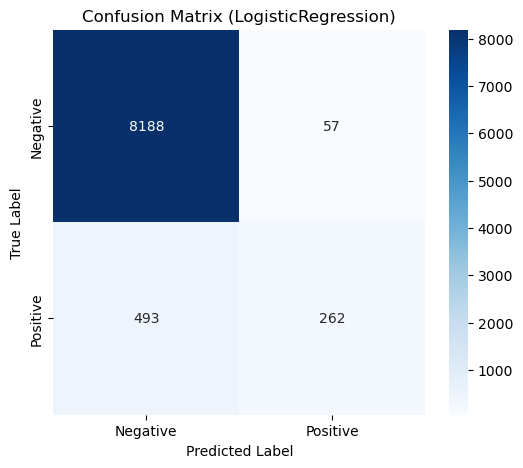

LogisticRegression metrics:
	ROC_AUC: 0.9338891320848679
	Accuracy: 0.9388888888888889
	Precision: 0.8213166144200627
	Recall: 0.34701986754966885
	F1-Score: 0.48789571694599626


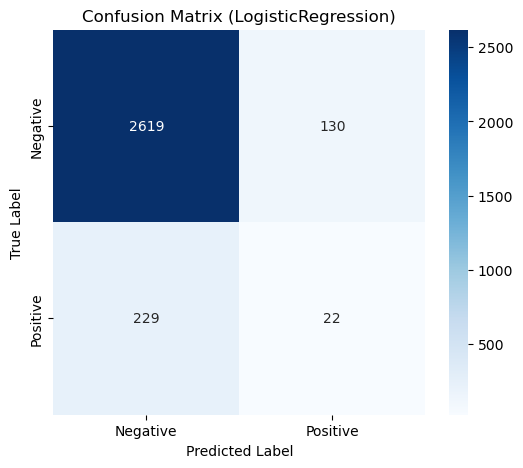

LogisticRegression metrics:
	ROC_AUC: 0.6949299926521633
	Accuracy: 0.8803333333333333
	Precision: 0.14473684210526316
	Recall: 0.08764940239043825
	F1-Score: 0.10918114143920596


In [48]:
model, test_metrics = train_and_evaluate(X_train_standardized, y_train, X_test_standardized, y_test, 'LogisticRegression')

Training Time: 95.7074 seconds


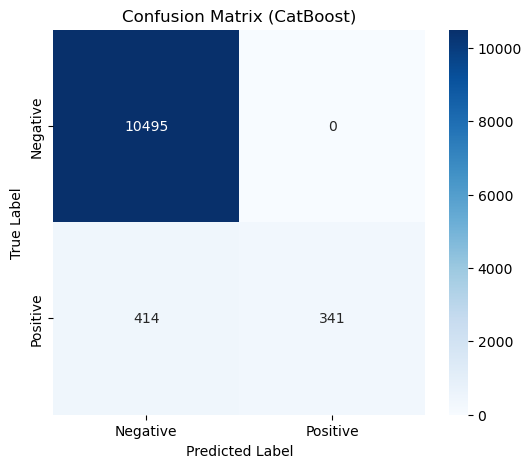

CatBoost metrics:
	ROC_AUC: 0.9890243540758923
	Accuracy: 0.9632
	Precision: 1.0
	Recall: 0.45165562913907287
	F1-Score: 0.6222627737226277


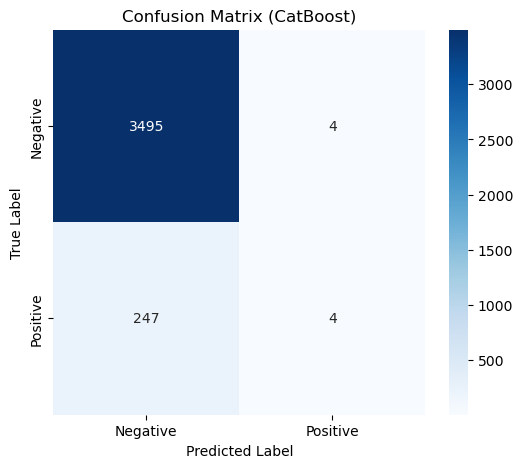

CatBoost metrics:
	ROC_AUC: 0.7787364403489215
	Accuracy: 0.9330666666666667
	Precision: 0.5
	Recall: 0.01593625498007968
	F1-Score: 0.03088803088803089


In [38]:
model, test_metrics = train_and_evaluate(X_train_standardized, y_train, X_test_standardized, y_test, 'CatBoost')

#### Feature Selection
- L1 lasso regularization
    - skip redundant features
- point biserial correlation
- recursive feature elimination (uses model coefficients w/o lasso)
     - takes a long time, starts with the initial subset of features and removes least important features recursively until target is reached

##### L1 lasso feature selection

In [28]:
def get_lasso_features(X_train, y_train):
    model_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1) # can test different Cs
    model_l1.fit(X_train, y_train)

    feature_coefs = list(zip(model_l1.feature_names_in_, model_l1.coef_[0]))
    feature_coefs.sort(key=lambda x: abs(x[1]), reverse=True)
    return feature_coefs

In [29]:
def extract_category(feature_name):
    """Extracts the category from a feature name using regex."""
    match = re.match(r'^([A-Z]+(?:_[A-Z]+)*)', feature_name)
    return match.group(1) if match else feature_name 

In [30]:
def select_top_features(features, max_features, limit=2):
    category_dict = defaultdict(list)

    # Organize features by category
    for feature, coef in features:
        category = extract_category(feature)  # Extract category using regex
        category_dict[category].append((feature, coef))

    # Sort each category by absolute coefficient value (descending)
    for category in category_dict:
        category_dict[category].sort(key=lambda item: abs(item[1]), reverse=True)

    # Select top max_features, allowing up to 2 features per category
    selected_features = []
    category_counts = defaultdict(int)  # Track how many features have been selected per category

    # Flatten sorted features by absolute importance while respecting category limits
    sorted_features = sorted(
        [feat for feats in category_dict.values() for feat in feats], 
        key=lambda item: abs(item[1]), reverse=True
    )

    for feature, coef in sorted_features:
        category = extract_category(feature)
        if len(selected_features) < max_features and category_counts[category] < limit:
            selected_features.append((feature, coef))
            category_counts[category] += 1

    return selected_features

In [31]:
def get_feature_selection_datasets(X, selected_features):
    return X[np.array(selected_features)[:, 0]]

**Feature selection experiment**

In [16]:
max_features_lst = list(range(50, 2500, 50))
X_train, X_test, y_train, y_test = split_data(features_df_DQ_no_na, test_size=0.5)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)
X_train_standardized, X_val_standardized, X_test_standardized = standardize(X_train, X_val, X_test)
feature_coefs = get_lasso_features(X_train_standardized, y_train)


 ################## Testing 50 features... ################## 

Training Time: 3.2895 seconds


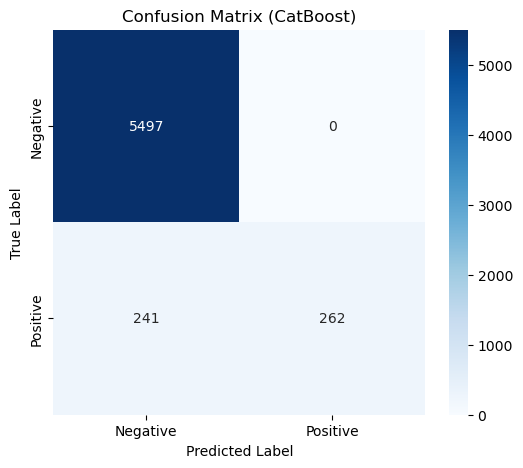

CatBoost metrics:
	ROC_AUC: 0.9868983298679815
	Accuracy: 0.9598333333333333
	Precision: 1.0
	Recall: 0.5208747514910537
	F1-Score: 0.6849673202614379


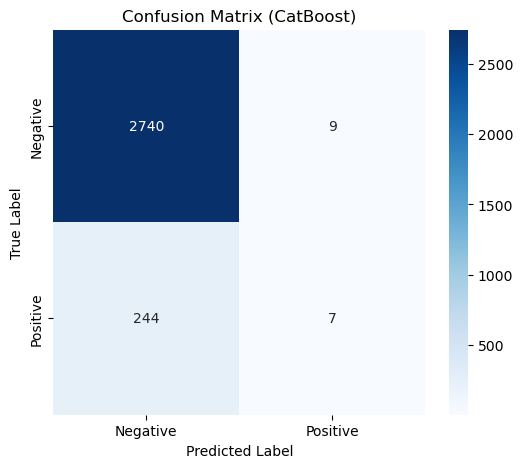

CatBoost metrics:
	ROC_AUC: 0.7505329717869156
	Accuracy: 0.9156666666666666
	Precision: 0.4375
	Recall: 0.027888446215139442
	F1-Score: 0.052434456928838954

 ################## Testing 100 features... ################## 

Training Time: 4.6398 seconds


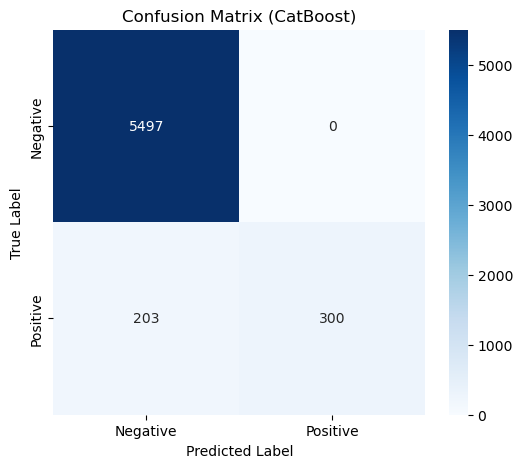

CatBoost metrics:
	ROC_AUC: 0.9891312485284763
	Accuracy: 0.9661666666666666
	Precision: 1.0
	Recall: 0.5964214711729622
	F1-Score: 0.7471980074719801


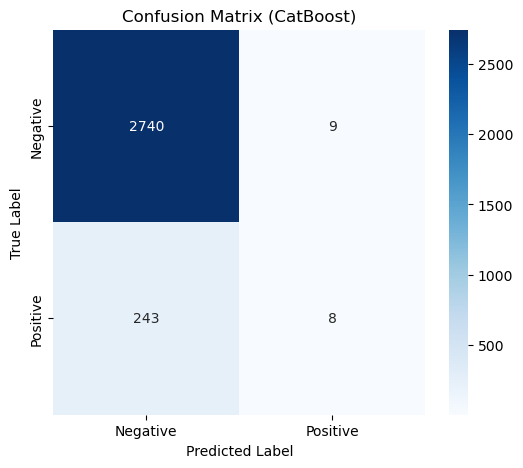

CatBoost metrics:
	ROC_AUC: 0.7625750182246641
	Accuracy: 0.916
	Precision: 0.47058823529411764
	Recall: 0.03187250996015936
	F1-Score: 0.05970149253731343

 ################## Testing 150 features... ################## 

Training Time: 6.0011 seconds


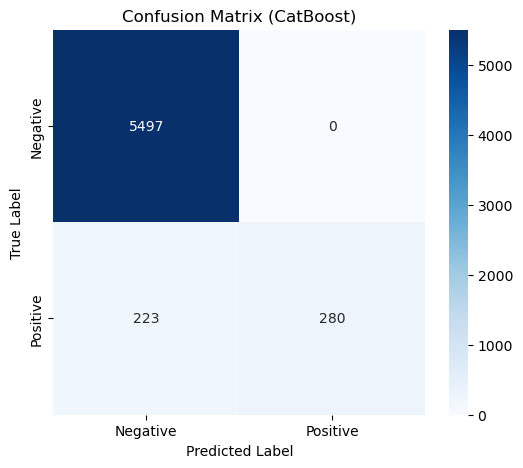

CatBoost metrics:
	ROC_AUC: 0.9891842324260729
	Accuracy: 0.9628333333333333
	Precision: 1.0
	Recall: 0.5566600397614314
	F1-Score: 0.7151979565772669


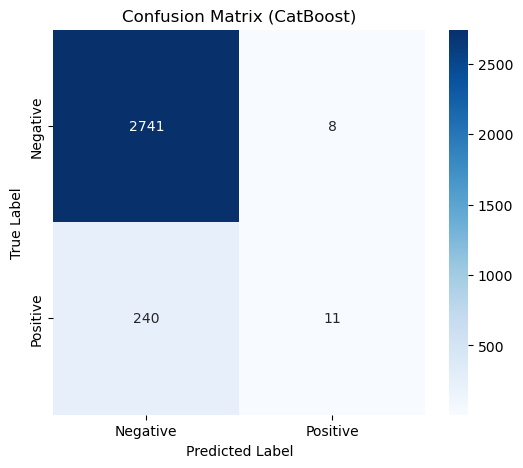

CatBoost metrics:
	ROC_AUC: 0.7711460451391958
	Accuracy: 0.9173333333333333
	Precision: 0.5789473684210527
	Recall: 0.043824701195219126
	F1-Score: 0.08148148148148149

 ################## Testing 200 features... ################## 

Training Time: 7.3185 seconds


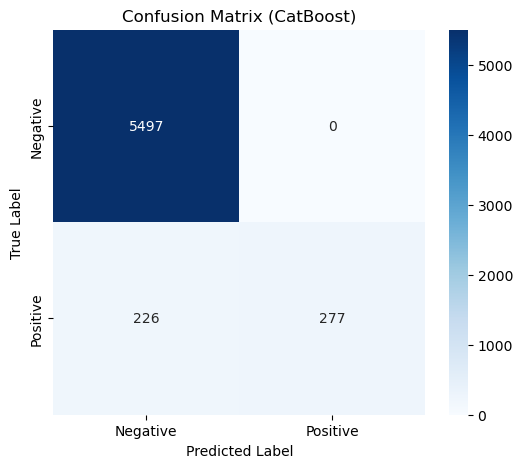

CatBoost metrics:
	ROC_AUC: 0.9897012323005753
	Accuracy: 0.9623333333333334
	Precision: 1.0
	Recall: 0.5506958250497018
	F1-Score: 0.7102564102564103


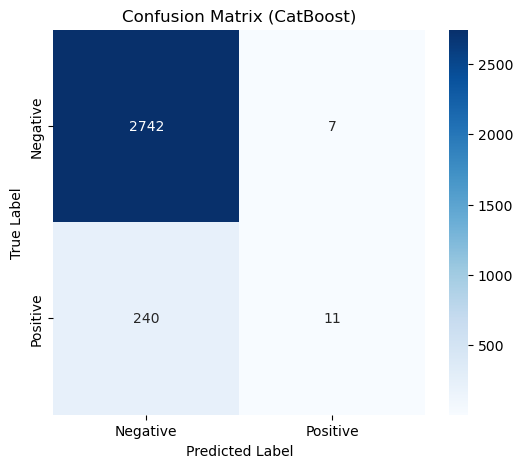

CatBoost metrics:
	ROC_AUC: 0.7698416954227469
	Accuracy: 0.9176666666666666
	Precision: 0.6111111111111112
	Recall: 0.043824701195219126
	F1-Score: 0.08178438661710037

 ################## Testing 250 features... ################## 

Training Time: 8.6411 seconds


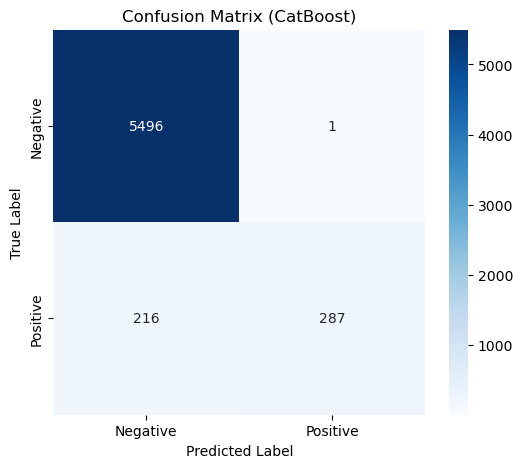

CatBoost metrics:
	ROC_AUC: 0.98894462947619
	Accuracy: 0.9638333333333333
	Precision: 0.9965277777777778
	Recall: 0.5705765407554672
	F1-Score: 0.7256637168141593


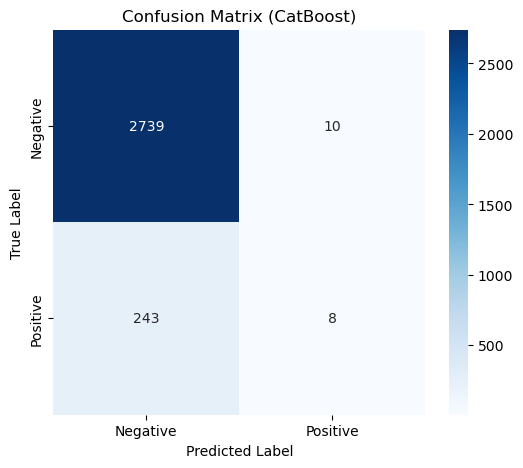

CatBoost metrics:
	ROC_AUC: 0.7736076429096275
	Accuracy: 0.9156666666666666
	Precision: 0.4444444444444444
	Recall: 0.03187250996015936
	F1-Score: 0.05947955390334572

 ################## Testing 300 features... ################## 

Training Time: 10.1562 seconds


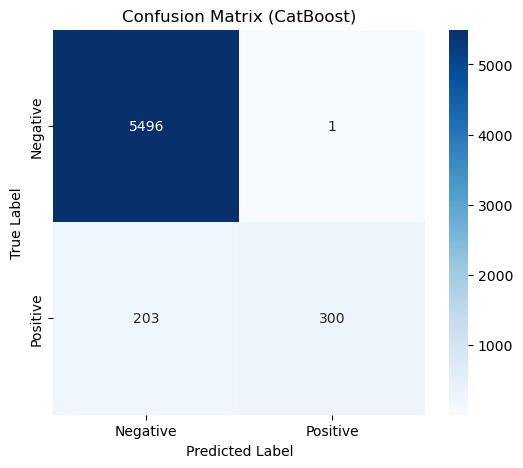

CatBoost metrics:
	ROC_AUC: 0.9907954492437769
	Accuracy: 0.966
	Precision: 0.9966777408637874
	Recall: 0.5964214711729622
	F1-Score: 0.746268656716418


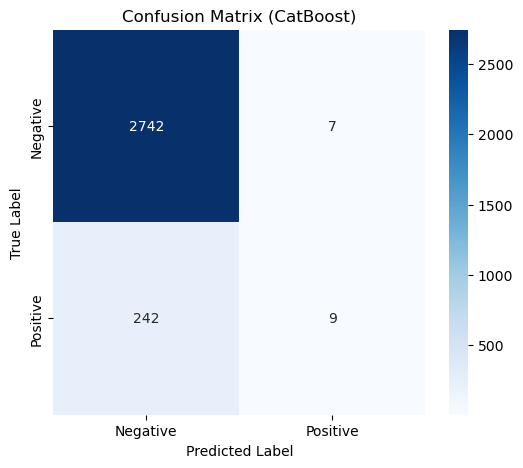

CatBoost metrics:
	ROC_AUC: 0.7768127200184348
	Accuracy: 0.917
	Precision: 0.5625
	Recall: 0.035856573705179286
	F1-Score: 0.06741573033707865

 ################## Testing 350 features... ################## 

Training Time: 11.8030 seconds


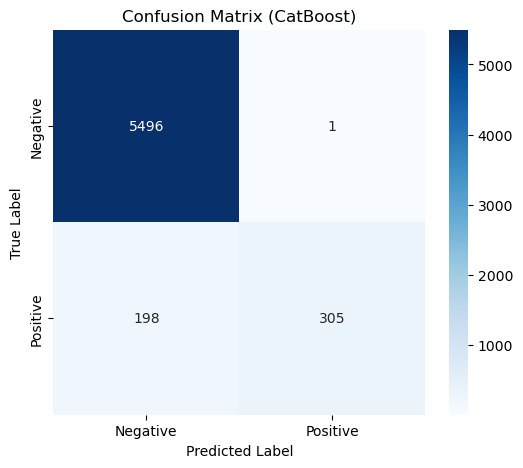

CatBoost metrics:
	ROC_AUC: 0.9921905713255486
	Accuracy: 0.9668333333333333
	Precision: 0.9967320261437909
	Recall: 0.6063618290258449
	F1-Score: 0.754017305315204


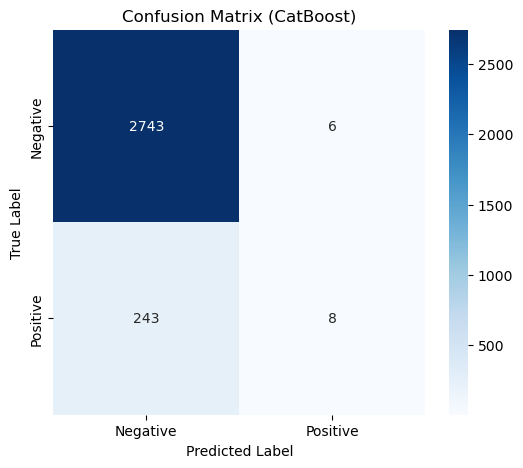

CatBoost metrics:
	ROC_AUC: 0.7677279242433686
	Accuracy: 0.917
	Precision: 0.5714285714285714
	Recall: 0.03187250996015936
	F1-Score: 0.06037735849056604

 ################## Testing 400 features... ################## 

Training Time: 13.5253 seconds


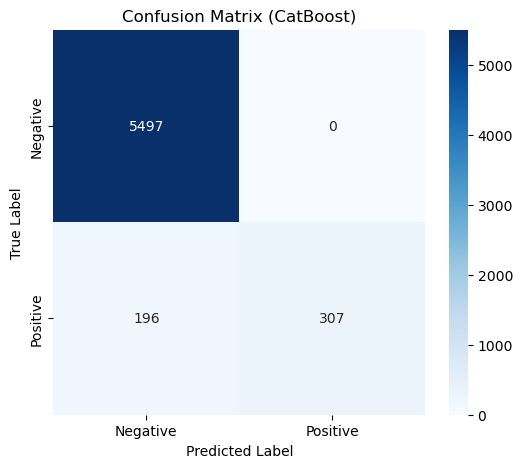

CatBoost metrics:
	ROC_AUC: 0.9927167936532163
	Accuracy: 0.9673333333333334
	Precision: 1.0
	Recall: 0.610337972166998
	F1-Score: 0.7580246913580246


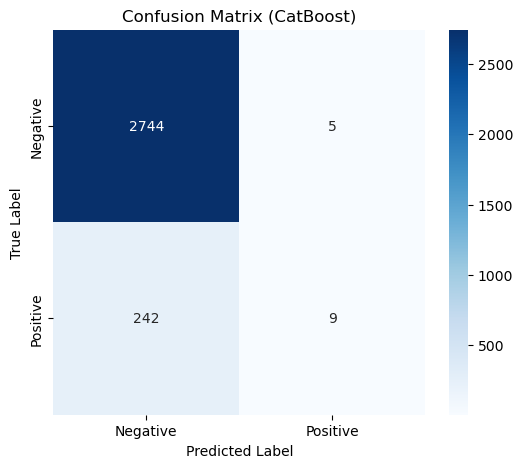

CatBoost metrics:
	ROC_AUC: 0.7818996839125855
	Accuracy: 0.9176666666666666
	Precision: 0.6428571428571429
	Recall: 0.035856573705179286
	F1-Score: 0.06792452830188679

 ################## Testing 450 features... ################## 

Training Time: 15.1600 seconds


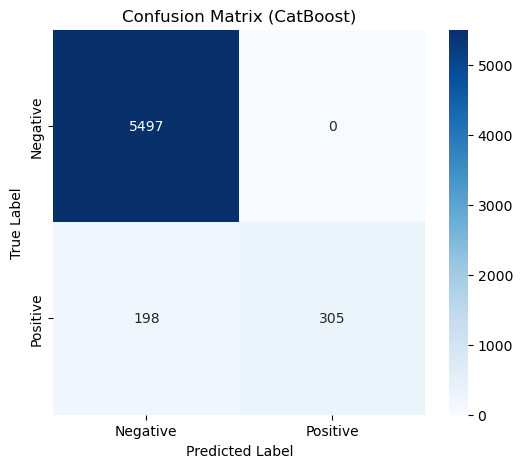

CatBoost metrics:
	ROC_AUC: 0.9932585675685743
	Accuracy: 0.967
	Precision: 1.0
	Recall: 0.6063618290258449
	F1-Score: 0.754950495049505


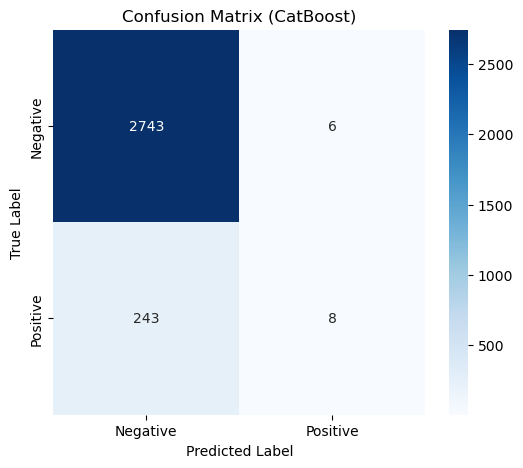

CatBoost metrics:
	ROC_AUC: 0.7824851920075246
	Accuracy: 0.917
	Precision: 0.5714285714285714
	Recall: 0.03187250996015936
	F1-Score: 0.06037735849056604

 ################## Testing 500 features... ################## 

Training Time: 16.6346 seconds


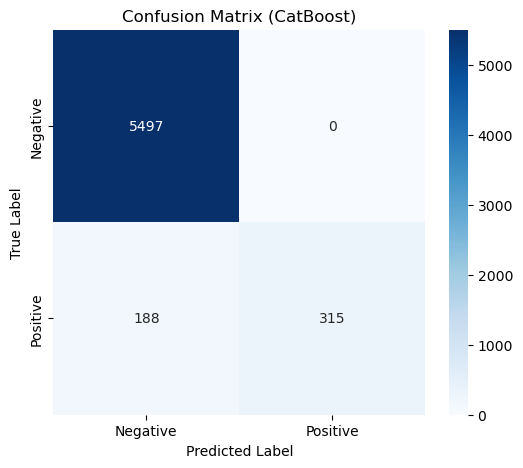

CatBoost metrics:
	ROC_AUC: 0.9931346973642952
	Accuracy: 0.9686666666666667
	Precision: 1.0
	Recall: 0.6262425447316103
	F1-Score: 0.7701711491442543


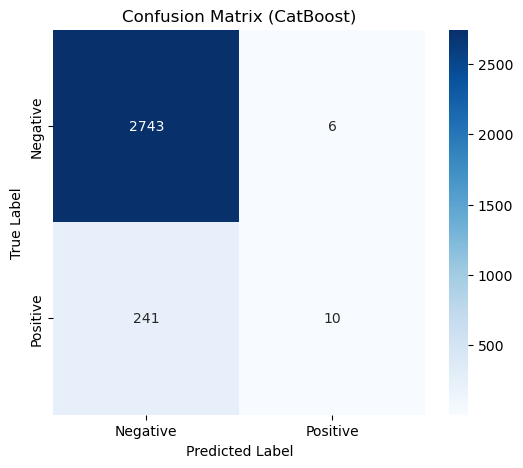

CatBoost metrics:
	ROC_AUC: 0.7841975133297294
	Accuracy: 0.9176666666666666
	Precision: 0.625
	Recall: 0.0398406374501992
	F1-Score: 0.0749063670411985

 ################## Testing 550 features... ################## 

Training Time: 18.0383 seconds


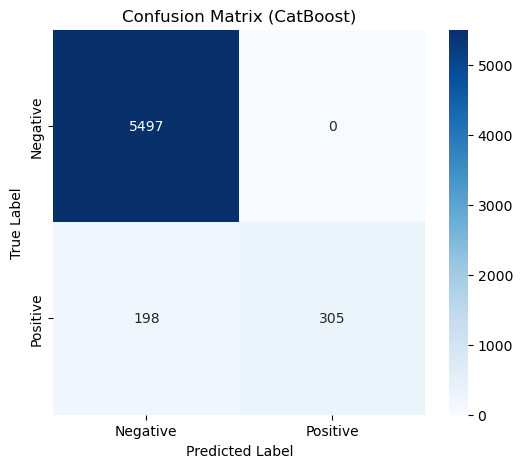

CatBoost metrics:
	ROC_AUC: 0.9921377682603668
	Accuracy: 0.967
	Precision: 1.0
	Recall: 0.6063618290258449
	F1-Score: 0.754950495049505


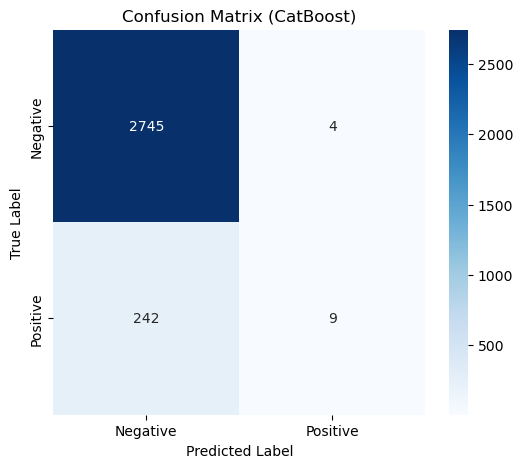

CatBoost metrics:
	ROC_AUC: 0.7822018582635627
	Accuracy: 0.918
	Precision: 0.6923076923076923
	Recall: 0.035856573705179286
	F1-Score: 0.06818181818181818

 ################## Testing 600 features... ################## 

Training Time: 19.4723 seconds


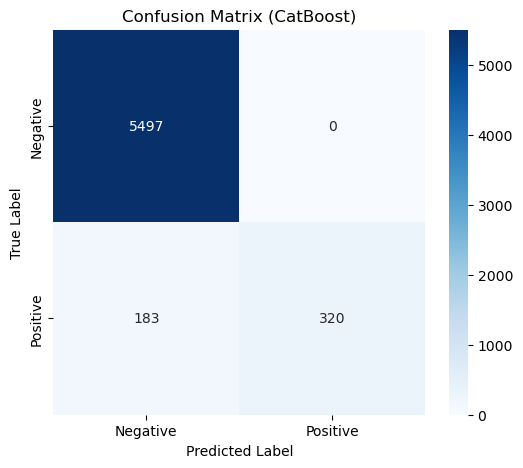

CatBoost metrics:
	ROC_AUC: 0.9939292749958317
	Accuracy: 0.9695
	Precision: 1.0
	Recall: 0.6361829025844931
	F1-Score: 0.7776427703523694


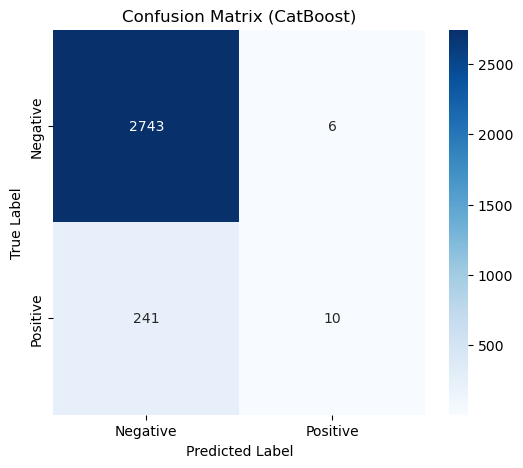

CatBoost metrics:
	ROC_AUC: 0.7803018555099355
	Accuracy: 0.9176666666666666
	Precision: 0.625
	Recall: 0.0398406374501992
	F1-Score: 0.0749063670411985

 ################## Testing 650 features... ################## 

Training Time: 20.9673 seconds


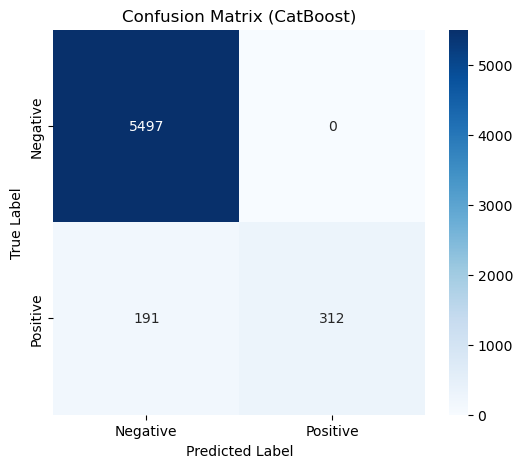

CatBoost metrics:
	ROC_AUC: 0.993908479268106
	Accuracy: 0.9681666666666666
	Precision: 1.0
	Recall: 0.6202783300198808
	F1-Score: 0.7656441717791411


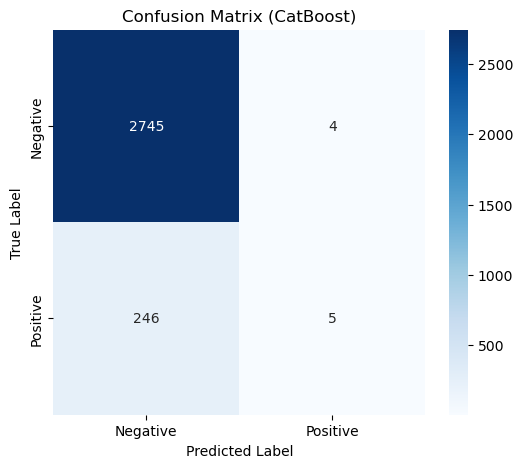

CatBoost metrics:
	ROC_AUC: 0.7781895336080198
	Accuracy: 0.9166666666666666
	Precision: 0.5555555555555556
	Recall: 0.0199203187250996
	F1-Score: 0.038461538461538464

 ################## Testing 700 features... ################## 

Training Time: 22.3275 seconds


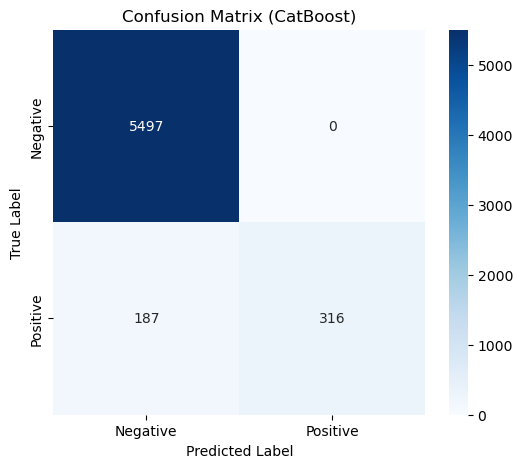

CatBoost metrics:
	ROC_AUC: 0.9928721286977064
	Accuracy: 0.9688333333333333
	Precision: 1.0
	Recall: 0.6282306163021869
	F1-Score: 0.7716727716727717


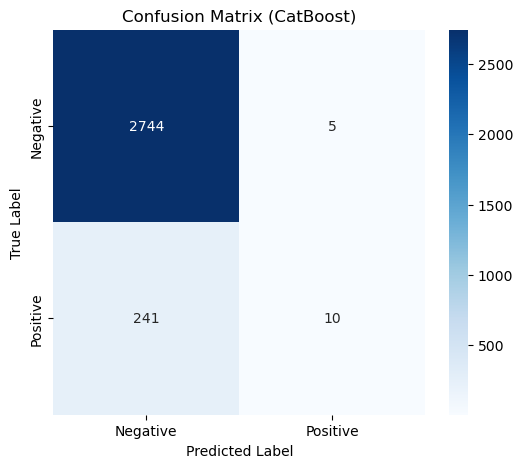

CatBoost metrics:
	ROC_AUC: 0.7852975149239346
	Accuracy: 0.918
	Precision: 0.6666666666666666
	Recall: 0.0398406374501992
	F1-Score: 0.07518796992481203

 ################## Testing 750 features... ################## 

Training Time: 23.6440 seconds


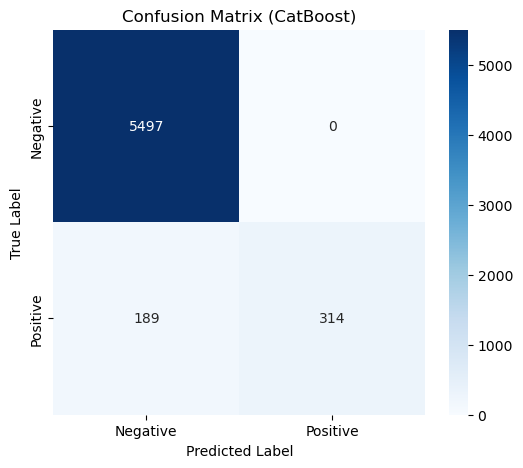

CatBoost metrics:
	ROC_AUC: 0.9932840649390902
	Accuracy: 0.9685
	Precision: 1.0
	Recall: 0.6242544731610338
	F1-Score: 0.7686658506731946


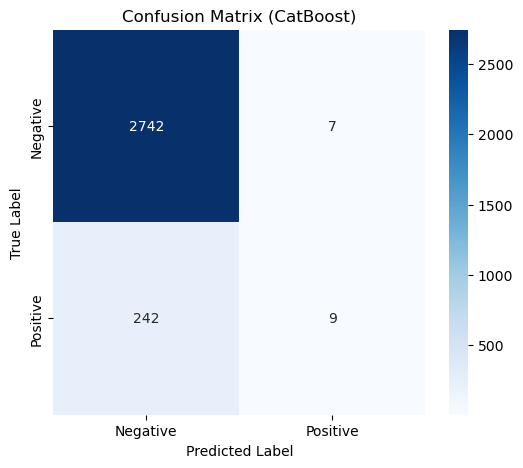

CatBoost metrics:
	ROC_AUC: 0.7832779467796329
	Accuracy: 0.917
	Precision: 0.5625
	Recall: 0.035856573705179286
	F1-Score: 0.06741573033707865

 ################## Testing 800 features... ################## 

Training Time: 24.9436 seconds


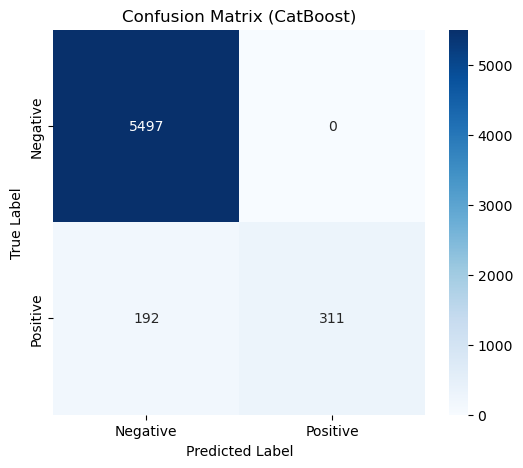

CatBoost metrics:
	ROC_AUC: 0.9934764706286567
	Accuracy: 0.968
	Precision: 1.0
	Recall: 0.6182902584493042
	F1-Score: 0.7641277641277642


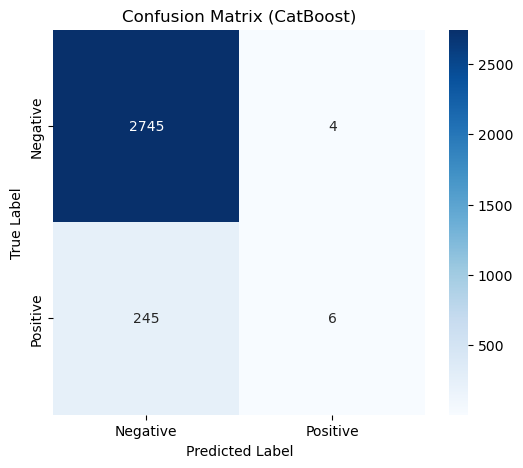

CatBoost metrics:
	ROC_AUC: 0.7710098130577002
	Accuracy: 0.917
	Precision: 0.6
	Recall: 0.02390438247011952
	F1-Score: 0.04597701149425287

 ################## Testing 850 features... ################## 

Training Time: 26.2805 seconds


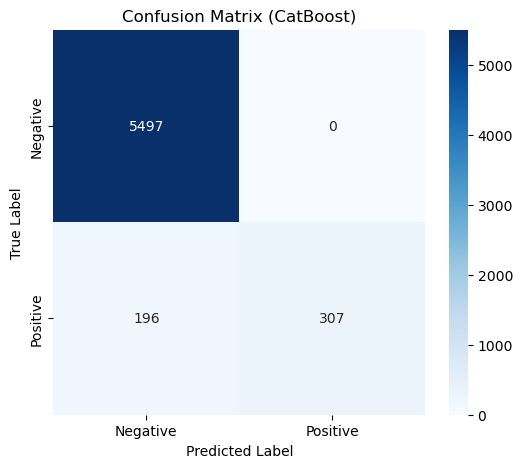

CatBoost metrics:
	ROC_AUC: 0.992232705278245
	Accuracy: 0.9673333333333334
	Precision: 1.0
	Recall: 0.610337972166998
	F1-Score: 0.7580246913580246


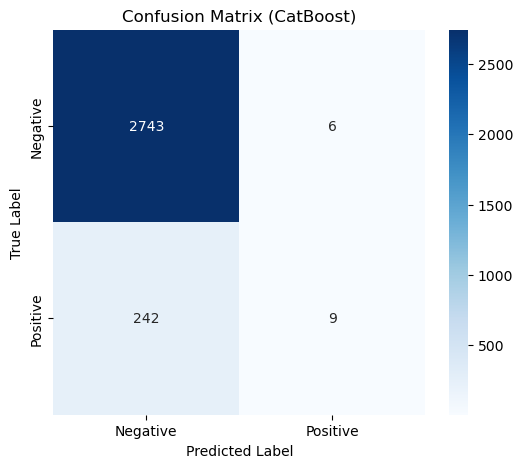

CatBoost metrics:
	ROC_AUC: 0.7752692395206371
	Accuracy: 0.9173333333333333
	Precision: 0.6
	Recall: 0.035856573705179286
	F1-Score: 0.06766917293233082

 ################## Testing 900 features... ################## 

Training Time: 27.7238 seconds


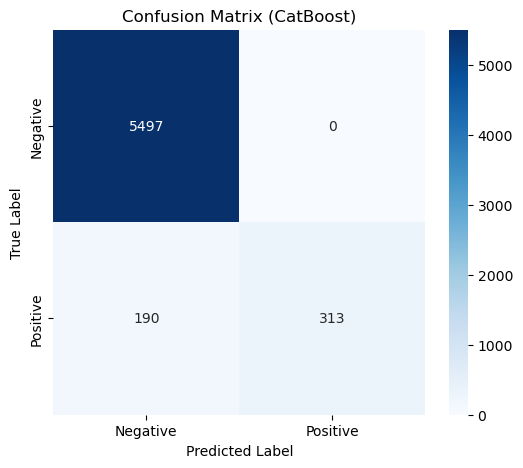

CatBoost metrics:
	ROC_AUC: 0.9928169748111295
	Accuracy: 0.9683333333333334
	Precision: 1.0
	Recall: 0.6222664015904572
	F1-Score: 0.7671568627450981


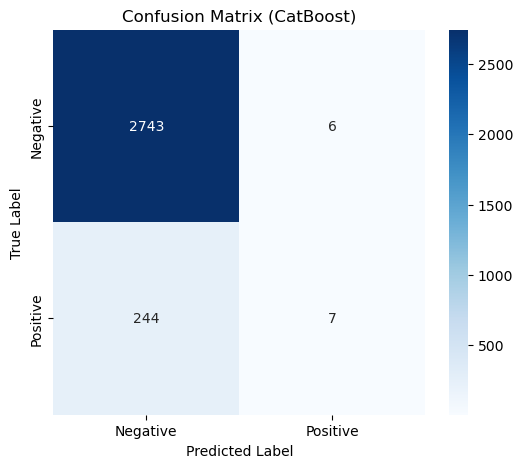

CatBoost metrics:
	ROC_AUC: 0.7816721473509383
	Accuracy: 0.9166666666666666
	Precision: 0.5384615384615384
	Recall: 0.027888446215139442
	F1-Score: 0.05303030303030303

 ################## Testing 950 features... ################## 

Training Time: 28.9328 seconds


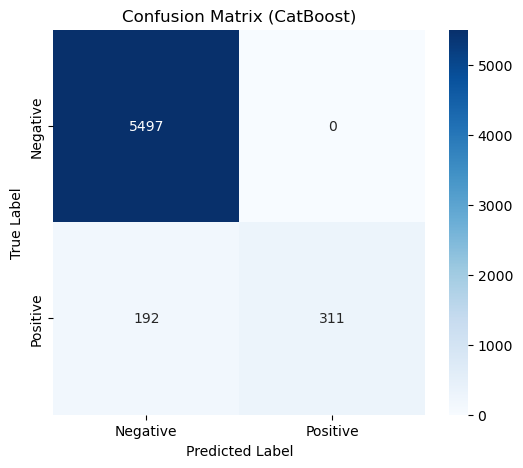

CatBoost metrics:
	ROC_AUC: 0.9933059456613059
	Accuracy: 0.968
	Precision: 1.0
	Recall: 0.6182902584493042
	F1-Score: 0.7641277641277642


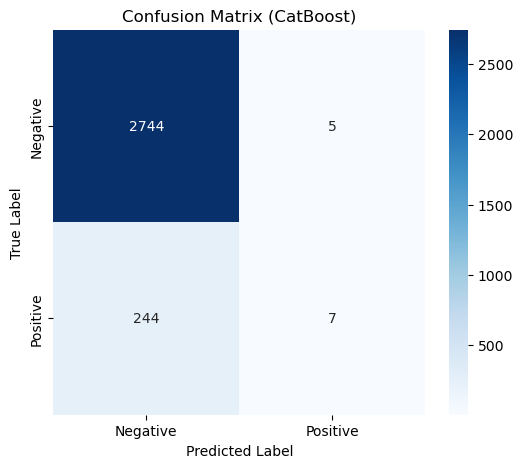

CatBoost metrics:
	ROC_AUC: 0.7705561892118684
	Accuracy: 0.917
	Precision: 0.5833333333333334
	Recall: 0.027888446215139442
	F1-Score: 0.053231939163498096

 ################## Testing 1000 features... ################## 

Training Time: 30.3103 seconds


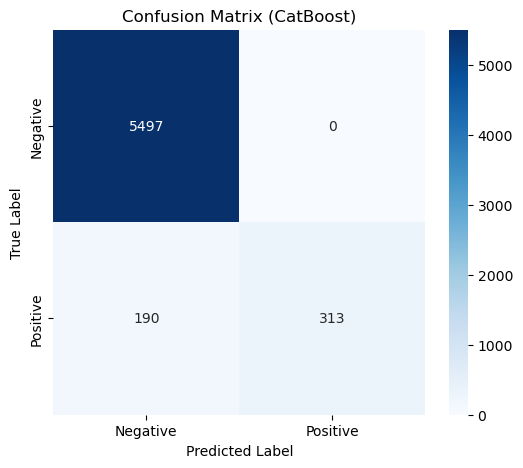

CatBoost metrics:
	ROC_AUC: 0.9930245704235565
	Accuracy: 0.9683333333333334
	Precision: 1.0
	Recall: 0.6222664015904572
	F1-Score: 0.7671568627450981


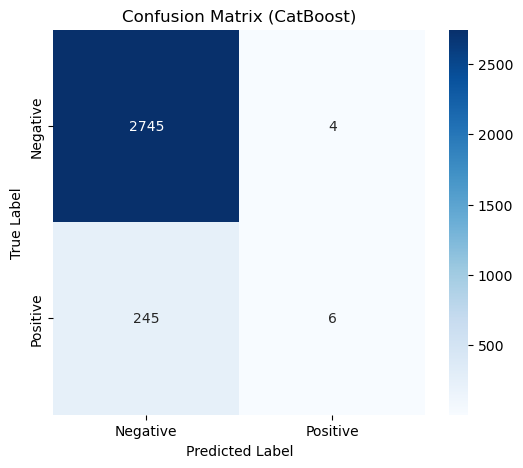

CatBoost metrics:
	ROC_AUC: 0.7731931495552892
	Accuracy: 0.917
	Precision: 0.6
	Recall: 0.02390438247011952
	F1-Score: 0.04597701149425287

 ################## Testing 1050 features... ################## 

Training Time: 31.5752 seconds


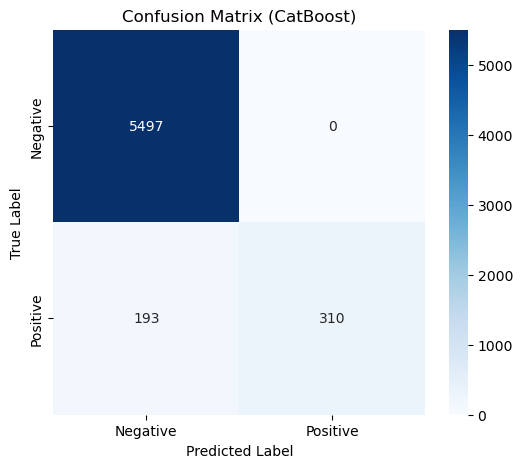

CatBoost metrics:
	ROC_AUC: 0.9926815313322901
	Accuracy: 0.9678333333333333
	Precision: 1.0
	Recall: 0.6163021868787276
	F1-Score: 0.7626076260762608


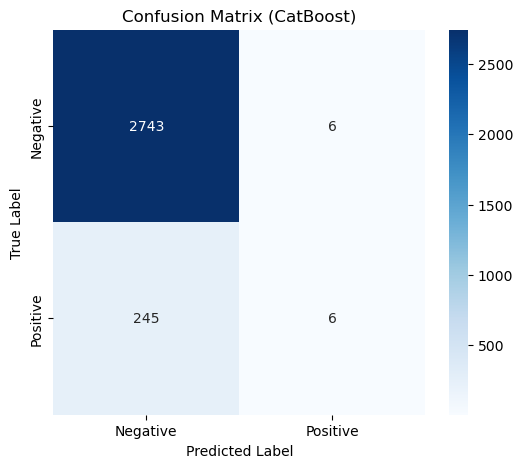

CatBoost metrics:
	ROC_AUC: 0.7745946008617404
	Accuracy: 0.9163333333333333
	Precision: 0.5
	Recall: 0.02390438247011952
	F1-Score: 0.045627376425855515

 ################## Testing 1100 features... ################## 

Training Time: 32.9038 seconds


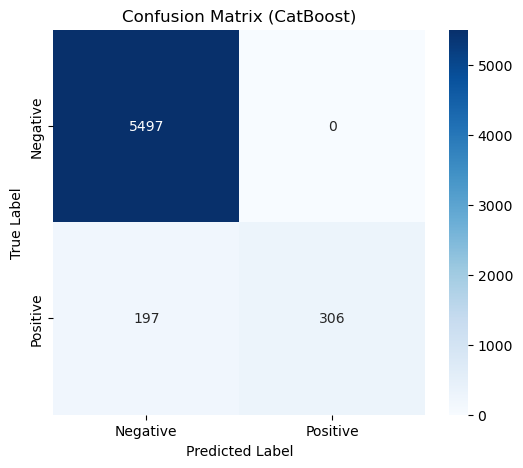

CatBoost metrics:
	ROC_AUC: 0.9936620046864529
	Accuracy: 0.9671666666666666
	Precision: 1.0
	Recall: 0.6083499005964215
	F1-Score: 0.7564894932014833


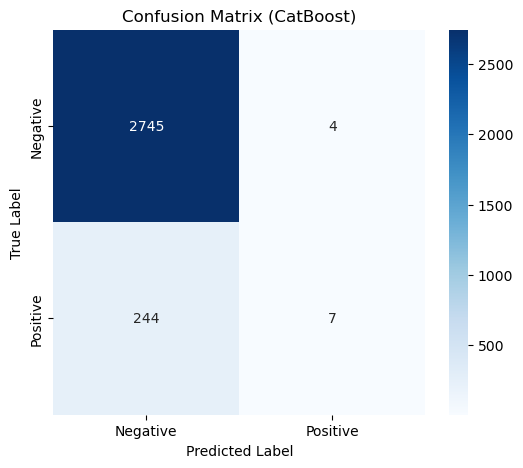

CatBoost metrics:
	ROC_AUC: 0.7772308365664298
	Accuracy: 0.9173333333333333
	Precision: 0.6363636363636364
	Recall: 0.027888446215139442
	F1-Score: 0.05343511450381679

 ################## Testing 1150 features... ################## 

Training Time: 34.1157 seconds


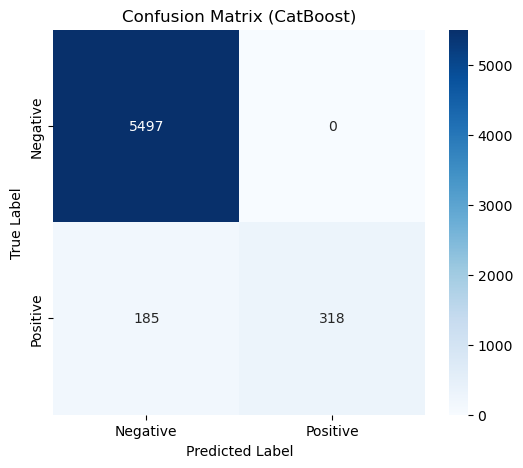

CatBoost metrics:
	ROC_AUC: 0.992860917087976
	Accuracy: 0.9691666666666666
	Precision: 1.0
	Recall: 0.6322067594433399
	F1-Score: 0.7746650426309378


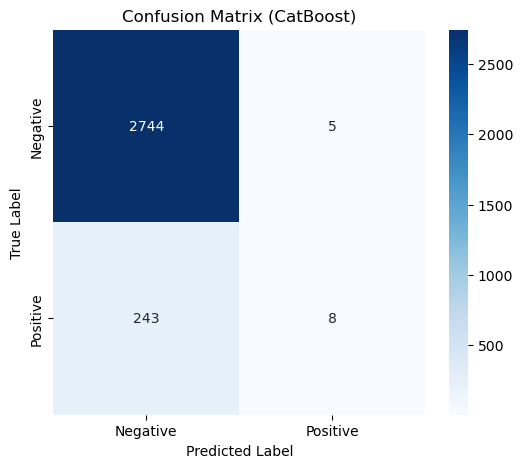

CatBoost metrics:
	ROC_AUC: 0.7753960512986251
	Accuracy: 0.9173333333333333
	Precision: 0.6153846153846154
	Recall: 0.03187250996015936
	F1-Score: 0.06060606060606061

 ################## Testing 1200 features... ################## 

Training Time: 35.4916 seconds


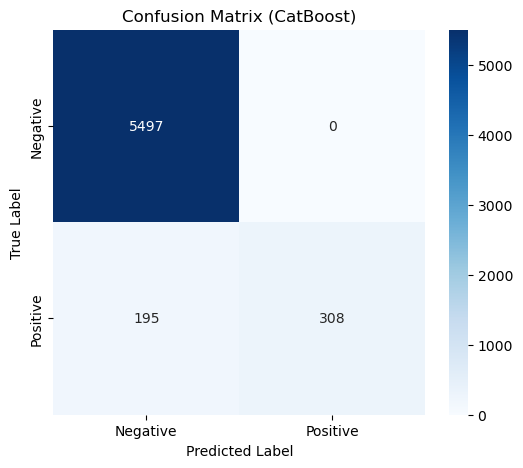

CatBoost metrics:
	ROC_AUC: 0.993788949041787
	Accuracy: 0.9675
	Precision: 1.0
	Recall: 0.6123260437375746
	F1-Score: 0.7595561035758323


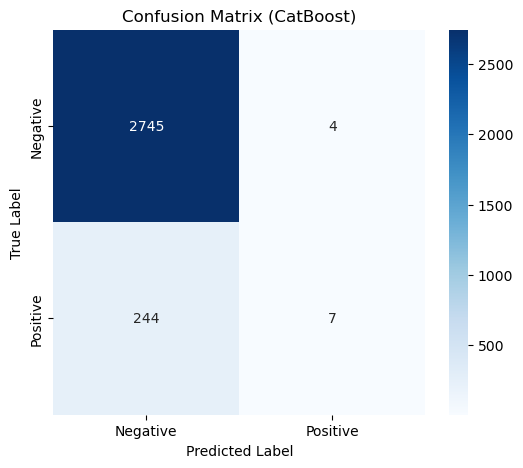

CatBoost metrics:
	ROC_AUC: 0.7760431536857301
	Accuracy: 0.9173333333333333
	Precision: 0.6363636363636364
	Recall: 0.027888446215139442
	F1-Score: 0.05343511450381679

 ################## Testing 1250 features... ################## 

Training Time: 36.8841 seconds


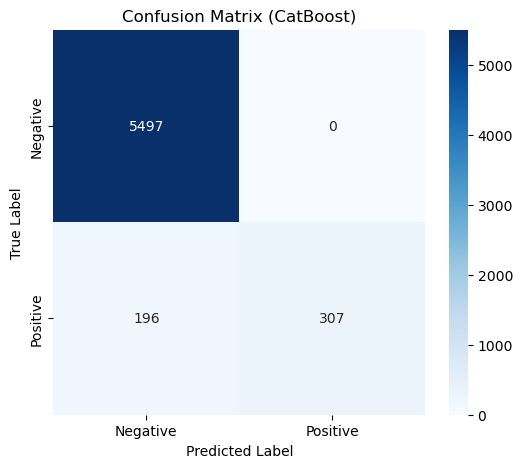

CatBoost metrics:
	ROC_AUC: 0.9935489844270741
	Accuracy: 0.9673333333333334
	Precision: 1.0
	Recall: 0.610337972166998
	F1-Score: 0.7580246913580246


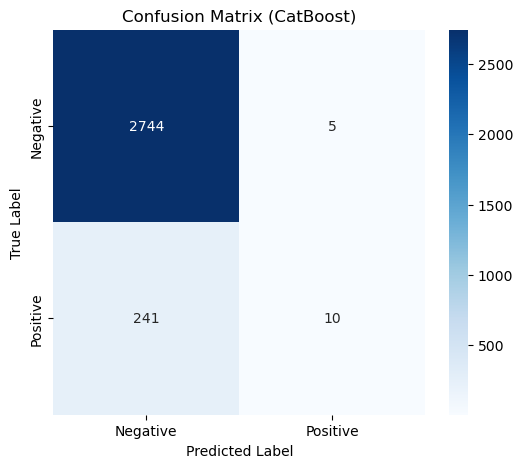

CatBoost metrics:
	ROC_AUC: 0.7782337365706328
	Accuracy: 0.918
	Precision: 0.6666666666666666
	Recall: 0.0398406374501992
	F1-Score: 0.07518796992481203

 ################## Testing 1300 features... ################## 

Training Time: 38.1512 seconds


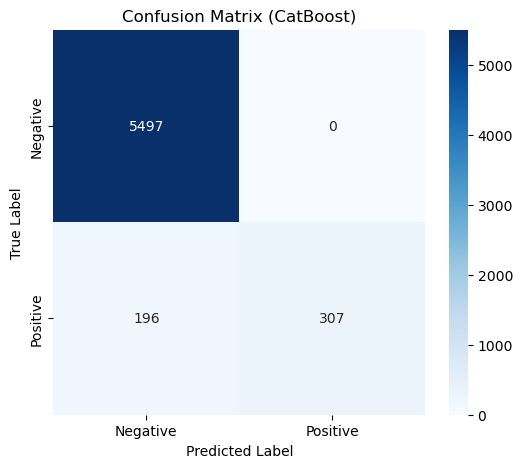

CatBoost metrics:
	ROC_AUC: 0.9932685133513998
	Accuracy: 0.9673333333333334
	Precision: 1.0
	Recall: 0.610337972166998
	F1-Score: 0.7580246913580246


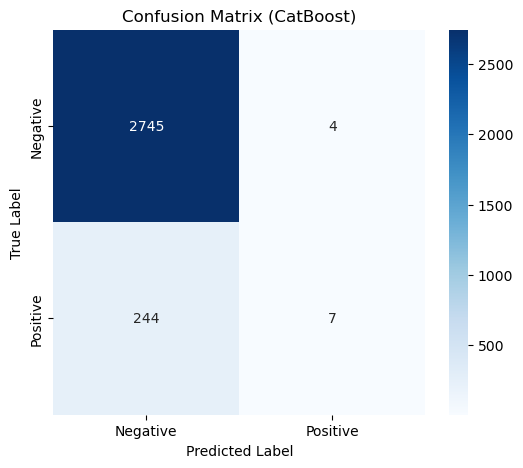

CatBoost metrics:
	ROC_AUC: 0.7820156261096031
	Accuracy: 0.9173333333333333
	Precision: 0.6363636363636364
	Recall: 0.027888446215139442
	F1-Score: 0.05343511450381679

 ################## Testing 1350 features... ################## 

Training Time: 39.4892 seconds


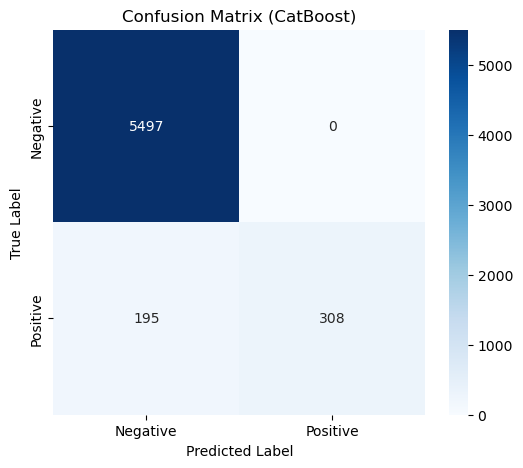

CatBoost metrics:
	ROC_AUC: 0.9936614621892079
	Accuracy: 0.9675
	Precision: 1.0
	Recall: 0.6123260437375746
	F1-Score: 0.7595561035758323


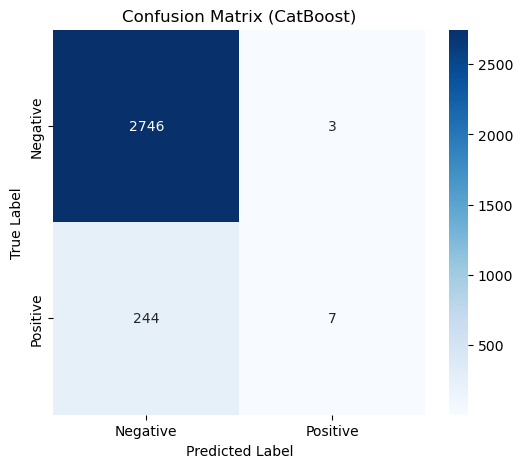

CatBoost metrics:
	ROC_AUC: 0.7794931586857374
	Accuracy: 0.9176666666666666
	Precision: 0.7
	Recall: 0.027888446215139442
	F1-Score: 0.05363984674329502

 ################## Testing 1400 features... ################## 

Training Time: 40.9023 seconds


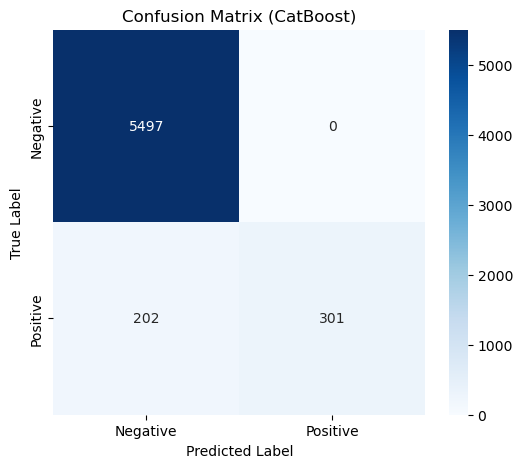

CatBoost metrics:
	ROC_AUC: 0.9936448256070273
	Accuracy: 0.9663333333333334
	Precision: 1.0
	Recall: 0.5984095427435387
	F1-Score: 0.7487562189054726


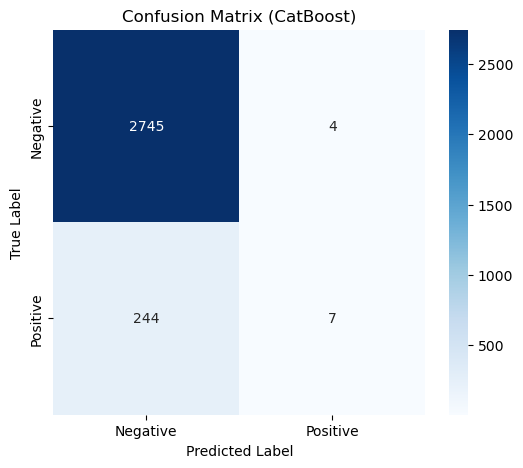

CatBoost metrics:
	ROC_AUC: 0.7773301120726261
	Accuracy: 0.9173333333333333
	Precision: 0.6363636363636364
	Recall: 0.027888446215139442
	F1-Score: 0.05343511450381679

 ################## Testing 1450 features... ################## 

Training Time: 42.3305 seconds


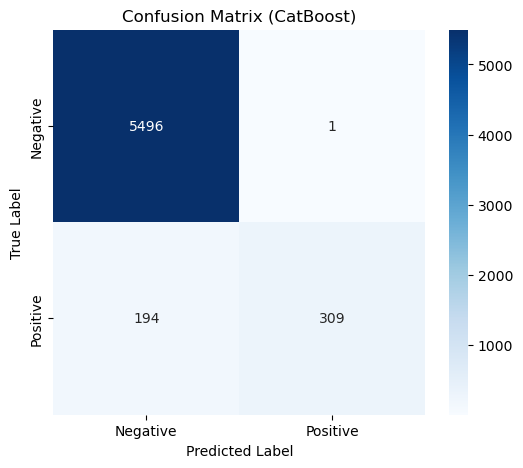

CatBoost metrics:
	ROC_AUC: 0.9931681513610713
	Accuracy: 0.9675
	Precision: 0.9967741935483871
	Recall: 0.614314115308151
	F1-Score: 0.7601476014760148


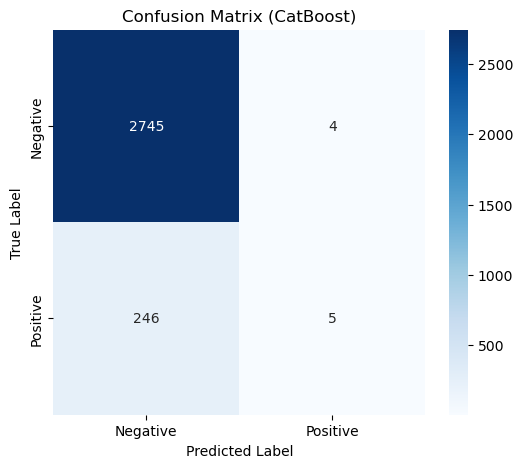

CatBoost metrics:
	ROC_AUC: 0.785963457918055
	Accuracy: 0.9166666666666666
	Precision: 0.5555555555555556
	Recall: 0.0199203187250996
	F1-Score: 0.038461538461538464

 ################## Testing 1500 features... ################## 

Training Time: 43.5588 seconds


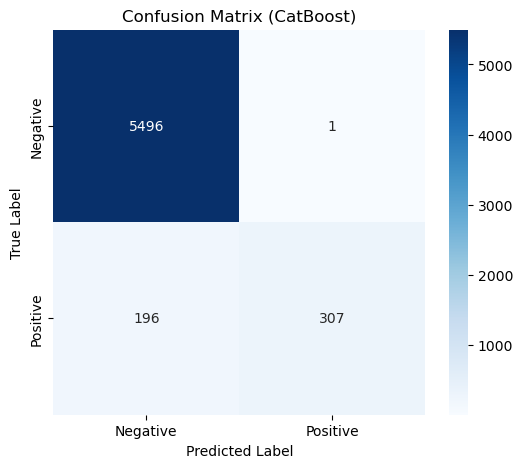

CatBoost metrics:
	ROC_AUC: 0.9926697772253147
	Accuracy: 0.9671666666666666
	Precision: 0.9967532467532467
	Recall: 0.610337972166998
	F1-Score: 0.7570900123304563


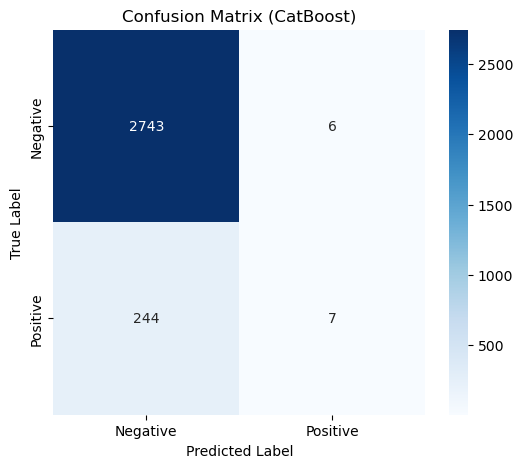

CatBoost metrics:
	ROC_AUC: 0.7855047616011037
	Accuracy: 0.9166666666666666
	Precision: 0.5384615384615384
	Recall: 0.027888446215139442
	F1-Score: 0.05303030303030303

 ################## Testing 1550 features... ################## 

Training Time: 44.8593 seconds


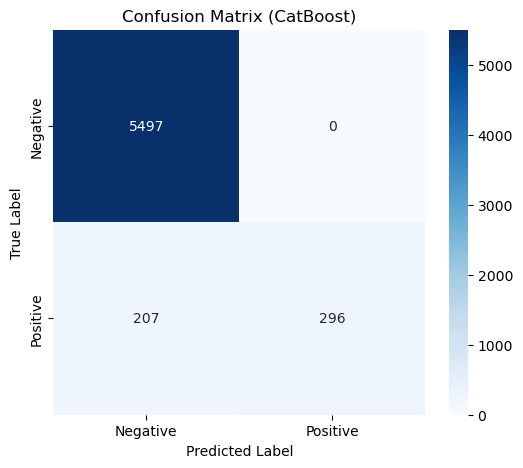

CatBoost metrics:
	ROC_AUC: 0.992770320048058
	Accuracy: 0.9655
	Precision: 1.0
	Recall: 0.588469184890656
	F1-Score: 0.7409261576971214


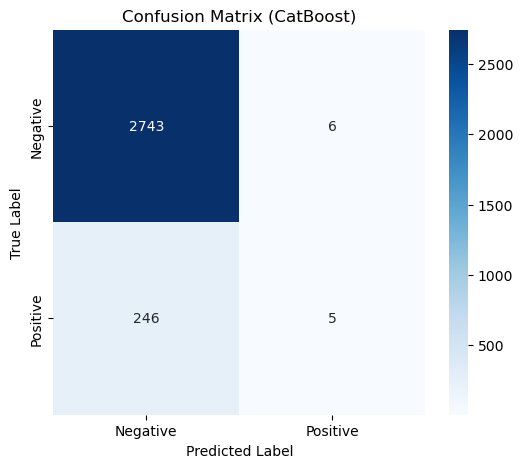

CatBoost metrics:
	ROC_AUC: 0.7833235990197087
	Accuracy: 0.916
	Precision: 0.45454545454545453
	Recall: 0.0199203187250996
	F1-Score: 0.03816793893129771

 ################## Testing 1600 features... ################## 

Training Time: 46.1769 seconds


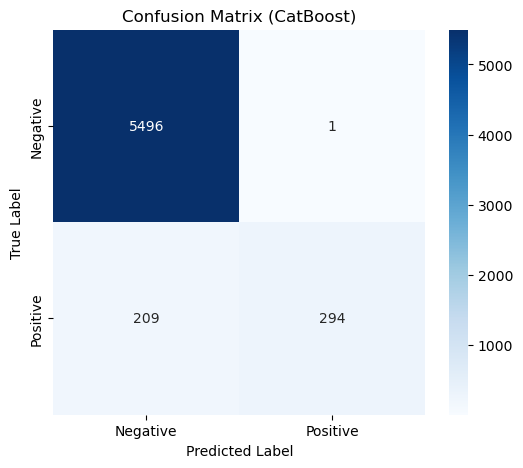

CatBoost metrics:
	ROC_AUC: 0.9923630854494644
	Accuracy: 0.965
	Precision: 0.9966101694915255
	Recall: 0.584493041749503
	F1-Score: 0.7368421052631579


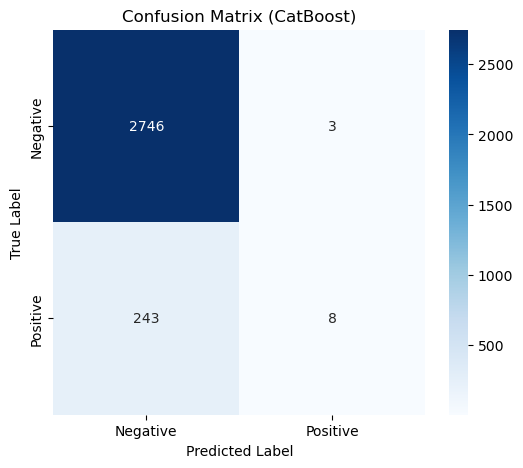

CatBoost metrics:
	ROC_AUC: 0.7840721508292042
	Accuracy: 0.918
	Precision: 0.7272727272727273
	Recall: 0.03187250996015936
	F1-Score: 0.061068702290076333

 ################## Testing 1650 features... ################## 

Training Time: 47.3079 seconds


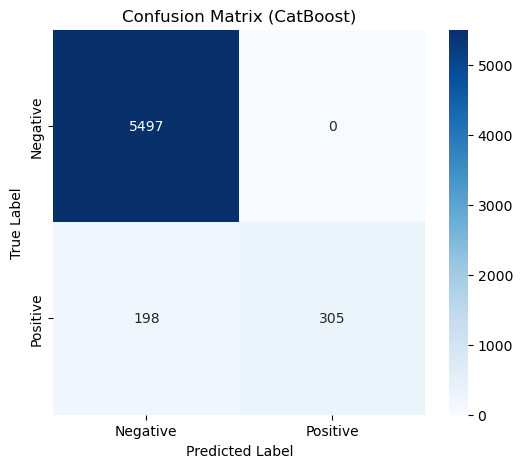

CatBoost metrics:
	ROC_AUC: 0.9928965410737323
	Accuracy: 0.967
	Precision: 1.0
	Recall: 0.6063618290258449
	F1-Score: 0.754950495049505


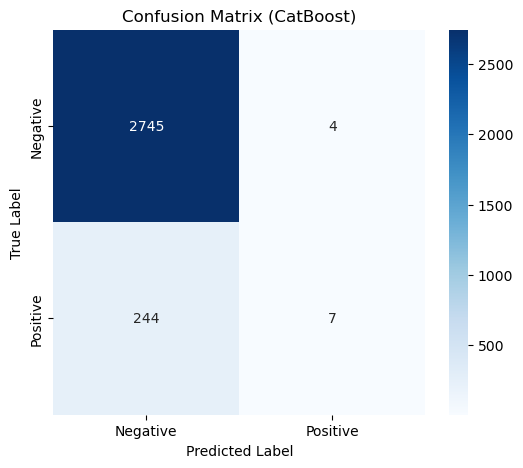

CatBoost metrics:
	ROC_AUC: 0.7774264890238972
	Accuracy: 0.9173333333333333
	Precision: 0.6363636363636364
	Recall: 0.027888446215139442
	F1-Score: 0.05343511450381679

 ################## Testing 1700 features... ################## 

Training Time: 49.0900 seconds


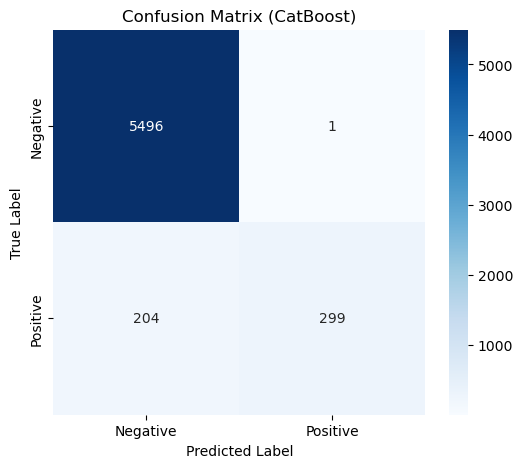

CatBoost metrics:
	ROC_AUC: 0.9928630870769561
	Accuracy: 0.9658333333333333
	Precision: 0.9966666666666667
	Recall: 0.5944333996023857
	F1-Score: 0.7447073474470735


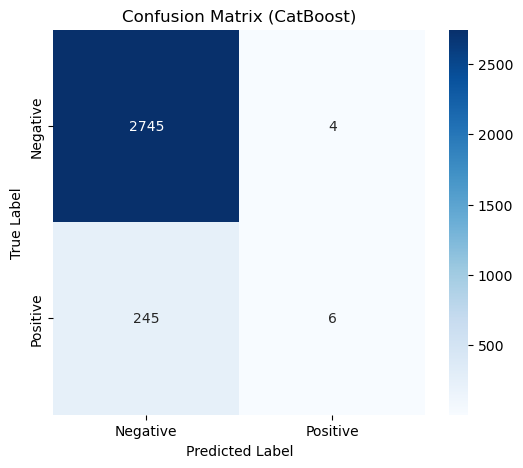

CatBoost metrics:
	ROC_AUC: 0.7785685196645212
	Accuracy: 0.917
	Precision: 0.6
	Recall: 0.02390438247011952
	F1-Score: 0.04597701149425287

 ################## Testing 1750 features... ################## 

Training Time: 50.6359 seconds


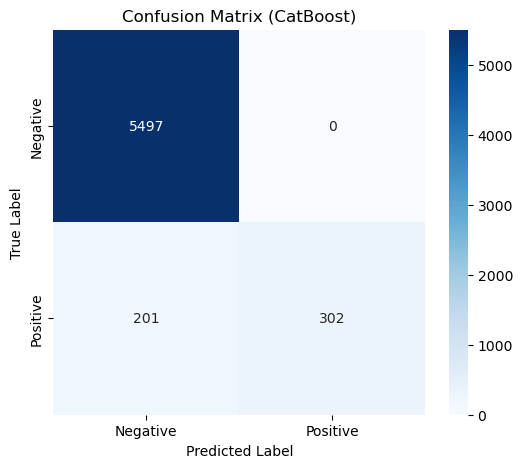

CatBoost metrics:
	ROC_AUC: 0.9931426539905556
	Accuracy: 0.9665
	Precision: 1.0
	Recall: 0.6003976143141153
	F1-Score: 0.7503105590062111


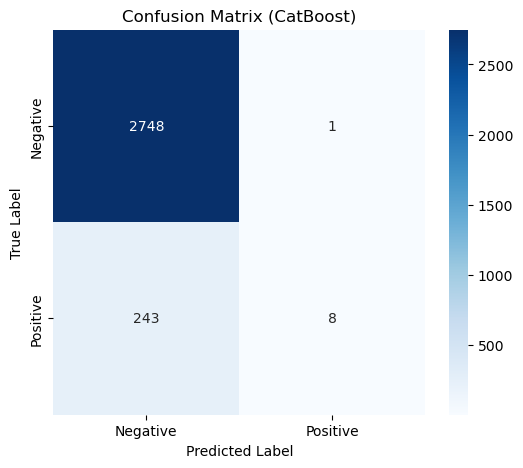

CatBoost metrics:
	ROC_AUC: 0.7813996831879467
	Accuracy: 0.9186666666666666
	Precision: 0.8888888888888888
	Recall: 0.03187250996015936
	F1-Score: 0.06153846153846154

 ################## Testing 1800 features... ################## 

Training Time: 51.5190 seconds


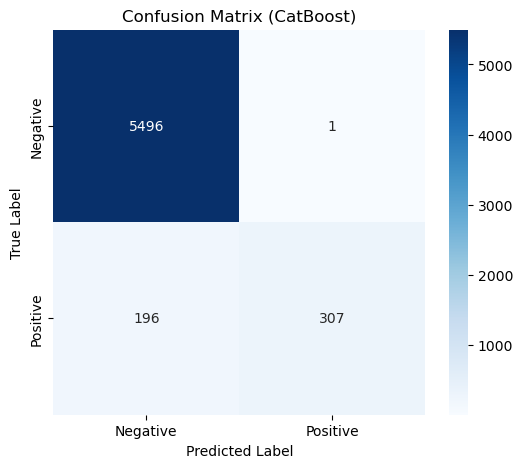

CatBoost metrics:
	ROC_AUC: 0.9933885860749636
	Accuracy: 0.9671666666666666
	Precision: 0.9967532467532467
	Recall: 0.610337972166998
	F1-Score: 0.7570900123304563


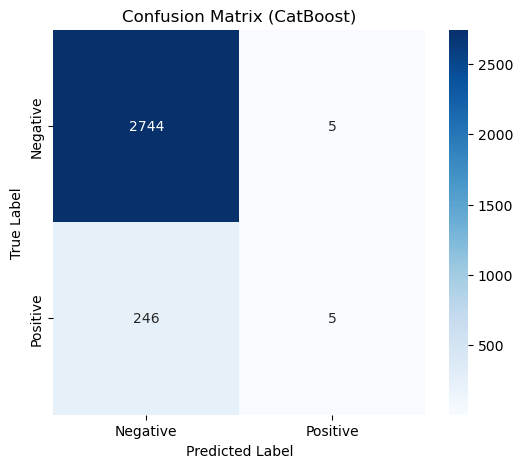

CatBoost metrics:
	ROC_AUC: 0.7833163526323952
	Accuracy: 0.9163333333333333
	Precision: 0.5
	Recall: 0.0199203187250996
	F1-Score: 0.038314176245210725

 ################## Testing 1850 features... ################## 

Training Time: 52.6438 seconds


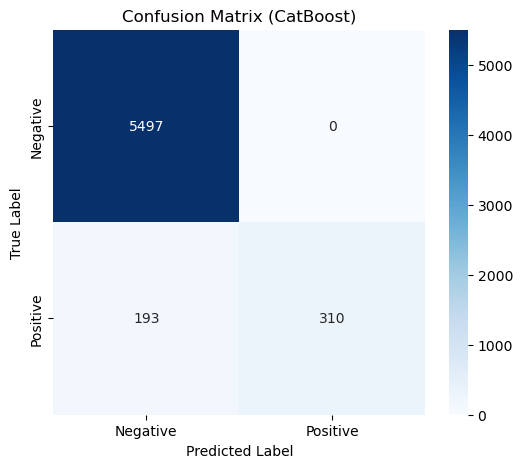

CatBoost metrics:
	ROC_AUC: 0.9934469949450107
	Accuracy: 0.9678333333333333
	Precision: 1.0
	Recall: 0.6163021868787276
	F1-Score: 0.7626076260762608


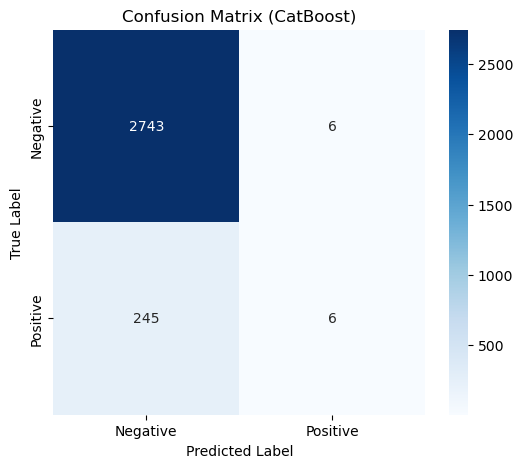

CatBoost metrics:
	ROC_AUC: 0.7846207023488441
	Accuracy: 0.9163333333333333
	Precision: 0.5
	Recall: 0.02390438247011952
	F1-Score: 0.045627376425855515

 ################## Testing 1900 features... ################## 

Training Time: 54.3423 seconds


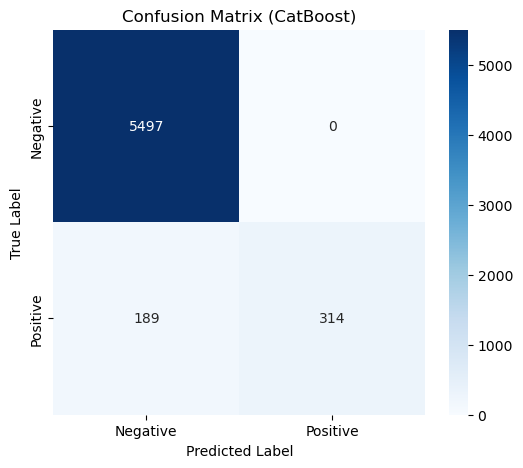

CatBoost metrics:
	ROC_AUC: 0.9934515157553858
	Accuracy: 0.9685
	Precision: 1.0
	Recall: 0.6242544731610338
	F1-Score: 0.7686658506731946


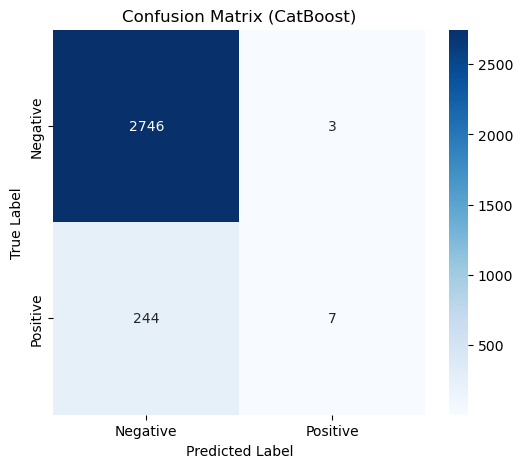

CatBoost metrics:
	ROC_AUC: 0.7790366362849801
	Accuracy: 0.9176666666666666
	Precision: 0.7
	Recall: 0.027888446215139442
	F1-Score: 0.05363984674329502

 ################## Testing 1950 features... ################## 

Training Time: 55.4608 seconds


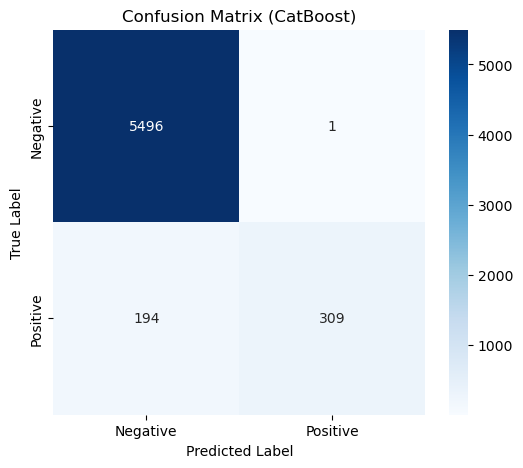

CatBoost metrics:
	ROC_AUC: 0.9928603745907311
	Accuracy: 0.9675
	Precision: 0.9967741935483871
	Recall: 0.614314115308151
	F1-Score: 0.7601476014760148


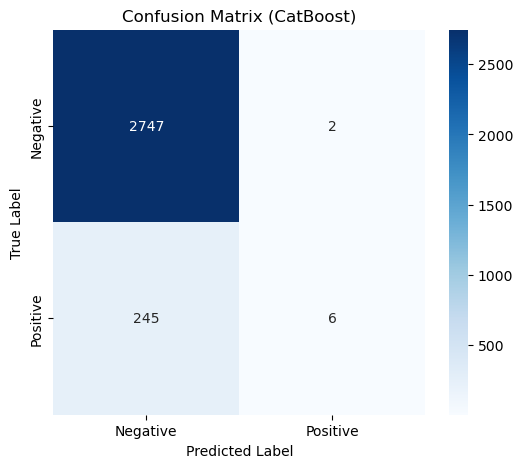

CatBoost metrics:
	ROC_AUC: 0.7877678083591425
	Accuracy: 0.9176666666666666
	Precision: 0.75
	Recall: 0.02390438247011952
	F1-Score: 0.04633204633204633

 ################## Testing 2000 features... ################## 

Training Time: 56.8105 seconds


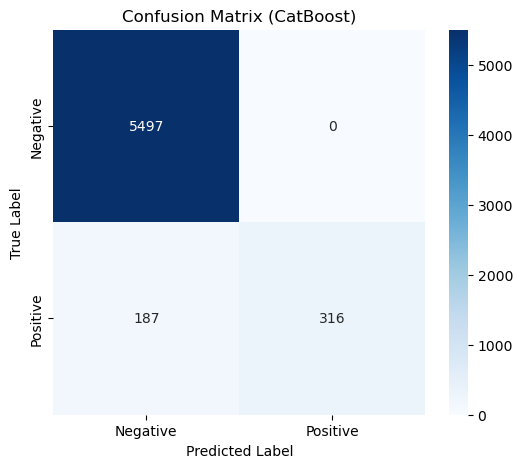

CatBoost metrics:
	ROC_AUC: 0.9935124562792429
	Accuracy: 0.9688333333333333
	Precision: 1.0
	Recall: 0.6282306163021869
	F1-Score: 0.7716727716727717


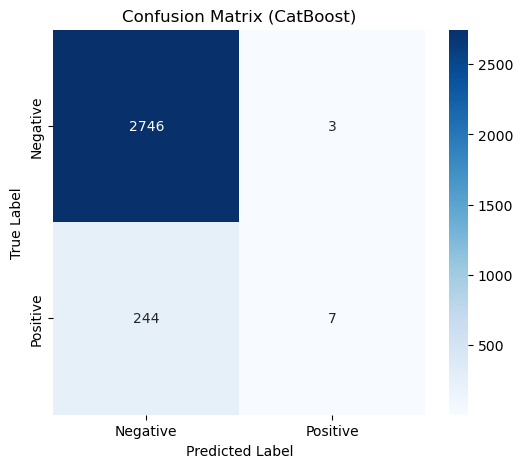

CatBoost metrics:
	ROC_AUC: 0.7790446073110251
	Accuracy: 0.9176666666666666
	Precision: 0.7
	Recall: 0.027888446215139442
	F1-Score: 0.05363984674329502

 ################## Testing 2050 features... ################## 

Training Time: 57.6846 seconds


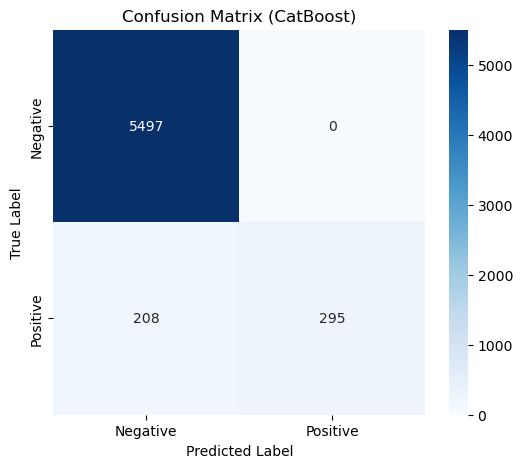

CatBoost metrics:
	ROC_AUC: 0.9920674244509295
	Accuracy: 0.9653333333333334
	Precision: 1.0
	Recall: 0.5864811133200796
	F1-Score: 0.7393483709273183


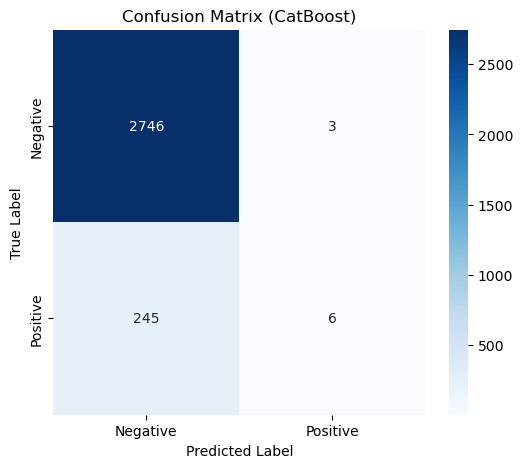

CatBoost metrics:
	ROC_AUC: 0.7788489548535578
	Accuracy: 0.9173333333333333
	Precision: 0.6666666666666666
	Recall: 0.02390438247011952
	F1-Score: 0.046153846153846156

 ################## Testing 2100 features... ################## 

Training Time: 58.0189 seconds


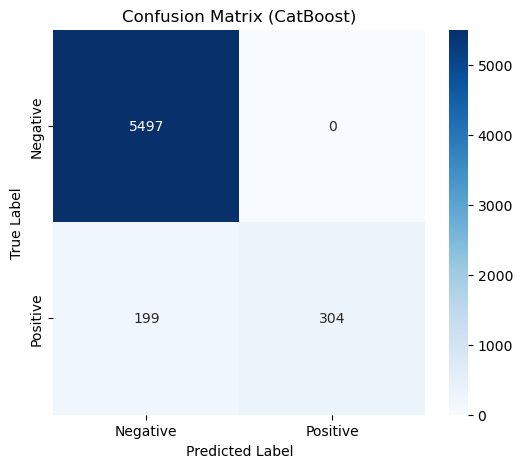

CatBoost metrics:
	ROC_AUC: 0.9926149850035677
	Accuracy: 0.9668333333333333
	Precision: 1.0
	Recall: 0.6043737574552683
	F1-Score: 0.7534076827757125


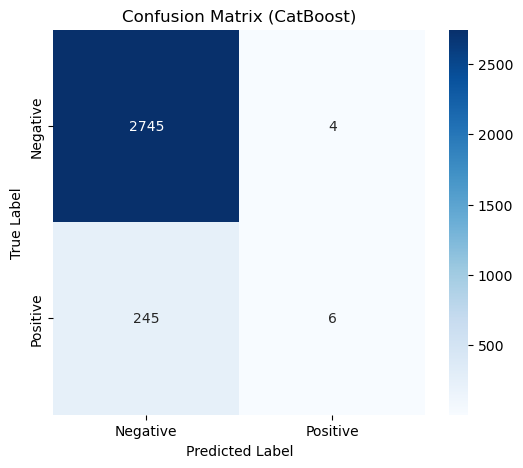

CatBoost metrics:
	ROC_AUC: 0.7847322967134734
	Accuracy: 0.917
	Precision: 0.6
	Recall: 0.02390438247011952
	F1-Score: 0.04597701149425287

 ################## Testing 2150 features... ################## 

Training Time: 59.3151 seconds


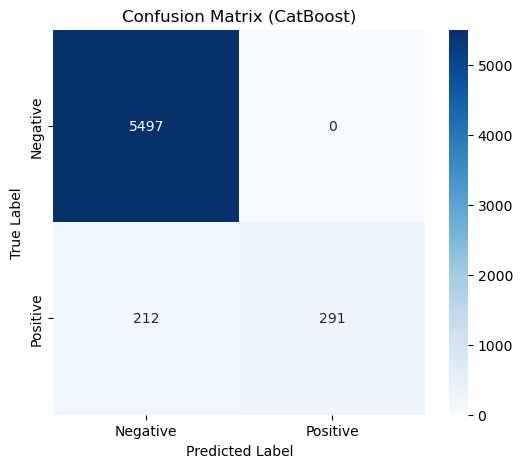

CatBoost metrics:
	ROC_AUC: 0.9925699577322313
	Accuracy: 0.9646666666666667
	Precision: 1.0
	Recall: 0.5785288270377733
	F1-Score: 0.7329974811083123


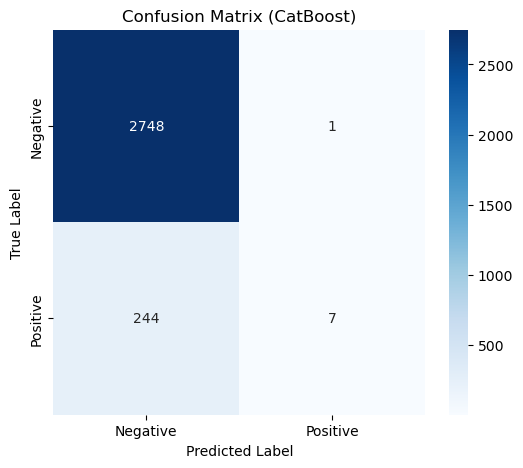

CatBoost metrics:
	ROC_AUC: 0.7780938812954802
	Accuracy: 0.9183333333333333
	Precision: 0.875
	Recall: 0.027888446215139442
	F1-Score: 0.05405405405405406

 ################## Testing 2200 features... ################## 

Training Time: 60.9379 seconds


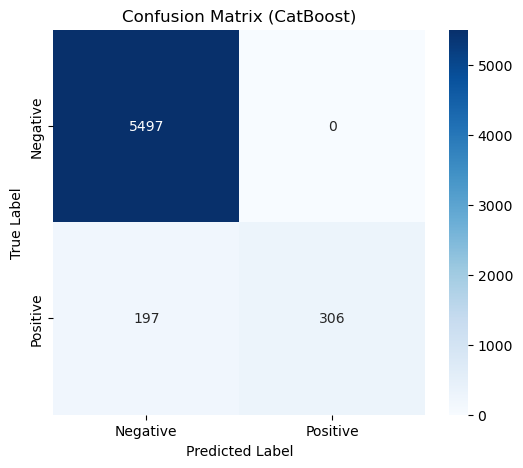

CatBoost metrics:
	ROC_AUC: 0.992469053244658
	Accuracy: 0.9671666666666666
	Precision: 1.0
	Recall: 0.6083499005964215
	F1-Score: 0.7564894932014833


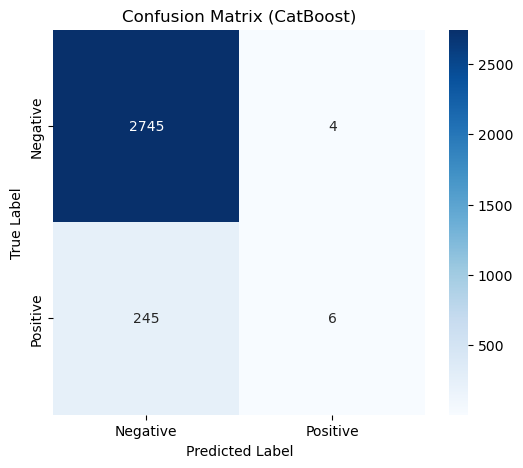

CatBoost metrics:
	ROC_AUC: 0.7854641818321474
	Accuracy: 0.917
	Precision: 0.6
	Recall: 0.02390438247011952
	F1-Score: 0.04597701149425287

 ################## Testing 2250 features... ################## 

Training Time: 62.3745 seconds


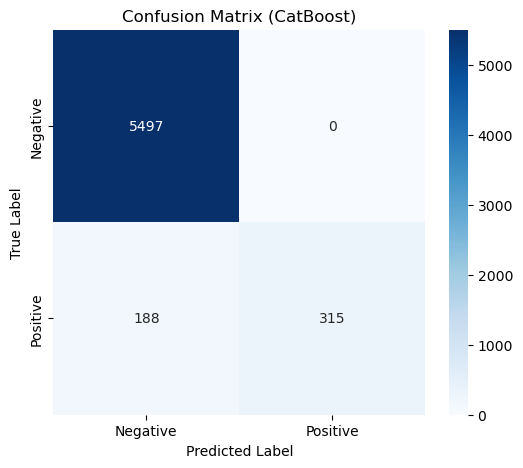

CatBoost metrics:
	ROC_AUC: 0.9937697808057964
	Accuracy: 0.9686666666666667
	Precision: 1.0
	Recall: 0.6262425447316103
	F1-Score: 0.7701711491442543


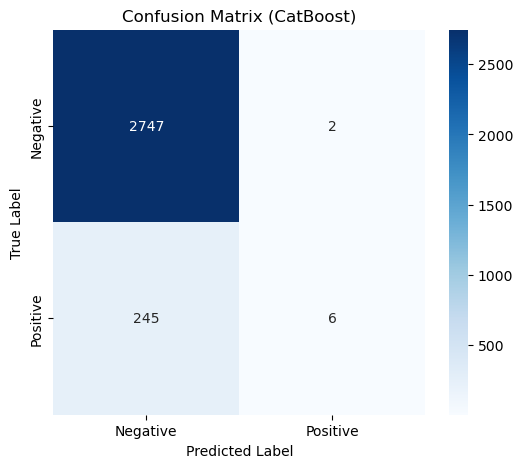

CatBoost metrics:
	ROC_AUC: 0.7813330164246616
	Accuracy: 0.9176666666666666
	Precision: 0.75
	Recall: 0.02390438247011952
	F1-Score: 0.04633204633204633

 ################## Testing 2300 features... ################## 

Training Time: 62.1032 seconds


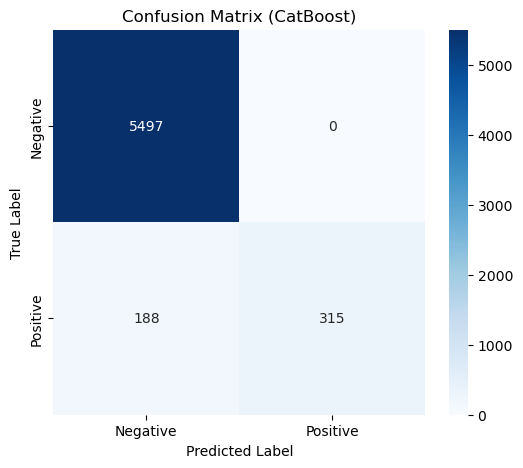

CatBoost metrics:
	ROC_AUC: 0.9937697808057964
	Accuracy: 0.9686666666666667
	Precision: 1.0
	Recall: 0.6262425447316103
	F1-Score: 0.7701711491442543


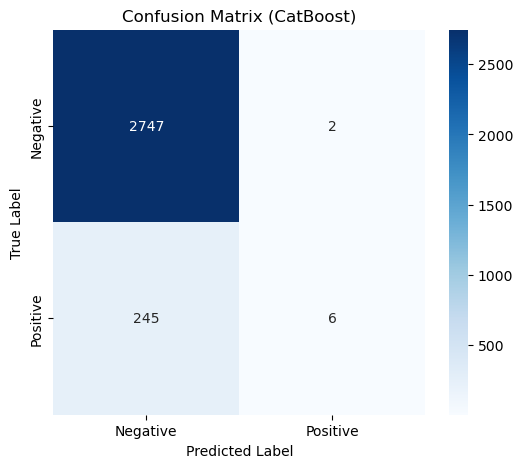

CatBoost metrics:
	ROC_AUC: 0.7813330164246616
	Accuracy: 0.9176666666666666
	Precision: 0.75
	Recall: 0.02390438247011952
	F1-Score: 0.04633204633204633

 ################## Testing 2350 features... ################## 

Training Time: 62.3336 seconds


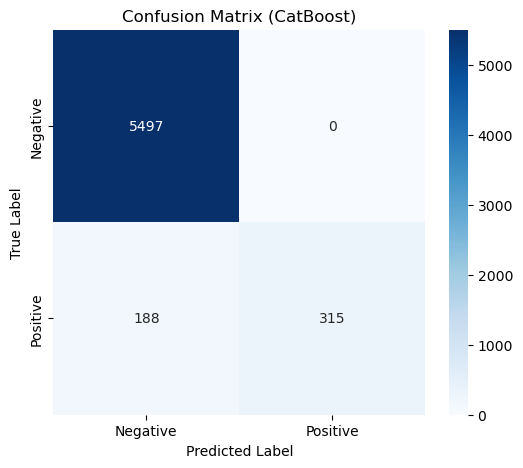

CatBoost metrics:
	ROC_AUC: 0.9937697808057964
	Accuracy: 0.9686666666666667
	Precision: 1.0
	Recall: 0.6262425447316103
	F1-Score: 0.7701711491442543


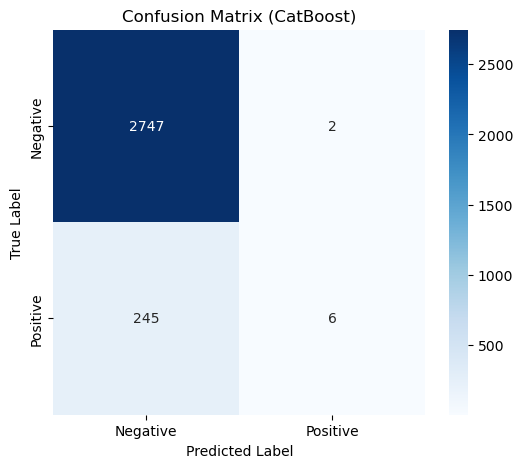

CatBoost metrics:
	ROC_AUC: 0.7813330164246616
	Accuracy: 0.9176666666666666
	Precision: 0.75
	Recall: 0.02390438247011952
	F1-Score: 0.04633204633204633

 ################## Testing 2400 features... ################## 

Training Time: 62.1521 seconds


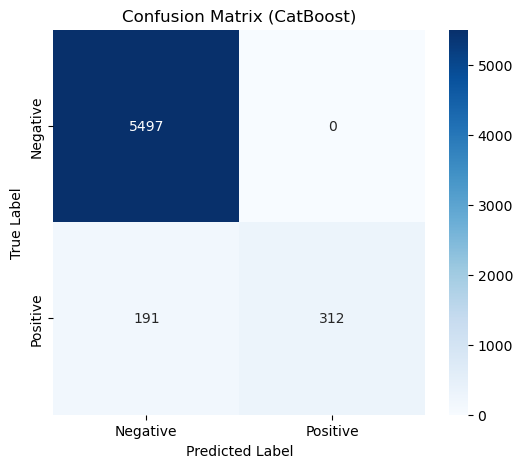

CatBoost metrics:
	ROC_AUC: 0.993035962865702
	Accuracy: 0.9681666666666666
	Precision: 1.0
	Recall: 0.6202783300198808
	F1-Score: 0.7656441717791411


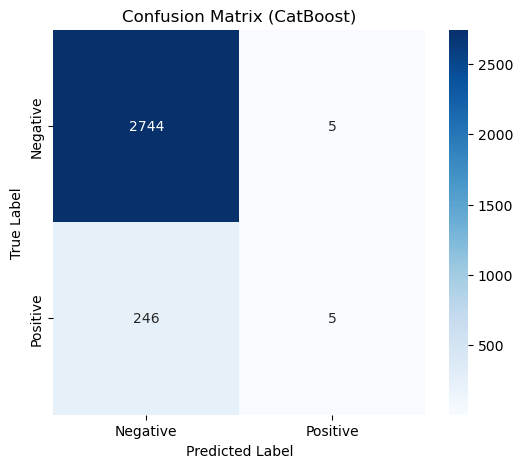

CatBoost metrics:
	ROC_AUC: 0.7857467909373781
	Accuracy: 0.9163333333333333
	Precision: 0.5
	Recall: 0.0199203187250996
	F1-Score: 0.038314176245210725

 ################## Testing 2450 features... ################## 

Training Time: 63.0317 seconds


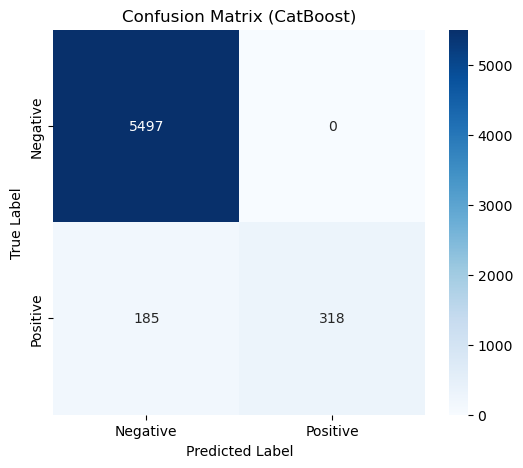

CatBoost metrics:
	ROC_AUC: 0.9938204138819982
	Accuracy: 0.9691666666666666
	Precision: 1.0
	Recall: 0.6322067594433399
	F1-Score: 0.7746650426309378


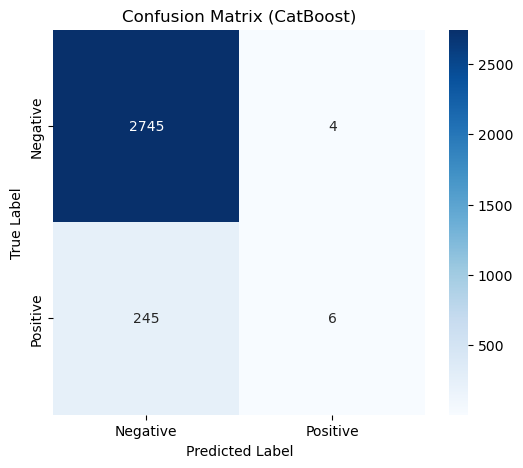

CatBoost metrics:
	ROC_AUC: 0.7840337449764418
	Accuracy: 0.917
	Precision: 0.6
	Recall: 0.02390438247011952
	F1-Score: 0.04597701149425287


In [45]:
# testing different number of features for all models (REDUNDANT)
model_types = ["CatBoost"] #["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
all_metrics = {}
roc_by_num_features = defaultdict(list)
for num_features in max_features_lst:
    print(f"\n ################## Testing {num_features} features... ################## \n")
    selected_features = select_top_features(feature_coefs, num_features, limit=np.inf) # change limit parameter to np.inf to keep redundant features
    X_train_standardized_top_features, X_val_standardized_top_features = \
        get_feature_selection_datasets(X_train_standardized, selected_features), \
        get_feature_selection_datasets(X_val_standardized, selected_features), 
    model_metrics = {}
    for model_type in model_types:
        model, metrics = train_and_evaluate(X_train_standardized_top_features, y_train, X_val_standardized_top_features, y_val, model_type=model_type)
        model_metrics[model_type] = [model, metrics]
        roc_by_num_features[model_type].append(metrics['ROC_AUC'])
    all_metrics[f"{num_features}_features"] = model_metrics

In [46]:
with open('roc_by_num_features_redundant_catboost.pkl', 'wb') as f:
    pickle.dump(roc_by_num_features, f)

In [57]:
all_metrics['500_features']

{'CatBoost': [<catboost.core.CatBoostClassifier at 0x7f6a133183d0>,
  {'ROC_AUC': 0.7841975133297294,
   'Accuracy': 0.9176666666666666,
   'Precision': 0.625,
   'Recall': 0.0398406374501992,
   'F1-Score': 0.0749063670411985}]}

In [31]:
# with open('roc_by_num_features_redundant.pkl', 'wb') as f:
#     pickle.dump(roc_by_num_features, f)

In [32]:
with open('roc_by_num_features_redundant.pkl', 'rb') as f:
    roc_by_num_features_redundant = pickle.load(f)

In [41]:
list(zip(max_features_lst, catboost_roc_lst))

[(50, 0.781943162236467),
 (100, 0.7806373632425555),
 (150, 0.7869149085723314),
 (200, 0.7996779705477834),
 (250, 0.7983199975652139),
 (300, 0.7944562238495999),
 (350, 0.7952605728414099),
 (400, 0.8015308717838722),
 (450, 0.7981779683738673),
 (500, 0.793751150363986),
 (550, 0.796961299943913),
 (600, 0.7957359358491825),
 (650, 0.796426516560169),
 (700, 0.7920975247790214),
 (750, 0.7968163721976408),
 (800, 0.7911366538212374),
 (850, 0.7853091091436365),
 (900, 0.7888931723089454),
 (950, 0.7912460742696729),
 (1000, 0.7877620112492917),
 (1050, 0.7960214435093385),
 (1100, 0.7876279530839901),
 (1150, 0.7949786883749106),
 (1200, 0.7893837527300763),
 (1250, 0.7878917215822052),
 (1300, 0.7941953539063099),
 (1350, 0.7905482471713726),
 (1400, 0.7868634592224046),
 (1450, 0.7816185240848176),
 (1500, 0.7882018669592276),
 (1550, 0.78365983139106),
 (1600, 0.7931786857662112),
 (1650, 0.7851547610938566),
 (1700, 0.7912308568563142),
 (1750, 0.7928417287561286),
 (1800, 0.7

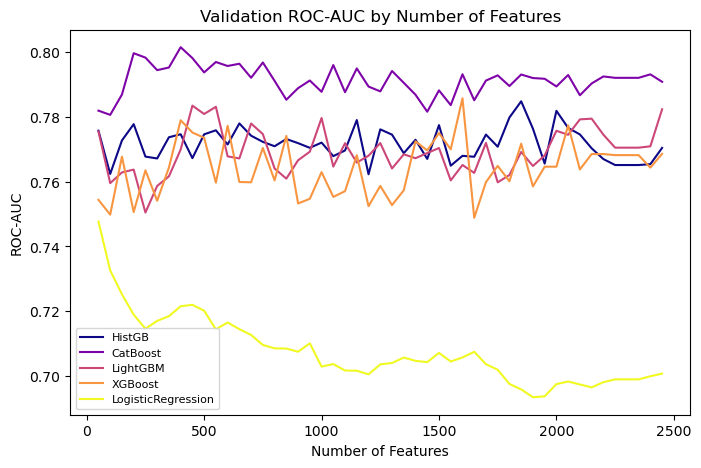

In [36]:
# plotting roc auc for all models across number of features
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]

plt.figure(figsize=(8, 5))
colors = cm.plasma(np.linspace(0, 1, len(model_types)))  # Use 'viridis', or try 'plasma', 'coolwarm', etc.
for i, model_type in enumerate(model_types):
    plt.plot(max_features_lst, roc_by_num_features_redundant[model_type], label=model_type, linestyle="-", color=colors[i])
plt.legend()
plt.title("Validation ROC-AUC by Number of Features")
plt.xlabel("Number of Features")
plt.ylabel("ROC-AUC")
plt.legend(fontsize=8, loc="lower left")  
plt.savefig("roc_by_num_features.png", dpi=300, bbox_inches='tight') 
plt.show()

In [ ]:
"""
RUN BELOW CELL -- TEST DIFFERENT NUMBER OF FEATURES WITH CATEGORY LIMIT FOR ALL MODELS
"""

In [71]:
# this is actually with 205 features, due to the category limit (even though I set max_features to 2050, category limit set it to 205)
# CATBOOST ROC_AUC: 0.7682347623668585
	# Accuracy: 0.9143333333333333
	# Precision: 0.4
	# Recall: 0.03968253968253968

# ACTUALLY ALL 2050 FEATURES THIS TIME
# CATBOOST ROC_AUC: 0.7830276275964049
# 	Accuracy: 0.9153333333333333
# 	Precision: 0.42857142857142855
# 	Recall: 0.023809523809523808
# 	F1-Score: 0.045112781954887216

In [81]:
selected_features = select_top_features(feature_coefs, num_features, limit=3)

2050

Testing 2050 features...
Training Time: 5.5350 seconds


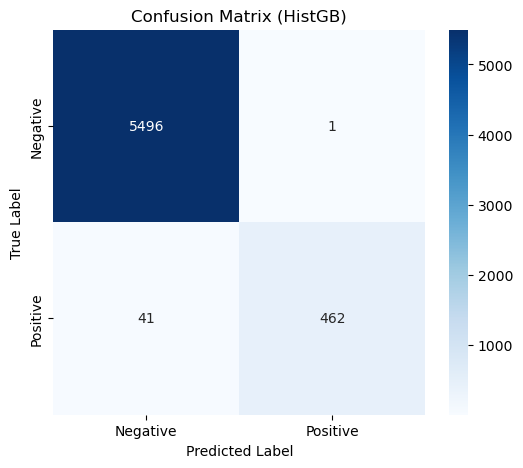

HistGB metrics:
	ROC_AUC: 0.99940506135463
	Accuracy: 0.993
	Precision: 0.9978401727861771
	Recall: 0.9184890656063618
	F1-Score: 0.9565217391304348


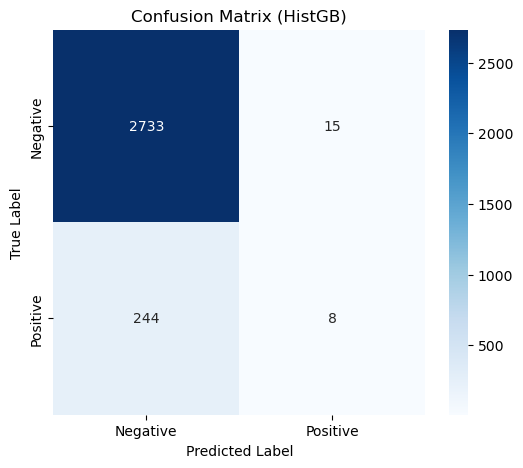

HistGB metrics:
	ROC_AUC: 0.7648722880709781
	Accuracy: 0.9136666666666666
	Precision: 0.34782608695652173
	Recall: 0.031746031746031744
	F1-Score: 0.05818181818181818
Training Time: 58.6965 seconds


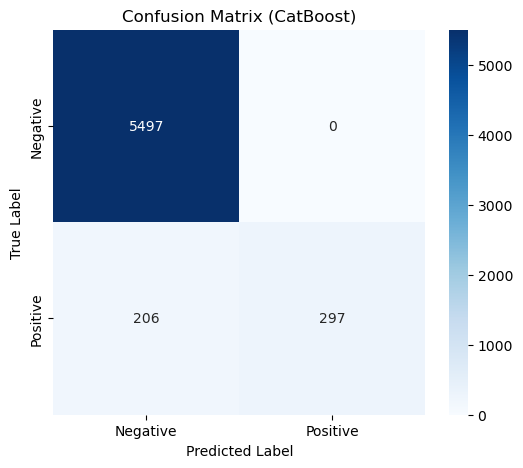

CatBoost metrics:
	ROC_AUC: 0.9918529572067322
	Accuracy: 0.9656666666666667
	Precision: 1.0
	Recall: 0.5904572564612326
	F1-Score: 0.7425


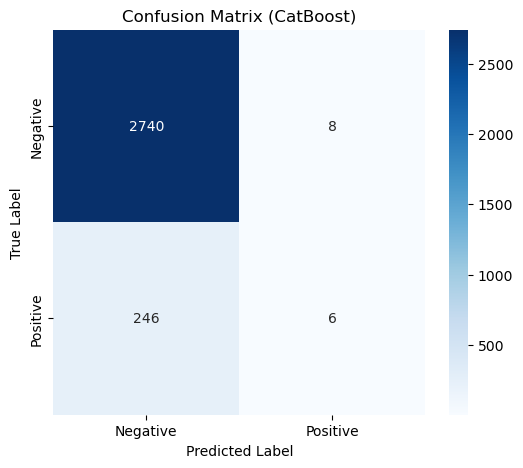

CatBoost metrics:
	ROC_AUC: 0.7830276275964049
	Accuracy: 0.9153333333333333
	Precision: 0.42857142857142855
	Recall: 0.023809523809523808
	F1-Score: 0.045112781954887216
[LightGBM] [Info] Number of positive: 503, number of negative: 5497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 358035
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 1912
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.083833 -> initscore=-2.391368
[LightGBM] [Info] Start training from score -2.391368
Training Time: 4.2976 seconds


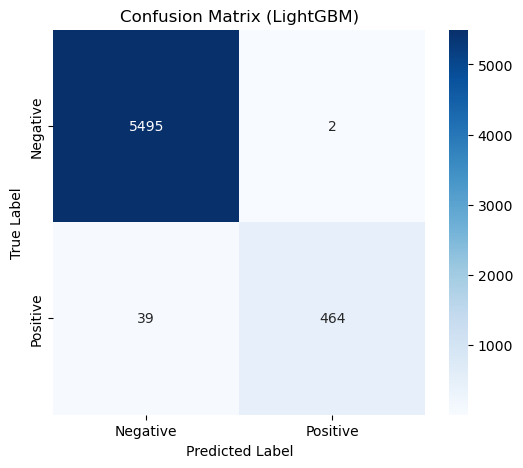

LightGBM metrics:
	ROC_AUC: 0.9994443019886864
	Accuracy: 0.9931666666666666
	Precision: 0.9957081545064378
	Recall: 0.9224652087475149
	F1-Score: 0.957688338493292


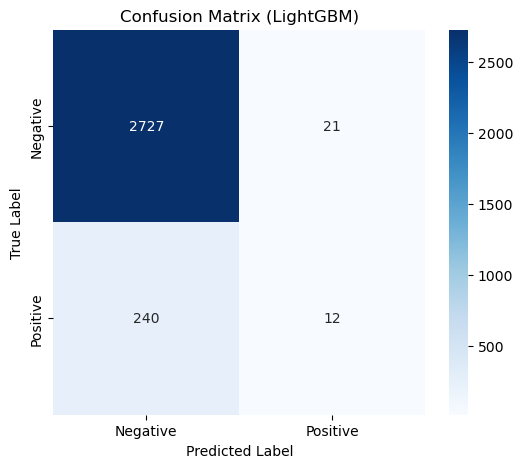

LightGBM metrics:
	ROC_AUC: 0.7688744772532983
	Accuracy: 0.913
	Precision: 0.36363636363636365
	Recall: 0.047619047619047616
	F1-Score: 0.08421052631578947


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [00:23:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 8.3010 seconds


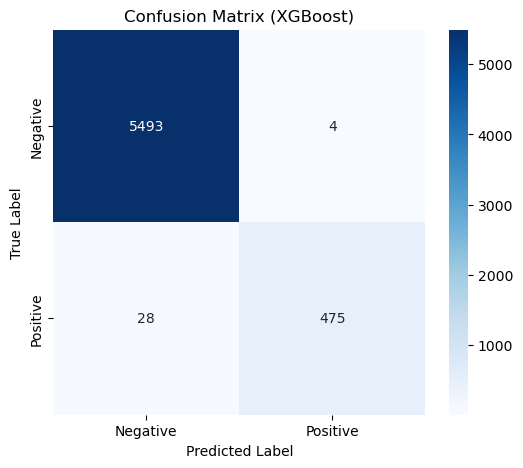

XGBoost metrics:
	ROC_AUC: 0.9996314635382177
	Accuracy: 0.9946666666666667
	Precision: 0.9916492693110647
	Recall: 0.9443339960238568
	F1-Score: 0.9674134419551935


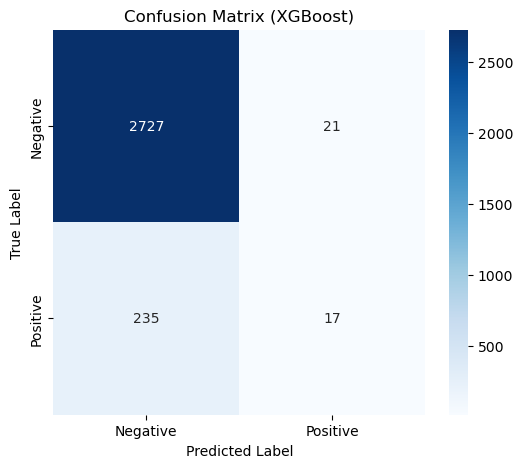

XGBoost metrics:
	ROC_AUC: 0.7587776680298515
	Accuracy: 0.9146666666666666
	Precision: 0.4473684210526316
	Recall: 0.06746031746031746
	F1-Score: 0.11724137931034483
Training Time: 3.3613 seconds


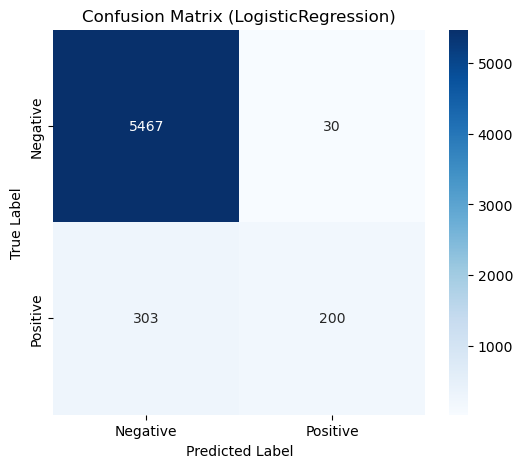

LogisticRegression metrics:
	ROC_AUC: 0.9472025406230978
	Accuracy: 0.9445
	Precision: 0.8695652173913043
	Recall: 0.3976143141153082
	F1-Score: 0.5457025920873124


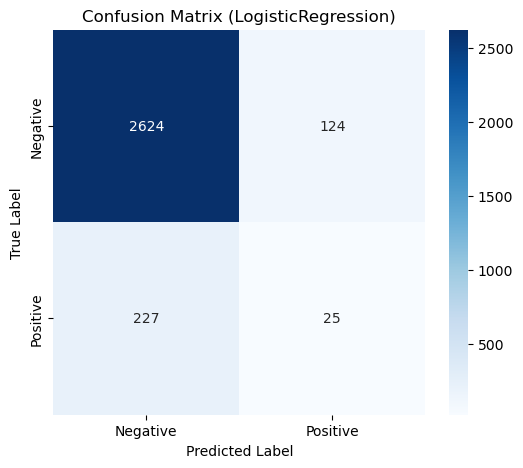

LogisticRegression metrics:
	ROC_AUC: 0.6770753910491901
	Accuracy: 0.883
	Precision: 0.16778523489932887
	Recall: 0.0992063492063492
	F1-Score: 0.12468827930174564


In [82]:
# testing different number of features for all models (CATEGORY LIMIT)
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
all_metrics_limit = {}
roc_by_num_features_limit = defaultdict(list)
for num_features in [2050]: #max_features_lst:
    print(f"Testing {num_features} features...")
    feature_coefs = get_lasso_features(X_train_standardized, y_train) 
    selected_features = select_top_features(feature_coefs, num_features, limit=3) # change limit parameter to np.inf to keep redundant features
    X_train_standardized_top_features, X_val_standardized_top_features = \
        get_feature_selection_datasets(X_train_standardized, selected_features), \
        get_feature_selection_datasets(X_val_standardized, selected_features), 
    model_metrics = {}
    for model_type in model_types:
        model, metrics = train_and_evaluate(X_train_standardized_top_features, y_train, X_val_standardized_top_features, y_val, model_type=model_type)
        model_metrics[model_type] = [model, metrics]
        roc_by_num_features_limit[model_type].append(metrics['ROC_AUC'])
    all_metrics_limit[f"{num_features}_features"] = model_metrics

In [84]:
# with open('roc_by_num_features_limit.pkl', 'wb') as f:
#     pickle.dump(roc_by_num_features_limit, f)

In [85]:
# with open('roc_by_num_features_limit.pkl', 'rb') as f:
#     roc_by_num_features_limit = pickle.load(f)

In [43]:
### getting roc auc metrics across num_features kept ###

##### Baseline Feature Selection Models

In [ ]:
model, metrics = train_and_evaluate(X_train_standardized, y_train, X_val_standardized, y_val, model_type='CatBoost')

In [124]:
feature_coefs = get_lasso_features(X_train_standardized, y_train) 
selected_features = select_top_features(feature_coefs, 200, limit=np.inf) # change limit parameter to np.inf to keep redundant features

In [117]:
X_train_standardized_top_50, X_test_standardized_top_50 = \
    get_feature_selection_datasets(X_train_standardized, selected_features), \
    get_feature_selection_datasets(X_test_standardized, selected_features), 

In [118]:
# fit with top 50 features
model_top_50 = fit_model(X_train_standardized_top_50, y_train, model_type='log_reg')

In [119]:
# predict on train set with top 50 features
y_pred_train_standardized_top_50, y_pred_proba_train_standardized_top_50 = predict(X_train_standardized_top_50, y_train, model_top_50)
y_pred_proba_train_standardized_top_50 = y_pred_proba_train_standardized_top_50[:, 1]

# predict on test set with top 50 features
y_pred_test_standardized_top_50, y_pred_proba_test_standardized_top_50 = predict(X_test_standardized_top_50, y_test, model_top_50)
y_pred_proba_test_standardized_top_50 = y_pred_proba_test_standardized_top_50[:, 1]

In [120]:
# train metrics
evaluate_model(y_train, y_pred_train_standardized_top_50, y_pred_proba_train_standardized_top_50)

ROC AUC Score: 0.8001
Accuracy: 0.9183

Confusion Matrix:
[[8213   33]
 [ 702   52]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      8246
         1.0       0.61      0.07      0.12       754

    accuracy                           0.92      9000
   macro avg       0.77      0.53      0.54      9000
weighted avg       0.90      0.92      0.89      9000



In [121]:
# top 50 features with redundancy: 

# ROC AUC Score: 0.7670
# Accuracy: 0.9170

# Confusion Matrix:
# [[8786   16]
#  [ 781   17]]

# Classification Report:
#               precision    recall  f1-score   support

#          0.0       0.92      1.00      0.96      8802
#          1.0       0.52      0.02      0.04       798

#     accuracy                           0.92      9600
#    macro avg       0.72      0.51      0.50      9600
# weighted avg       0.88      0.92      0.88      9600

In [122]:
# test metrics
evaluate_model(y_test, y_pred_test_standardized_top_50, y_pred_proba_test_standardized_top_50)

ROC AUC Score: 0.7063
Accuracy: 0.9083

Confusion Matrix:
[[2720   28]
 [ 247    5]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95      2748
         1.0       0.15      0.02      0.04       252

    accuracy                           0.91      3000
   macro avg       0.53      0.50      0.49      3000
weighted avg       0.85      0.91      0.87      3000



In [98]:
# top 50 features with redundancy: 

# ROC AUC Score: 0.7176
# Accuracy: 0.9121

# Confusion Matrix:
# [[2186    6]
#  [ 205    3]]

# Classification Report:
#               precision    recall  f1-score   support

#          0.0       0.91      1.00      0.95      2192
#          1.0       0.33      0.01      0.03       208

#     accuracy                           0.91      2400
#    macro avg       0.62      0.51      0.49      2400
# weighted avg       0.86      0.91      0.87      2400

##### Point Biserial Correlation

In [76]:
# use features with highest point biserial correlation
point_biserial_features = [(feature, pointbiserialr(X_train[feature], y_train).statistic) for feature in X_train.columns]
point_biserial_features.sort(key=lambda x: abs(x[1]), reverse=True)
top_50_features_pb = [feature[0] for feature in point_biserial_features[:50]]

/opt/conda/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


In [77]:
# grab top 50 features by point biseral corr
X_train_standardized_top_50_pb = X_train_standardized[top_50_features_pb]
X_test_standardized_top_50_pb = X_test_standardized[top_50_features_pb]

In [78]:
# fit with top 50 features
model_top_50_pb = fit_model(X_train_standardized_top_50_pb, y_train, model_type='log_reg')

In [79]:
# predict on train set with top 50 features
%time y_pred_train_standardized_top_50_pb, y_pred_proba_train_standardized_top_50_pb = predict(X_train_standardized_top_50_pb, y_train, model_top_50_pb)
y_pred_proba_train_standardized_top_50_pb = y_pred_proba_train_standardized_top_50_pb[:, 1]

CPU times: user 6.89 ms, sys: 42 µs, total: 6.93 ms
Wall time: 5.07 ms


In [80]:
# train metrics
evaluate_model(y_train, y_pred_train_standardized_top_50_pb, y_pred_proba_train_standardized_top_50_pb)

ROC AUC Score: 0.7180
Accuracy: 0.9165

Confusion Matrix:
[[8793    9]
 [ 793    5]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      8802
         1.0       0.36      0.01      0.01       798

    accuracy                           0.92      9600
   macro avg       0.64      0.50      0.48      9600
weighted avg       0.87      0.92      0.88      9600



In [81]:
# predict on test set with top 50 features
%time y_pred_test_standardized_top_50_pb, y_pred_proba_test_standardized_top_50_pb = predict(X_test_standardized_top_50_pb, y_test, model_top_50_pb)
y_pred_proba_test_standardized_top_50_pb = y_pred_proba_test_standardized_top_50_pb[:, 1]

CPU times: user 0 ns, sys: 4.9 ms, total: 4.9 ms
Wall time: 3.44 ms


In [82]:
# test metrics
evaluate_model(y_test, y_pred_test_standardized_top_50_pb, y_pred_proba_test_standardized_top_50_pb)

ROC AUC Score: 0.6881
Accuracy: 0.9133

Confusion Matrix:
[[2191    1]
 [ 207    1]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      2192
         1.0       0.50      0.00      0.01       208

    accuracy                           0.91      2400
   macro avg       0.71      0.50      0.48      2400
weighted avg       0.88      0.91      0.87      2400



##### Top 50 Feature Plots

In [84]:
final_features_dq_0 = final_features_df[final_features_df['DQ_TARGET'] == 0]
final_features_dq_1 = final_features_df[final_features_df['DQ_TARGET'] == 1]

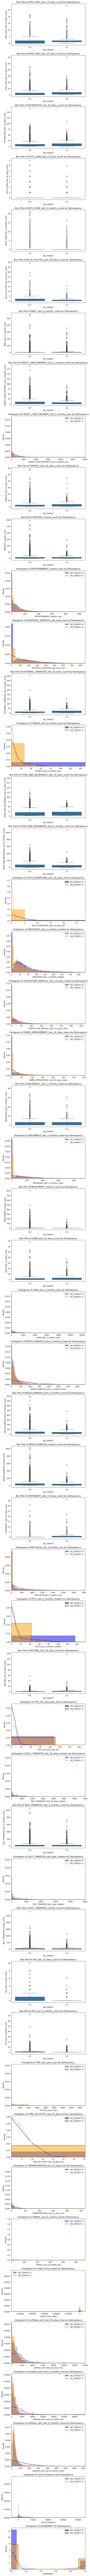

In [88]:
top_features_subset = top_50_features_l1
fig, axes = plt.subplots(len(top_features_subset), 1, figsize=(7, len(top_features_subset) * 4))

for i, feature in enumerate(top_features_subset):
    x_min, x_max = np.percentile(final_features_df[feature], [0,99])
    if 'count' in feature:
        sns.boxplot(final_features_df, x='DQ_TARGET', y=feature, ax=axes[i])
        axes[i].set_title(f"Box Plot of {feature} by Delinquency")
    else:
        sns.histplot(final_features_dq_0[feature], label='DQ_TARGET=0', stat='density', kde=True, ax=axes[i], color='blue', alpha=0.5)
        sns.histplot(final_features_dq_1[feature], label='DQ_TARGET=1', stat='density', kde=True, ax=axes[i], color='orange', alpha=0.5)
        axes[i].legend()
        axes[i].set_xlim(x_min, x_max)
        axes[i].set_title(f"Histogram of {feature} by Delinquency")

plt.tight_layout()
plt.show()

In [ ]:
top_features_subset = top_50_features_pb
fig, axes = plt.subplots(len(top_features_subset), 1, figsize=(7, len(top_features_subset) * 4))

for i, feature in enumerate(top_features_subset):
    x_min, x_max = np.percentile(final_features_df[feature], [0,99])
    if 'count' in feature:
        sns.boxplot(final_features_df, x='DQ_TARGET', y=feature, ax=axes[i])
        axes[i].set_title(f"Box Plot of {feature} by Delinquency")
    else:
        sns.histplot(final_features_dq_0[feature], label='DQ_TARGET=0', stat='density', kde=True, ax=axes[i], color='blue', alpha=0.5)
        sns.histplot(final_features_dq_1[feature], label='DQ_TARGET=1', stat='density', kde=True, ax=axes[i], color='orange', alpha=0.5)
        axes[i].legend()
        axes[i].set_xlim(x_min, x_max)
        axes[i].set_title(f"Histogram of {feature} by Delinquency")

plt.tight_layout()
plt.show()

#### Multiple Model Training

In [37]:
# testing models with all standardized features
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(X_train_standardized, y_train, X_test_standardized, y_test, model_type=model_type)
    model_metrics[model_type] = [model, metrics]

In [39]:
# testing models with l1 top 50 standardized features
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(X_train_standardized_top_50_l1, y_train, X_test_standardized_top_50_l1, y_test, model_type=model_type)
    model_metrics[model_type] = [model, metrics]

In [ ]:
# gambling not in my top features, should inspect that

## Week 6

#### SMOTE

In [ ]:
# !pip install imbalanced-learn

In [41]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN

In [42]:
def resample_data(X, y, new_0=0.75, new_1=0.25):
    # Check class counts
    new_0 = int(new_0 * len(y))  # Target count for balancing
    new_1 = int(new_1 * len(y))
    
    # Ensure SMOTE does not create more than the original number of samples
    smote = SMOTE(sampling_strategy={1: new_1},)
    
    # Undersampling the majority class to match the new minority class count
    under = RandomUnderSampler(sampling_strategy={0: new_0},)

    smoteenn = SMOTEENN(sampling_strategy={1: new_1,})
    
    # Combine SMOTE & Undersampling in a pipeline
    resample_pipeline = Pipeline(steps=[('smote', smote), ('under', under)])
    
    X_resampled, y_resampled = resample_pipeline.fit_resample(X, y)

    X_resampled = X_resampled[X.columns]
    cols_dtype_object = X_resampled.dtypes[X_resampled.dtypes == 'object'].index
    X_resampled[cols_dtype_object] = X_resampled[cols_dtype_object].astype(float)

    return X_resampled, y_resampled

In [48]:
selected_features = select_top_features(feature_coefs, 500, limit=np.inf) # chang e limit parameter to np.inf to keep redundant features
X_train_standardized_top_features, X_val_standardized_top_features = \
    get_feature_selection_datasets(X_train_standardized, selected_features), \
    get_feature_selection_datasets(X_val_standardized, selected_features), 

In [49]:
X_train_resampled, y_train_resampled = resample_data(X_train_standardized, y_train)

In [50]:
X_val_resampled, y_val_resampled = resample_data(X_val_standardized, y_val)

In [32]:
def get_metrics(X, y, model, model_type):
    # Predict on training data
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1] if hasattr(model, "predict_proba") else y_pred

    # Evaluation Metrics
    metrics = {
        "ROC_AUC": roc_auc_score(y, y_prob),
        "Accuracy": accuracy_score(y, y_pred),
        "Precision": precision_score(y, y_pred),
        "Recall": recall_score(y, y_pred),
        "F1-Score": f1_score(y, y_pred),
        # "Confusion Matrix": confusion_matrix(y, y_pred)
    }

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix ({model_type})")
    plt.show()

    # Print Metrics
    print(f'{model_type} metrics:')
    for metric, value in metrics.items():
        print(f"\t{metric}: {value}")

    return metrics

In [75]:
# catboost_500 = all_metrics['500_features']['CatBoost'][0]

Training Time: 68.3330 seconds


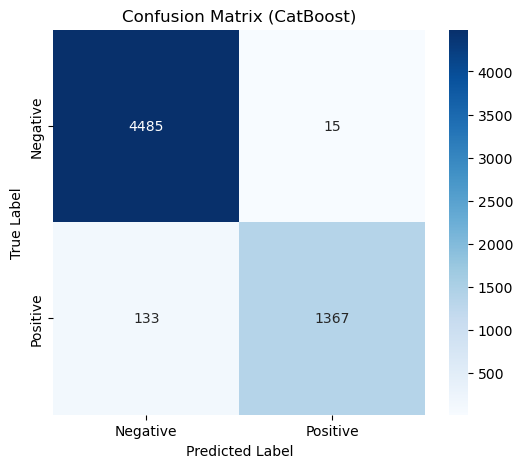

CatBoost metrics:
	ROC_AUC: 0.9987788148148149
	Accuracy: 0.9753333333333334
	Precision: 0.9891461649782923
	Recall: 0.9113333333333333
	F1-Score: 0.9486467730742539


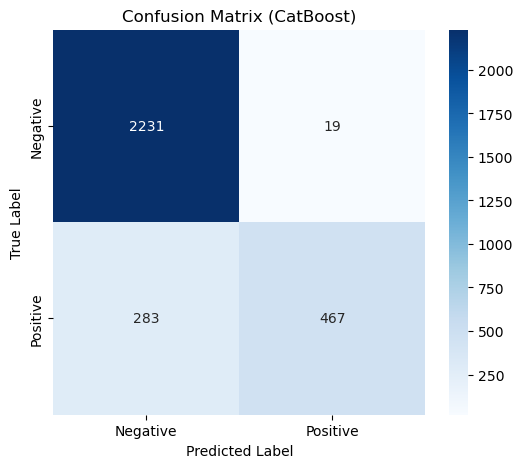

CatBoost metrics:
	ROC_AUC: 0.9201339259259259
	Accuracy: 0.8993333333333333
	Precision: 0.9609053497942387
	Recall: 0.6226666666666667
	F1-Score: 0.7556634304207119


In [76]:
# catboost trained and validated on SMOTE with 500 features
catboost_smote_500, catboost_smote_500_metrics = train_and_evaluate(
    X_train_resampled, y_train_resampled, X_val_resampled, y_val_resampled, model_type='CatBoost'
)

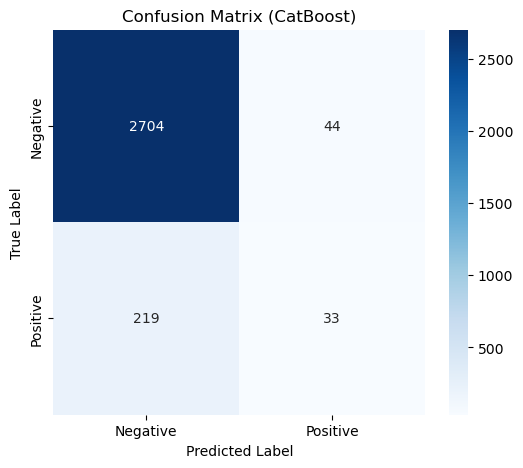

CatBoost metrics:
	ROC_AUC: 0.759007994270003
	Accuracy: 0.9123333333333333
	Precision: 0.42857142857142855
	Recall: 0.13095238095238096
	F1-Score: 0.2006079027355623


In [77]:
# catboost smote 500 test metrics
_ = get_metrics(X_test_standardized, y_test, catboost_smote_500, 'CatBoost')

Training Time: 67.4564 seconds


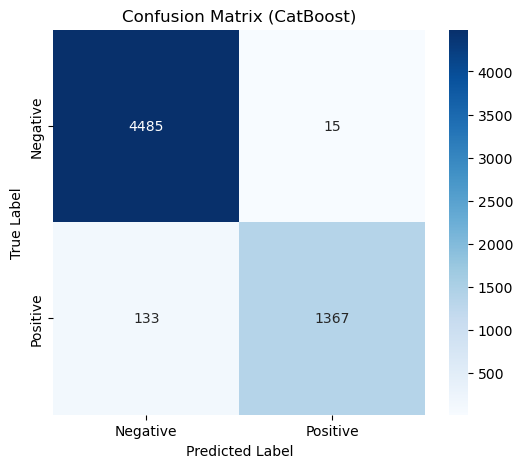

CatBoost metrics:
	ROC_AUC: 0.9987788148148149
	Accuracy: 0.9753333333333334
	Precision: 0.9891461649782923
	Recall: 0.9113333333333333
	F1-Score: 0.9486467730742539


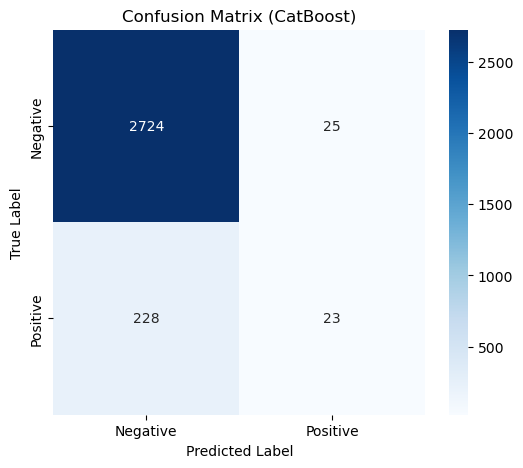

CatBoost metrics:
	ROC_AUC: 0.7765069224738007
	Accuracy: 0.9156666666666666
	Precision: 0.4791666666666667
	Recall: 0.09163346613545817
	F1-Score: 0.15384615384615385


In [78]:
# catboost trained on SMOTE with 500 features, regular validation
catboost_smote_500_reg_val, catboost_smote_500_reg_val_metrics = train_and_evaluate(
    X_train_resampled, y_train_resampled, X_val_standardized, y_val, model_type='CatBoost'
)

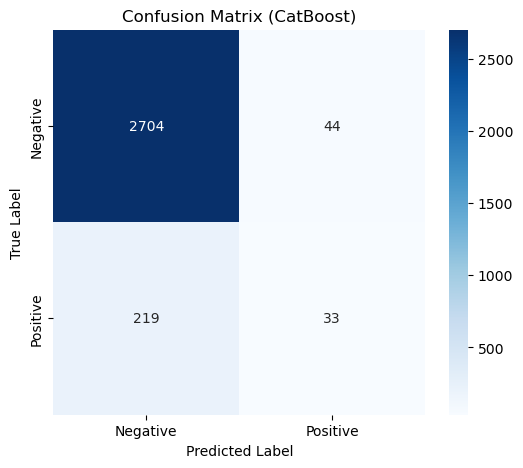

CatBoost metrics:
	ROC_AUC: 0.759007994270003
	Accuracy: 0.9123333333333333
	Precision: 0.42857142857142855
	Recall: 0.13095238095238096
	F1-Score: 0.2006079027355623


In [82]:
# catboost smote 500 regular validation test metrics
_ = get_metrics(X_test_standardized, y_test, catboost_smote_500_reg_val, 'CatBoost')

**Having SMOTE validation vs regular validation makes no difference on test performance**

Training Time: 6.1775 seconds


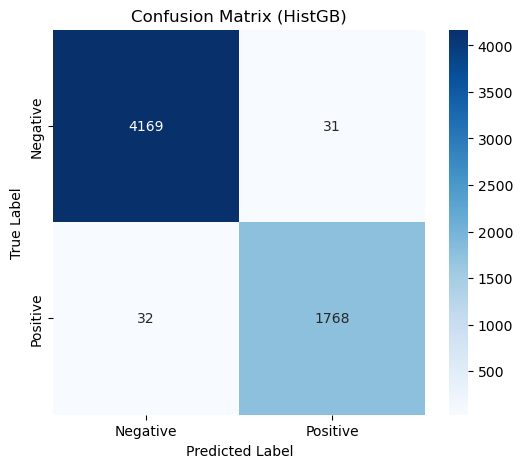

HistGB metrics:
	ROC_AUC: 0.9995073412698413
	Accuracy: 0.9895
	Precision: 0.9827682045580878
	Recall: 0.9822222222222222
	F1-Score: 0.982495137538205


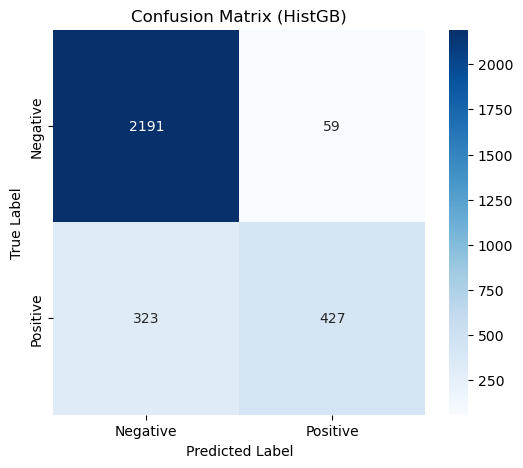

HistGB metrics:
	ROC_AUC: 0.9067315555555556
	Accuracy: 0.8726666666666667
	Precision: 0.8786008230452675
	Recall: 0.5693333333333334
	F1-Score: 0.6909385113268608
Training Time: 64.0651 seconds


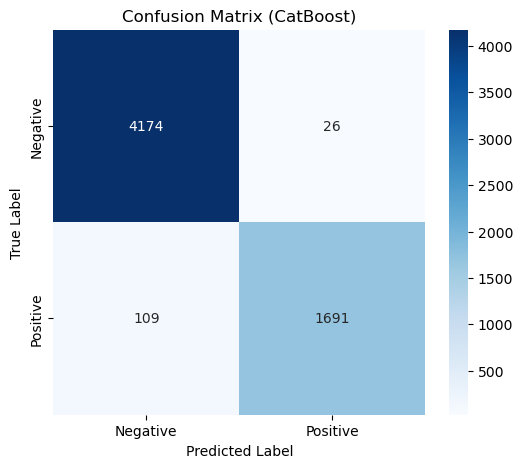

CatBoost metrics:
	ROC_AUC: 0.9982267857142857
	Accuracy: 0.9775
	Precision: 0.9848573092603378
	Recall: 0.9394444444444444
	F1-Score: 0.9616150127949957


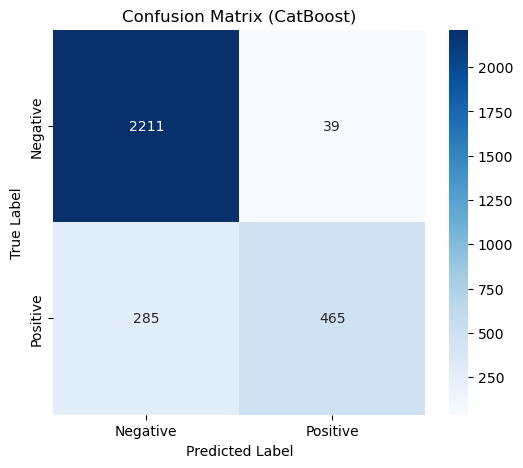

CatBoost metrics:
	ROC_AUC: 0.9171288888888889
	Accuracy: 0.892
	Precision: 0.9226190476190477
	Recall: 0.62
	F1-Score: 0.7416267942583732
[LightGBM] [Info] Number of positive: 1800, number of negative: 4200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 408450
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 1924
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training from score -0.847298
Training Time: 4.8421 seconds


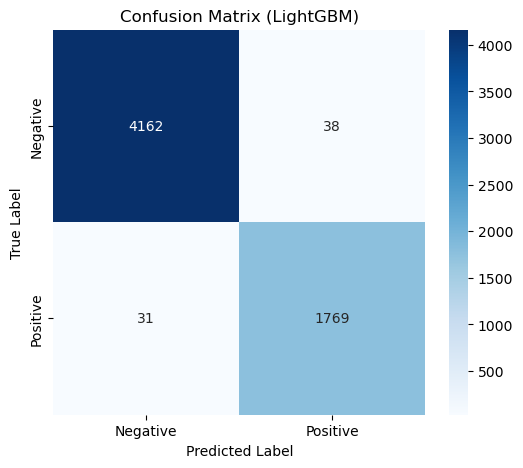

LightGBM metrics:
	ROC_AUC: 0.999559126984127
	Accuracy: 0.9885
	Precision: 0.9789706696181516
	Recall: 0.9827777777777778
	F1-Score: 0.9808705295259218


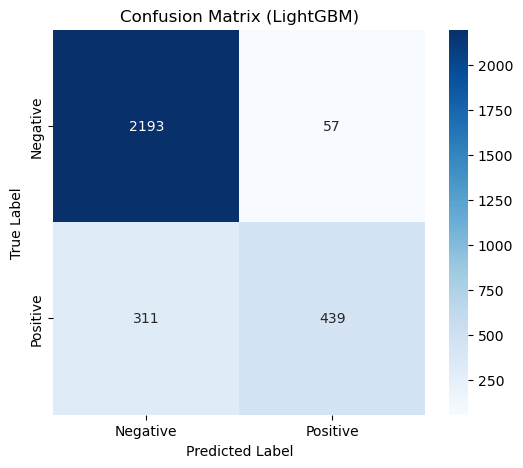

LightGBM metrics:
	ROC_AUC: 0.9073244444444444
	Accuracy: 0.8773333333333333
	Precision: 0.8850806451612904
	Recall: 0.5853333333333334
	F1-Score: 0.7046548956661316


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [01:45:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 7.1542 seconds


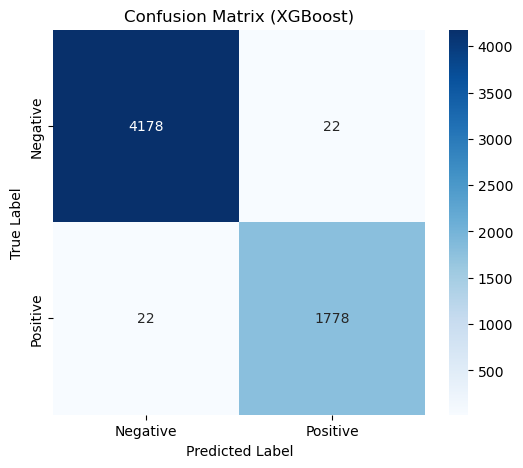

XGBoost metrics:
	ROC_AUC: 0.9997805555555556
	Accuracy: 0.9926666666666667
	Precision: 0.9877777777777778
	Recall: 0.9877777777777778
	F1-Score: 0.9877777777777778


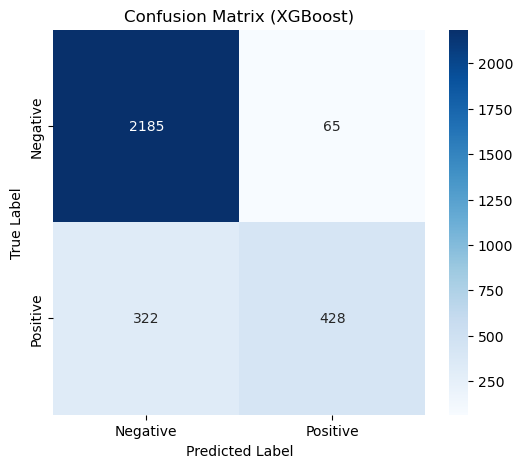

XGBoost metrics:
	ROC_AUC: 0.9006708148148148
	Accuracy: 0.871
	Precision: 0.8681541582150102
	Recall: 0.5706666666666667
	F1-Score: 0.6886564762670957
Training Time: 5.5490 seconds


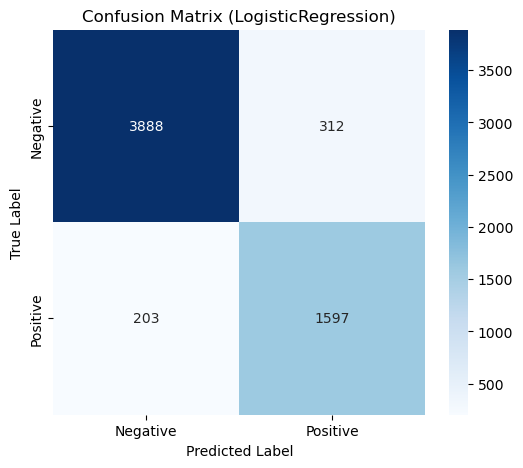

LogisticRegression metrics:
	ROC_AUC: 0.9689637566137566
	Accuracy: 0.9141666666666667
	Precision: 0.8365636458878994
	Recall: 0.8872222222222222
	F1-Score: 0.8611485575626854


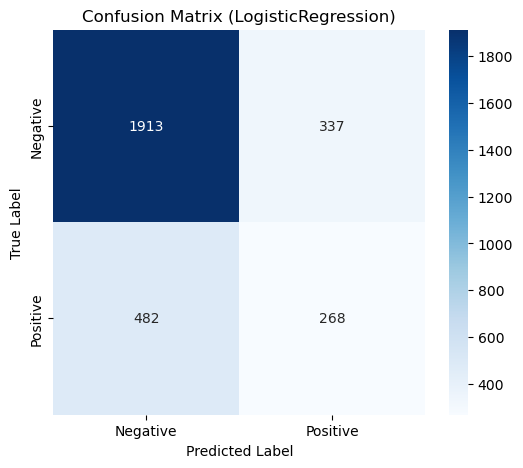

LogisticRegression metrics:
	ROC_AUC: 0.6967902222222222
	Accuracy: 0.727
	Precision: 0.44297520661157025
	Recall: 0.35733333333333334
	F1-Score: 0.3955719557195572


In [102]:
# testing models with SMOTE all standardized features with SMOTE validation
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(X_train_resampled, y_train_resampled, X_val_resampled, y_val_resampled, model_type=model_type)
    model_metrics[model_type] = [model, metrics]

Training Time: 5.8813 seconds


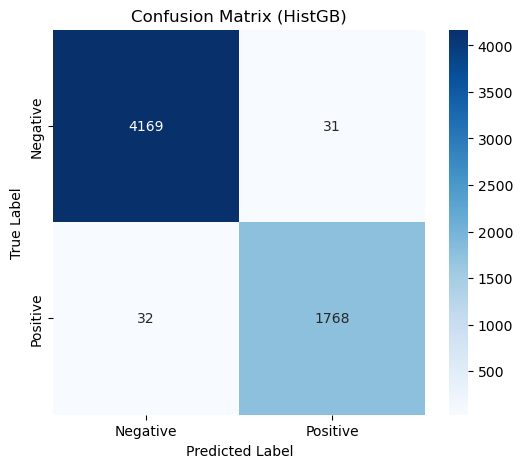

HistGB metrics:
	ROC_AUC: 0.9995073412698413
	Accuracy: 0.9895
	Precision: 0.9827682045580878
	Recall: 0.9822222222222222
	F1-Score: 0.982495137538205


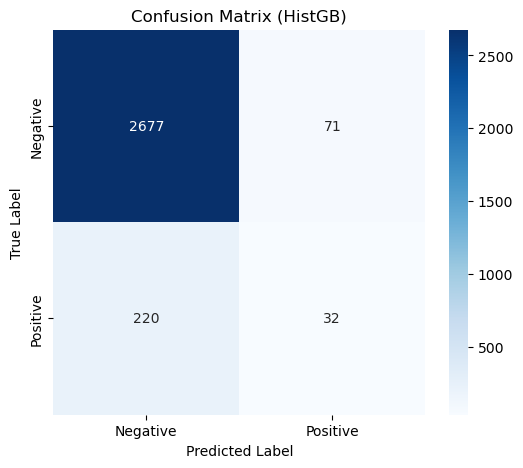

HistGB metrics:
	ROC_AUC: 0.7669213973799127
	Accuracy: 0.903
	Precision: 0.3106796116504854
	Recall: 0.12698412698412698
	F1-Score: 0.18028169014084508
Training Time: 63.8473 seconds


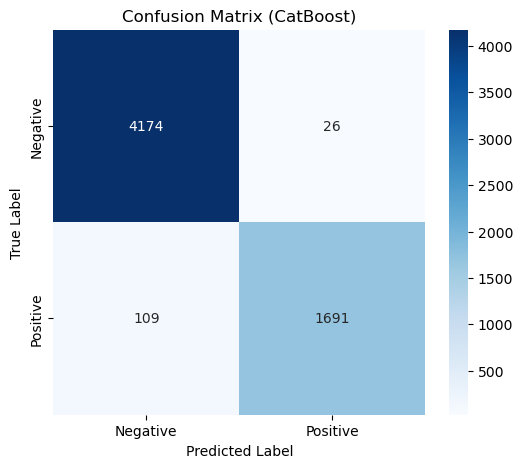

CatBoost metrics:
	ROC_AUC: 0.9982267857142857
	Accuracy: 0.9775
	Precision: 0.9848573092603378
	Recall: 0.9394444444444444
	F1-Score: 0.9616150127949957


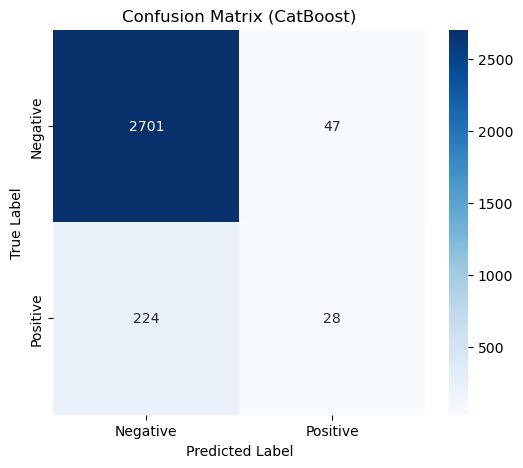

CatBoost metrics:
	ROC_AUC: 0.7761387791409625
	Accuracy: 0.9096666666666666
	Precision: 0.37333333333333335
	Recall: 0.1111111111111111
	F1-Score: 0.1712538226299694
[LightGBM] [Info] Number of positive: 1800, number of negative: 4200
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057914 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 408450
[LightGBM] [Info] Number of data points in the train set: 6000, number of used features: 1924
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.300000 -> initscore=-0.847298
[LightGBM] [Info] Start training from score -0.847298
Training Time: 4.9529 seconds


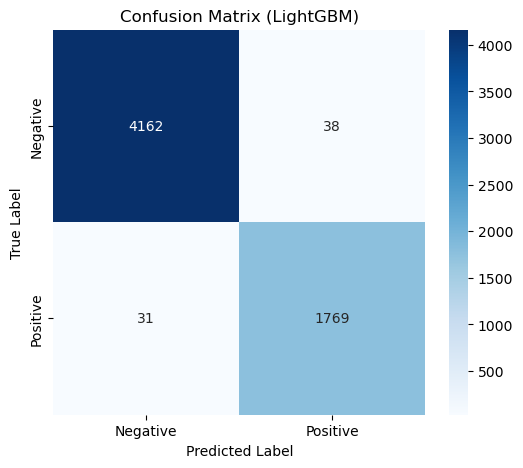

LightGBM metrics:
	ROC_AUC: 0.999559126984127
	Accuracy: 0.9885
	Precision: 0.9789706696181516
	Recall: 0.9827777777777778
	F1-Score: 0.9808705295259218


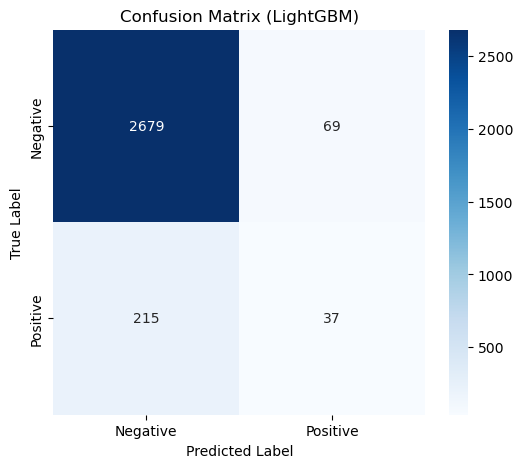

LightGBM metrics:
	ROC_AUC: 0.7639459289295534
	Accuracy: 0.9053333333333333
	Precision: 0.3490566037735849
	Recall: 0.14682539682539683
	F1-Score: 0.20670391061452514


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [01:54:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 8.1474 seconds


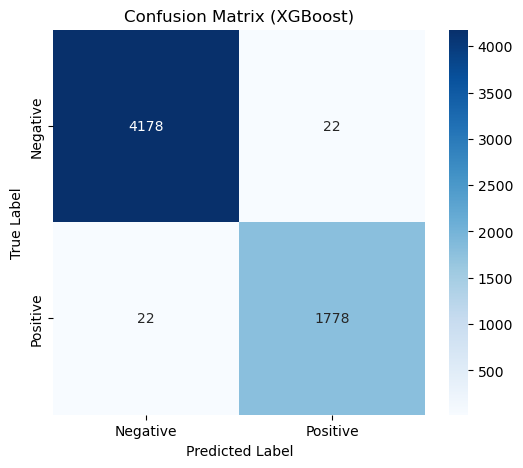

XGBoost metrics:
	ROC_AUC: 0.9997805555555556
	Accuracy: 0.9926666666666667
	Precision: 0.9877777777777778
	Recall: 0.9877777777777778
	F1-Score: 0.9877777777777778


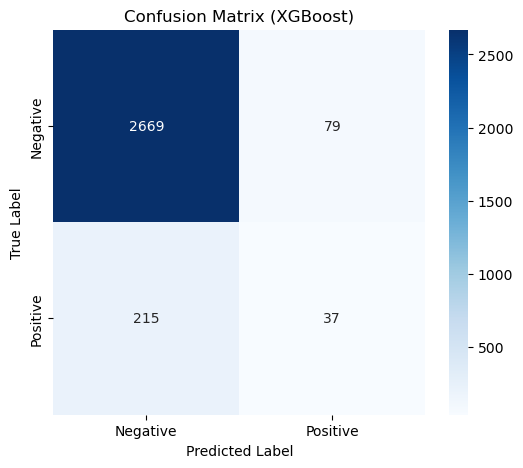

XGBoost metrics:
	ROC_AUC: 0.754355259813775
	Accuracy: 0.902
	Precision: 0.31896551724137934
	Recall: 0.14682539682539683
	F1-Score: 0.20108695652173914
Training Time: 4.4644 seconds


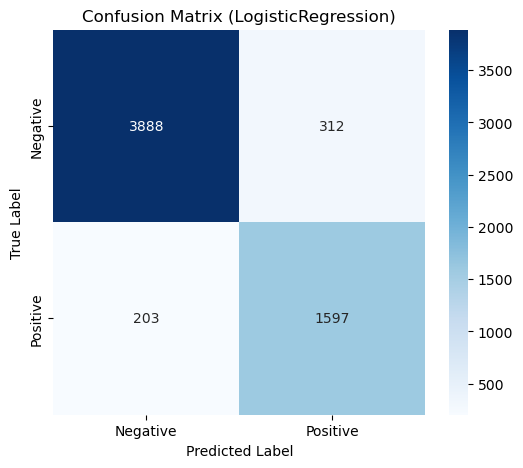

LogisticRegression metrics:
	ROC_AUC: 0.9689637566137566
	Accuracy: 0.9141666666666667
	Precision: 0.8365636458878994
	Recall: 0.8872222222222222
	F1-Score: 0.8611485575626854


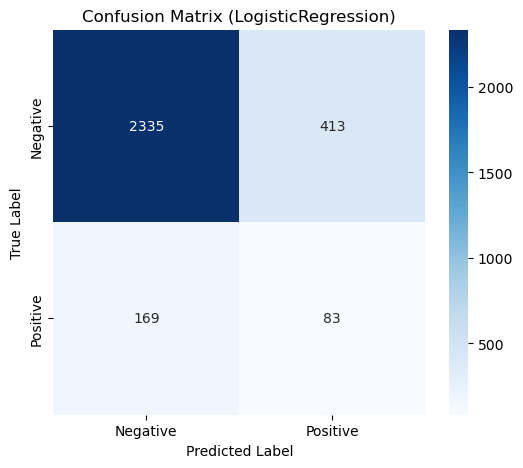

LogisticRegression metrics:
	ROC_AUC: 0.6591575980222268
	Accuracy: 0.806
	Precision: 0.16733870967741934
	Recall: 0.32936507936507936
	F1-Score: 0.22192513368983957


In [116]:
# testing models with SMOTE all standardized features with regular validation
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(X_train_resampled, y_train_resampled, X_val_standardized, y_val, model_type=model_type)
    model_metrics[model_type] = [model, metrics]

In [ ]:
########################
## SMOTE ratio 25% dq ##
########################
# HistGB metrics:
# 	ROC_AUC: 0.7785987211478478
# 	Accuracy: 0.908
# 	Precision: 0.36046511627906974
# 	Recall: 0.12301587301587301
# 	F1-Score: 0.1834319526627219

# CatBoost metrics:
# ROC_AUC: 0.7821417019015273 ------ BASELINE PERFORMANCE BEFORE HP TUNING
# 	Accuracy: 0.911
# 	Precision: 0.3728813559322034
# 	Recall: 0.0873015873015873
# 	F1-Score: 0.1414790996784566

# XGBoost metrics:
# 	ROC_AUC: 0.7425941810494211
# 	Accuracy: 0.9043333333333333
# 	Precision: 0.3364485981308411
# 	Recall: 0.14285714285714285
# 	F1-Score: 0.20055710306406685

## Week 7

#### Hyperparameter Tuning and Other Model Testing

In [105]:
# !pip install optuna

In [116]:
import optuna
import logging
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [109]:
X_train, X_test, y_train, y_test = split_data(features_df_DQ_no_na, test_size=0.25)
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test)
X_train_standardized, X_test_standardized = standardize(X_train, X_test)

In [110]:
def objective(trial, X, y):
    model_name = trial.suggest_categorical("model", ["HistGB", "LightGBM", "XGBoost", "CatBoost"])
    print(f"Trial {trial.number}: model {model_name}")
    logging.info(f"Trial {trial.number}: model {model_name}")
    
    if model_name == "HistGB":
        model = HistGradientBoostingClassifier(
            learning_rate=trial.suggest_float("lr", 0.01, 0.2, log=True),
            max_iter=trial.suggest_int("max_iter", 100, 1000),
            max_depth=trial.suggest_int("max_depth", 3, 20),
            min_samples_leaf=trial.suggest_int("min_samples_leaf", 5, 50),
            l2_regularization=trial.suggest_float("l2_regularization", 0.001, 5.0, log=True),
            early_stopping=True
        )
    elif model_name == "CatBoost":
        model = CatBoostClassifier(
            learning_rate=trial.suggest_float("lr", 0.001, 0.3, log=True),
            depth=trial.suggest_int("depth", 3, 12),
            iterations=trial.suggest_int("iterations", 100, 2000),
            l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1, 20, log=True),
            random_strength=trial.suggest_float("random_strength", 0, 10),
            verbose=0
        )
    elif model_name == "LightGBM":
        model = LGBMClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 2000),
            learning_rate=trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
            max_depth=trial.suggest_int("max_depth", 3, 15),
            num_leaves=trial.suggest_int("num_leaves", 8, 256),
            min_child_samples=trial.suggest_int("min_child_samples", 5, 100),
            # reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 10, log=True), for feature selection 
            reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 10, log=True), # for overfitting
            # colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
            # subsample=trial.suggest_float("subsample", 0.5, 1.0),
            # min_split_gain=trial.suggest_float("min_split_gain", 0, 0.1),
            # boosting_type=trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"]),
            verbose=-1
        )
    elif model_name == "XGBoost":
        model = XGBClassifier(
            n_estimators=trial.suggest_int("n_estimators", 100, 2000),
            learning_rate=trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
            max_depth=trial.suggest_int("max_depth", 3, 15),
            min_child_weight=trial.suggest_float("min_child_weight", 1, 10, log=True),
            gamma=trial.suggest_float("gamma", 0, 10),
            # reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 10, log=True),
            reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 10, log=True),
            eval_metric='logloss'
        )
    else:
        model = LogisticRegression(
            C=trial.suggest_float("C", 0.01, 10, log=True),
            max_iter=trial.suggest_int("max_iter", 100, 500)
        )
    
    cv = StratifiedKFold(n_splits=5, shuffle=True)
    score = np.mean(cross_val_score(model, X, y, cv=cv, scoring='roc_auc'))
    
    print(f"Trial {trial.number} - Model: {model_name}, Score: {score:.4f}")
    logging.info(f"Trial {trial.number} - Model: {model_name}, Score: {score:.4f}")
    
    return score

In [113]:
def run_optimization(X, y, n_trials=50):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X, y), n_trials=n_trials)
    
    print("Best parameters:", study.best_params)
    return study

**For entire `final_features_df`**:

Best parameters: {'model': 'XGBoost', 'lr': 0.041860800774292085, 'n_estimators': 166, 'max_depth': 4} -- 0.7642097767193806

**For top 50 features**:

Best parameters: {'model': 'HistGB', 'lr': 0.024459744135402826, 'max_iter': 291, 'max_depth': 9} -- 0.7701703831605068

**For top 100 features**:

Best parameters: {'model': 'LightGBM', 'lr': 0.018413940380645585, 'n_estimators': 173, 'num_leaves': 110} -- 0.7697076110002644

In [ ]:
study = run_optimization(X_train_standardized, y_train)

[I 2025-02-26 09:14:27,857] A new study created in memory with name: no-name-40f41470-72a2-4abe-a911-554696ad135c


Trial 0: model XGBoost


[I 2025-02-26 09:18:33,746] Trial 0 finished with value: 0.7645538027894629 and parameters: {'model': 'XGBoost', 'n_estimators': 1718, 'learning_rate': 0.06934347987038997, 'max_depth': 12, 'min_child_weight': 1.5746064819852736, 'gamma': 6.542746682984229, 'reg_lambda': 0.00014671195325972688}. Best is trial 0 with value: 0.7645538027894629.


Trial 0 - Model: XGBoost, Score: 0.7646
Trial 1: model HistGB


[I 2025-02-26 09:18:54,024] Trial 1 finished with value: 0.7552376242204507 and parameters: {'model': 'HistGB', 'lr': 0.11464248916903673, 'max_iter': 741, 'max_depth': 19, 'min_samples_leaf': 19, 'l2_regularization': 0.0029320743414777838}. Best is trial 0 with value: 0.7645538027894629.


Trial 1 - Model: HistGB, Score: 0.7552
Trial 2: model XGBoost


[I 2025-02-26 09:22:49,441] Trial 2 finished with value: 0.7702559011872473 and parameters: {'model': 'XGBoost', 'n_estimators': 1590, 'learning_rate': 0.10716811684230368, 'max_depth': 14, 'min_child_weight': 1.6853375704792999, 'gamma': 3.971769111328739, 'reg_lambda': 2.908478899796914}. Best is trial 2 with value: 0.7702559011872473.


Trial 2 - Model: XGBoost, Score: 0.7703
Trial 3: model HistGB


[I 2025-02-26 09:23:01,859] Trial 3 finished with value: 0.7589470546635939 and parameters: {'model': 'HistGB', 'lr': 0.1350075946131972, 'max_iter': 314, 'max_depth': 3, 'min_samples_leaf': 45, 'l2_regularization': 0.009531040884518163}. Best is trial 2 with value: 0.7702559011872473.


Trial 3 - Model: HistGB, Score: 0.7589
Trial 4: model CatBoost


[I 2025-02-26 09:41:23,859] Trial 4 finished with value: 0.775466286271984 and parameters: {'model': 'CatBoost', 'lr': 0.05359689012170398, 'depth': 10, 'iterations': 375, 'l2_leaf_reg': 5.605253157925136, 'random_strength': 1.4218885303330064}. Best is trial 4 with value: 0.775466286271984.


Trial 4 - Model: CatBoost, Score: 0.7755
Trial 5: model XGBoost


[I 2025-02-26 09:44:55,632] Trial 5 finished with value: 0.7367772046326415 and parameters: {'model': 'XGBoost', 'n_estimators': 546, 'learning_rate': 0.0012534424890638322, 'max_depth': 4, 'min_child_weight': 2.6863429856997136, 'gamma': 8.086380580569337, 'reg_lambda': 0.0062290131802228196}. Best is trial 4 with value: 0.775466286271984.


Trial 5 - Model: XGBoost, Score: 0.7368
Trial 6: model XGBoost


In [ ]:
df = study.trials_dataframe()
df.to_csv("optuna_trials.csv", index=False)  # Save as CSV

best_params = {
    "best_trial": study.best_trial.number,
    "best_value": study.best_value,
    "best_params": study.best_params
}

with open("optuna_best_params.json", "w") as f:
    json.dump(best_params, f, indent=4)

print("Best parameters saved!")

In [159]:
X_train_standardized_l1_50, X_test_standardized_l1_50 = get_lasso_features(X_train_standardized, y_train, X_test_standardized)
X_train_standardized_l1_100, X_test_standardized_l1_100 = get_lasso_features(X_train_standardized, y_train, X_test_standardized, max_features=100)

In [156]:
run_optimization(X_train_standardized_l1_50, y_train)

[I 2025-02-16 09:25:43,668] A new study created in memory with name: no-name-1c77e256-6007-45d8-a8ab-f0d93425930e
[I 2025-02-16 09:25:43,778] Trial 0 finished with value: 0.7531442758468295 and parameters: {'model': 'LogisticRegression', 'C': 1.0472664916198309, 'max_iter': 284}. Best is trial 0 with value: 0.7531442758468295.
[I 2025-02-16 09:25:43,856] Trial 1 finished with value: 0.7458249201748403 and parameters: {'model': 'LogisticRegression', 'C': 0.06709733013676819, 'max_iter': 122}. Best is trial 0 with value: 0.7531442758468295.


Trial 0: model LogisticRegression
Trial 0 - Model: LogisticRegression, Score: 0.7531
Trial 1: model LogisticRegression
Trial 1 - Model: LogisticRegression, Score: 0.7458
Trial 2: model HistGB


[I 2025-02-16 09:25:46,347] Trial 2 finished with value: 0.7539314793758836 and parameters: {'model': 'HistGB', 'lr': 0.08816728583868495, 'max_iter': 107, 'max_depth': 11}. Best is trial 2 with value: 0.7539314793758836.


Trial 2 - Model: HistGB, Score: 0.7539
Trial 3: model HistGB


[I 2025-02-16 09:25:47,315] Trial 3 finished with value: 0.7336515763162376 and parameters: {'model': 'HistGB', 'lr': 0.012361297076622235, 'max_iter': 132, 'max_depth': 3}. Best is trial 2 with value: 0.7539314793758836.
[I 2025-02-16 09:25:47,385] Trial 4 finished with value: 0.7460898613682293 and parameters: {'model': 'LogisticRegression', 'C': 0.038735012861097595, 'max_iter': 465}. Best is trial 2 with value: 0.7539314793758836.


Trial 3 - Model: HistGB, Score: 0.7337
Trial 4: model LogisticRegression
Trial 4 - Model: LogisticRegression, Score: 0.7461
Trial 5: model HistGB


[I 2025-02-16 09:25:50,056] Trial 5 finished with value: 0.761660934200464 and parameters: {'model': 'HistGB', 'lr': 0.042227320896738446, 'max_iter': 112, 'max_depth': 12}. Best is trial 5 with value: 0.761660934200464.


Trial 5 - Model: HistGB, Score: 0.7617
Trial 6: model HistGB


[I 2025-02-16 09:25:53,750] Trial 6 finished with value: 0.7599202542078911 and parameters: {'model': 'HistGB', 'lr': 0.043679142168376706, 'max_iter': 296, 'max_depth': 5}. Best is trial 5 with value: 0.761660934200464.
[I 2025-02-16 09:25:53,865] Trial 7 finished with value: 0.7506398060423776 and parameters: {'model': 'LogisticRegression', 'C': 3.2554075797937676, 'max_iter': 498}. Best is trial 5 with value: 0.761660934200464.


Trial 6 - Model: HistGB, Score: 0.7599
Trial 7: model LogisticRegression
Trial 7 - Model: LogisticRegression, Score: 0.7506
Trial 8: model HistGB


[I 2025-02-16 09:25:59,953] Trial 8 finished with value: 0.7701703831605068 and parameters: {'model': 'HistGB', 'lr': 0.024459744135402826, 'max_iter': 291, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.
[I 2025-02-16 09:26:00,023] Trial 9 finished with value: 0.7440762042745592 and parameters: {'model': 'LogisticRegression', 'C': 0.028216778398336088, 'max_iter': 150}. Best is trial 8 with value: 0.7701703831605068.


Trial 8 - Model: HistGB, Score: 0.7702
Trial 9: model LogisticRegression
Trial 9 - Model: LogisticRegression, Score: 0.7441
Trial 10: model XGBoost


[I 2025-02-16 09:26:01,900] Trial 10 finished with value: 0.7422492186730005 and parameters: {'model': 'XGBoost', 'lr': 0.01457221071452907, 'n_estimators': 75, 'max_depth': 8}. Best is trial 8 with value: 0.7701703831605068.


Trial 10 - Model: XGBoost, Score: 0.7422
Trial 11: model LightGBM


[I 2025-02-16 09:26:17,483] Trial 11 finished with value: 0.7562932900331849 and parameters: {'model': 'LightGBM', 'lr': 0.034992485562280295, 'n_estimators': 297, 'num_leaves': 149}. Best is trial 8 with value: 0.7701703831605068.


Trial 11 - Model: LightGBM, Score: 0.7563
Trial 12: model HistGB


[I 2025-02-16 09:26:19,334] Trial 12 finished with value: 0.7469720343975386 and parameters: {'model': 'HistGB', 'lr': 0.026668619677705365, 'max_iter': 67, 'max_depth': 12}. Best is trial 8 with value: 0.7701703831605068.


Trial 12 - Model: HistGB, Score: 0.7470
Trial 13: model HistGB


[I 2025-02-16 09:26:24,494] Trial 13 finished with value: 0.7485454797093171 and parameters: {'model': 'HistGB', 'lr': 0.09957022513037178, 'max_iter': 223, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.


Trial 13 - Model: HistGB, Score: 0.7485
Trial 14: model LightGBM


[I 2025-02-16 09:26:26,978] Trial 14 finished with value: 0.762647418324113 and parameters: {'model': 'LightGBM', 'lr': 0.024064962487835583, 'n_estimators': 225, 'num_leaves': 22}. Best is trial 8 with value: 0.7701703831605068.


Trial 14 - Model: LightGBM, Score: 0.7626
Trial 15: model LightGBM


[I 2025-02-16 09:26:30,129] Trial 15 finished with value: 0.7616339924993543 and parameters: {'model': 'LightGBM', 'lr': 0.020267269173556337, 'n_estimators': 231, 'num_leaves': 29}. Best is trial 8 with value: 0.7701703831605068.


Trial 15 - Model: LightGBM, Score: 0.7616
Trial 16: model LightGBM


[I 2025-02-16 09:26:32,032] Trial 16 finished with value: 0.7577548066420576 and parameters: {'model': 'LightGBM', 'lr': 0.02023932166730442, 'n_estimators': 161, 'num_leaves': 25}. Best is trial 8 with value: 0.7701703831605068.


Trial 16 - Model: LightGBM, Score: 0.7578
Trial 17: model XGBoost


[I 2025-02-16 09:26:34,222] Trial 17 finished with value: 0.7433047040784755 and parameters: {'model': 'XGBoost', 'lr': 0.18623001723369195, 'n_estimators': 187, 'max_depth': 6}. Best is trial 8 with value: 0.7701703831605068.


Trial 17 - Model: XGBoost, Score: 0.7433
Trial 18: model LightGBM


[I 2025-02-16 09:26:44,526] Trial 18 finished with value: 0.7611168524789439 and parameters: {'model': 'LightGBM', 'lr': 0.010040659622634621, 'n_estimators': 279, 'num_leaves': 81}. Best is trial 8 with value: 0.7701703831605068.


Trial 18 - Model: LightGBM, Score: 0.7611
Trial 19: model LightGBM


[I 2025-02-16 09:26:48,105] Trial 19 finished with value: 0.7637136775352754 and parameters: {'model': 'LightGBM', 'lr': 0.0693469715881561, 'n_estimators': 111, 'num_leaves': 75}. Best is trial 8 with value: 0.7701703831605068.


Trial 19 - Model: LightGBM, Score: 0.7637
Trial 20: model XGBoost


[I 2025-02-16 09:26:50,132] Trial 20 finished with value: 0.7549517553666154 and parameters: {'model': 'XGBoost', 'lr': 0.08023739666449206, 'n_estimators': 69, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 20 - Model: XGBoost, Score: 0.7550
Trial 21: model LightGBM


[I 2025-02-16 09:26:53,796] Trial 21 finished with value: 0.7534160683993152 and parameters: {'model': 'LightGBM', 'lr': 0.06154660560214425, 'n_estimators': 133, 'num_leaves': 77}. Best is trial 8 with value: 0.7701703831605068.


Trial 21 - Model: LightGBM, Score: 0.7534
Trial 22: model LightGBM


[I 2025-02-16 09:26:56,984] Trial 22 finished with value: 0.7630476505423264 and parameters: {'model': 'LightGBM', 'lr': 0.024394070868699626, 'n_estimators': 124, 'num_leaves': 56}. Best is trial 8 with value: 0.7701703831605068.


Trial 22 - Model: LightGBM, Score: 0.7630
Trial 23: model LightGBM


[I 2025-02-16 09:26:59,731] Trial 23 finished with value: 0.7637548122785376 and parameters: {'model': 'LightGBM', 'lr': 0.030945350348099494, 'n_estimators': 115, 'num_leaves': 62}. Best is trial 8 with value: 0.7701703831605068.


Trial 23 - Model: LightGBM, Score: 0.7638
Trial 24: model LightGBM


[I 2025-02-16 09:27:04,810] Trial 24 finished with value: 0.758114121365095 and parameters: {'model': 'LightGBM', 'lr': 0.061900535474844864, 'n_estimators': 112, 'num_leaves': 116}. Best is trial 8 with value: 0.7701703831605068.


Trial 24 - Model: LightGBM, Score: 0.7581
Trial 25: model LightGBM


[I 2025-02-16 09:27:05,971] Trial 25 finished with value: 0.744947490348497 and parameters: {'model': 'LightGBM', 'lr': 0.15414171633677756, 'n_estimators': 52, 'num_leaves': 60}. Best is trial 8 with value: 0.7701703831605068.


Trial 25 - Model: LightGBM, Score: 0.7449
Trial 26: model LightGBM


[I 2025-02-16 09:27:09,833] Trial 26 finished with value: 0.7491572526522225 and parameters: {'model': 'LightGBM', 'lr': 0.0330306719395046, 'n_estimators': 99, 'num_leaves': 104}. Best is trial 8 with value: 0.7701703831605068.


Trial 26 - Model: LightGBM, Score: 0.7492
Trial 27: model HistGB


[I 2025-02-16 09:27:14,171] Trial 27 finished with value: 0.7626756698907794 and parameters: {'model': 'HistGB', 'lr': 0.03425883323164918, 'max_iter': 215, 'max_depth': 6}. Best is trial 8 with value: 0.7701703831605068.


Trial 27 - Model: HistGB, Score: 0.7627
Trial 28: model XGBoost


[I 2025-02-16 09:27:17,123] Trial 28 finished with value: 0.7630557918584907 and parameters: {'model': 'XGBoost', 'lr': 0.058050700592446124, 'n_estimators': 166, 'max_depth': 8}. Best is trial 8 with value: 0.7701703831605068.


Trial 28 - Model: XGBoost, Score: 0.7631
Trial 29: model LightGBM


[I 2025-02-16 09:27:20,061] Trial 29 finished with value: 0.7459840965817328 and parameters: {'model': 'LightGBM', 'lr': 0.11732235458892129, 'n_estimators': 140, 'num_leaves': 56}. Best is trial 8 with value: 0.7701703831605068.


Trial 29 - Model: LightGBM, Score: 0.7460
Trial 30: model HistGB


[I 2025-02-16 09:27:26,721] Trial 30 finished with value: 0.7700138468262928 and parameters: {'model': 'HistGB', 'lr': 0.01640063201341833, 'max_iter': 273, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 30 - Model: HistGB, Score: 0.7700
Trial 31: model HistGB


[I 2025-02-16 09:27:33,388] Trial 31 finished with value: 0.7594481400313153 and parameters: {'model': 'HistGB', 'lr': 0.016498573283487444, 'max_iter': 268, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 31 - Model: HistGB, Score: 0.7594
Trial 32: model HistGB


[I 2025-02-16 09:27:39,461] Trial 32 finished with value: 0.7605283529388572 and parameters: {'model': 'HistGB', 'lr': 0.01575961868250496, 'max_iter': 244, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 32 - Model: HistGB, Score: 0.7605
Trial 33: model HistGB


[I 2025-02-16 09:27:43,563] Trial 33 finished with value: 0.7550328425153795 and parameters: {'model': 'HistGB', 'lr': 0.02983947029063918, 'max_iter': 188, 'max_depth': 7}. Best is trial 8 with value: 0.7701703831605068.


Trial 33 - Model: HistGB, Score: 0.7550
Trial 34: model HistGB


[I 2025-02-16 09:27:49,683] Trial 34 finished with value: 0.7624867060879295 and parameters: {'model': 'HistGB', 'lr': 0.019552815660166978, 'max_iter': 258, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.
[I 2025-02-16 09:27:49,819] Trial 35 finished with value: 0.7543672195972013 and parameters: {'model': 'LogisticRegression', 'C': 9.756493671677912, 'max_iter': 358}. Best is trial 8 with value: 0.7701703831605068.


Trial 34 - Model: HistGB, Score: 0.7625
Trial 35: model LogisticRegression
Trial 35 - Model: LogisticRegression, Score: 0.7544
Trial 36: model HistGB


[I 2025-02-16 09:27:54,456] Trial 36 finished with value: 0.7642931761104609 and parameters: {'model': 'HistGB', 'lr': 0.04868603291725346, 'max_iter': 186, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 36 - Model: HistGB, Score: 0.7643
Trial 37: model HistGB


[I 2025-02-16 09:27:58,977] Trial 37 finished with value: 0.7528195742842638 and parameters: {'model': 'HistGB', 'lr': 0.04921087339199279, 'max_iter': 181, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 37 - Model: HistGB, Score: 0.7528
Trial 38: model HistGB


[I 2025-02-16 09:28:04,207] Trial 38 finished with value: 0.7576012605308741 and parameters: {'model': 'HistGB', 'lr': 0.012311359028905221, 'max_iter': 216, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.


Trial 38 - Model: HistGB, Score: 0.7576
Trial 39: model HistGB


[I 2025-02-16 09:28:11,138] Trial 39 finished with value: 0.7638886525799388 and parameters: {'model': 'HistGB', 'lr': 0.03815099130261128, 'max_iter': 283, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 39 - Model: HistGB, Score: 0.7639
Trial 40: model HistGB


[I 2025-02-16 09:28:17,947] Trial 40 finished with value: 0.7474554343597103 and parameters: {'model': 'HistGB', 'lr': 0.04034629458229802, 'max_iter': 283, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 40 - Model: HistGB, Score: 0.7475
Trial 41: model HistGB


[I 2025-02-16 09:28:23,944] Trial 41 finished with value: 0.7513545780183724 and parameters: {'model': 'HistGB', 'lr': 0.0495143739322058, 'max_iter': 250, 'max_depth': 11}. Best is trial 8 with value: 0.7701703831605068.


Trial 41 - Model: HistGB, Score: 0.7514
Trial 42: model HistGB


[I 2025-02-16 09:28:30,818] Trial 42 finished with value: 0.757339758963153 and parameters: {'model': 'HistGB', 'lr': 0.03952385438206622, 'max_iter': 287, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 42 - Model: HistGB, Score: 0.7573
Trial 43: model HistGB


[I 2025-02-16 09:28:36,748] Trial 43 finished with value: 0.7577423301928216 and parameters: {'model': 'HistGB', 'lr': 0.02868865409213526, 'max_iter': 236, 'max_depth': 12}. Best is trial 8 with value: 0.7701703831605068.


Trial 43 - Model: HistGB, Score: 0.7577
Trial 44: model HistGB


[I 2025-02-16 09:28:43,161] Trial 44 finished with value: 0.7644858948635499 and parameters: {'model': 'HistGB', 'lr': 0.022069101236521775, 'max_iter': 270, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.


Trial 44 - Model: HistGB, Score: 0.7645
Trial 45: model HistGB


[I 2025-02-16 09:28:49,803] Trial 45 finished with value: 0.7536133100021315 and parameters: {'model': 'HistGB', 'lr': 0.013069600752474913, 'max_iter': 270, 'max_depth': 9}. Best is trial 8 with value: 0.7701703831605068.


Trial 45 - Model: HistGB, Score: 0.7536
Trial 46: model HistGB


[I 2025-02-16 09:28:56,316] Trial 46 finished with value: 0.7667039149591452 and parameters: {'model': 'HistGB', 'lr': 0.023031119627119716, 'max_iter': 269, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.


Trial 46 - Model: HistGB, Score: 0.7667
Trial 47: model HistGB


[I 2025-02-16 09:29:02,700] Trial 47 finished with value: 0.7602704994101467 and parameters: {'model': 'HistGB', 'lr': 0.023652337714215835, 'max_iter': 263, 'max_depth': 10}. Best is trial 8 with value: 0.7701703831605068.
[I 2025-02-16 09:29:02,801] Trial 48 finished with value: 0.7500924086392848 and parameters: {'model': 'LogisticRegression', 'C': 0.269382539757453, 'max_iter': 335}. Best is trial 8 with value: 0.7701703831605068.


Trial 47 - Model: HistGB, Score: 0.7603
Trial 48: model LogisticRegression
Trial 48 - Model: LogisticRegression, Score: 0.7501
Trial 49: model HistGB


[I 2025-02-16 09:29:07,974] Trial 49 finished with value: 0.757329590562626 and parameters: {'model': 'HistGB', 'lr': 0.017664882654131436, 'max_iter': 229, 'max_depth': 8}. Best is trial 8 with value: 0.7701703831605068.


Trial 49 - Model: HistGB, Score: 0.7573
Best parameters: {'model': 'HistGB', 'lr': 0.024459744135402826, 'max_iter': 291, 'max_depth': 9}


In [161]:
run_optimization(X_train_standardized_l1_100, y_train)

[I 2025-02-16 09:30:51,375] A new study created in memory with name: no-name-56327ae7-6d09-4e4b-ba66-14e1f94f1d30


Trial 0: model LightGBM


[I 2025-02-16 09:31:07,652] Trial 0 finished with value: 0.7641911318706711 and parameters: {'model': 'LightGBM', 'lr': 0.0234781276683241, 'n_estimators': 291, 'num_leaves': 102}. Best is trial 0 with value: 0.7641911318706711.


Trial 0 - Model: LightGBM, Score: 0.7642
Trial 1: model LogisticRegression


[I 2025-02-16 09:31:13,642] Trial 1 finished with value: 0.7507038770412037 and parameters: {'model': 'LogisticRegression', 'C': 1.5623683553091934, 'max_iter': 229}. Best is trial 0 with value: 0.7641911318706711.


Trial 1 - Model: LogisticRegression, Score: 0.7507
Trial 2: model LightGBM


[I 2025-02-16 09:31:21,184] Trial 2 finished with value: 0.747492634928692 and parameters: {'model': 'LightGBM', 'lr': 0.14199491247430626, 'n_estimators': 149, 'num_leaves': 100}. Best is trial 0 with value: 0.7641911318706711.


Trial 2 - Model: LightGBM, Score: 0.7475
Trial 3: model XGBoost


[I 2025-02-16 09:31:26,313] Trial 3 finished with value: 0.7620362500544701 and parameters: {'model': 'XGBoost', 'lr': 0.02686734068119967, 'n_estimators': 211, 'max_depth': 7}. Best is trial 0 with value: 0.7641911318706711.


Trial 3 - Model: XGBoost, Score: 0.7620
Trial 4: model XGBoost


[I 2025-02-16 09:31:28,258] Trial 4 finished with value: 0.7602788376155093 and parameters: {'model': 'XGBoost', 'lr': 0.028723191499087176, 'n_estimators': 86, 'max_depth': 6}. Best is trial 0 with value: 0.7641911318706711.


Trial 4 - Model: XGBoost, Score: 0.7603
Trial 5: model XGBoost


[I 2025-02-16 09:31:31,933] Trial 5 finished with value: 0.7677577400867006 and parameters: {'model': 'XGBoost', 'lr': 0.05426740800942819, 'n_estimators': 281, 'max_depth': 5}. Best is trial 5 with value: 0.7677577400867006.


Trial 5 - Model: XGBoost, Score: 0.7678
Trial 6: model XGBoost


[I 2025-02-16 09:31:38,546] Trial 6 finished with value: 0.746742798170075 and parameters: {'model': 'XGBoost', 'lr': 0.014715993057347719, 'n_estimators': 105, 'max_depth': 11}. Best is trial 5 with value: 0.7677577400867006.


Trial 6 - Model: XGBoost, Score: 0.7467
Trial 7: model LightGBM


[I 2025-02-16 09:31:48,205] Trial 7 finished with value: 0.7697076110002644 and parameters: {'model': 'LightGBM', 'lr': 0.018413940380645585, 'n_estimators': 173, 'num_leaves': 110}. Best is trial 7 with value: 0.7697076110002644.


Trial 7 - Model: LightGBM, Score: 0.7697
Trial 8: model XGBoost


[I 2025-02-16 09:31:58,042] Trial 8 finished with value: 0.7539004887570911 and parameters: {'model': 'XGBoost', 'lr': 0.015578052166428203, 'n_estimators': 213, 'max_depth': 10}. Best is trial 7 with value: 0.7697076110002644.


Trial 8 - Model: XGBoost, Score: 0.7539
Trial 9: model HistGB


[I 2025-02-16 09:32:04,360] Trial 9 finished with value: 0.7696920736175653 and parameters: {'model': 'HistGB', 'lr': 0.014853162634938665, 'max_iter': 246, 'max_depth': 7}. Best is trial 7 with value: 0.7697076110002644.


Trial 9 - Model: HistGB, Score: 0.7697
Trial 10: model LightGBM


[I 2025-02-16 09:32:06,554] Trial 10 finished with value: 0.7586481876051123 and parameters: {'model': 'LightGBM', 'lr': 0.06660847501015636, 'n_estimators': 150, 'num_leaves': 27}. Best is trial 7 with value: 0.7697076110002644.


Trial 10 - Model: LightGBM, Score: 0.7586
Trial 11: model HistGB


[I 2025-02-16 09:32:08,998] Trial 11 finished with value: 0.7499423316916964 and parameters: {'model': 'HistGB', 'lr': 0.010002786266514794, 'max_iter': 296, 'max_depth': 3}. Best is trial 7 with value: 0.7697076110002644.


Trial 11 - Model: HistGB, Score: 0.7499
Trial 12: model HistGB


[I 2025-02-16 09:32:10,919] Trial 12 finished with value: 0.7415895209923953 and parameters: {'model': 'HistGB', 'lr': 0.01087315484643933, 'max_iter': 59, 'max_depth': 9}. Best is trial 7 with value: 0.7697076110002644.


Trial 12 - Model: HistGB, Score: 0.7416
Trial 13: model HistGB


[I 2025-02-16 09:32:15,858] Trial 13 finished with value: 0.7673320168106814 and parameters: {'model': 'HistGB', 'lr': 0.018640033814135686, 'max_iter': 165, 'max_depth': 12}. Best is trial 7 with value: 0.7697076110002644.


Trial 13 - Model: HistGB, Score: 0.7673
Trial 14: model LogisticRegression


[I 2025-02-16 09:32:18,638] Trial 14 finished with value: 0.7404432459317888 and parameters: {'model': 'LogisticRegression', 'C': 0.018583420419946248, 'max_iter': 476}. Best is trial 7 with value: 0.7697076110002644.


Trial 14 - Model: LogisticRegression, Score: 0.7404
Trial 15: model HistGB


[I 2025-02-16 09:32:25,380] Trial 15 finished with value: 0.7595379254835426 and parameters: {'model': 'HistGB', 'lr': 0.03666262211476673, 'max_iter': 262, 'max_depth': 8}. Best is trial 7 with value: 0.7697076110002644.


Trial 15 - Model: HistGB, Score: 0.7595
Trial 16: model LightGBM


[I 2025-02-16 09:32:36,176] Trial 16 finished with value: 0.7679896845507896 and parameters: {'model': 'LightGBM', 'lr': 0.08753921675960269, 'n_estimators': 211, 'num_leaves': 143}. Best is trial 7 with value: 0.7697076110002644.


Trial 16 - Model: LightGBM, Score: 0.7680
Trial 17: model HistGB


[I 2025-02-16 09:32:38,395] Trial 17 finished with value: 0.762808981467401 and parameters: {'model': 'HistGB', 'lr': 0.03818348829101968, 'max_iter': 179, 'max_depth': 4}. Best is trial 7 with value: 0.7697076110002644.


Trial 17 - Model: HistGB, Score: 0.7628
Trial 18: model LightGBM


[I 2025-02-16 09:32:39,807] Trial 18 finished with value: 0.751974680918714 and parameters: {'model': 'LightGBM', 'lr': 0.019177098301862885, 'n_estimators': 53, 'num_leaves': 50}. Best is trial 7 with value: 0.7697076110002644.


Trial 18 - Model: LightGBM, Score: 0.7520
Trial 19: model LogisticRegression


[I 2025-02-16 09:32:46,739] Trial 19 finished with value: 0.7510814854008325 and parameters: {'model': 'LogisticRegression', 'C': 7.840121882646625, 'max_iter': 407}. Best is trial 7 with value: 0.7697076110002644.


Trial 19 - Model: LogisticRegression, Score: 0.7511
Trial 20: model LightGBM


[I 2025-02-16 09:32:53,610] Trial 20 finished with value: 0.7522777595710355 and parameters: {'model': 'LightGBM', 'lr': 0.1894502862178441, 'n_estimators': 240, 'num_leaves': 148}. Best is trial 7 with value: 0.7697076110002644.


Trial 20 - Model: LightGBM, Score: 0.7523
Trial 21: model LightGBM


[I 2025-02-16 09:33:03,092] Trial 21 finished with value: 0.7659665079815285 and parameters: {'model': 'LightGBM', 'lr': 0.08997910618608276, 'n_estimators': 177, 'num_leaves': 146}. Best is trial 7 with value: 0.7697076110002644.


Trial 21 - Model: LightGBM, Score: 0.7660
Trial 22: model LightGBM


[I 2025-02-16 09:33:12,098] Trial 22 finished with value: 0.7538377864506571 and parameters: {'model': 'LightGBM', 'lr': 0.09336355020789654, 'n_estimators': 182, 'num_leaves': 120}. Best is trial 7 with value: 0.7697076110002644.


Trial 22 - Model: LightGBM, Score: 0.7538
Trial 23: model LightGBM


[I 2025-02-16 09:33:23,872] Trial 23 finished with value: 0.7586723387873817 and parameters: {'model': 'LightGBM', 'lr': 0.08458172283580215, 'n_estimators': 247, 'num_leaves': 124}. Best is trial 7 with value: 0.7697076110002644.


Trial 23 - Model: LightGBM, Score: 0.7587
Trial 24: model HistGB


[I 2025-02-16 09:33:25,787] Trial 24 finished with value: 0.7499703149679766 and parameters: {'model': 'HistGB', 'lr': 0.12207394875463493, 'max_iter': 68, 'max_depth': 7}. Best is trial 7 with value: 0.7697076110002644.


Trial 24 - Model: HistGB, Score: 0.7500
Trial 25: model LightGBM


[I 2025-02-16 09:33:30,422] Trial 25 finished with value: 0.7683542999123256 and parameters: {'model': 'LightGBM', 'lr': 0.013134132651001629, 'n_estimators': 134, 'num_leaves': 77}. Best is trial 7 with value: 0.7697076110002644.


Trial 25 - Model: LightGBM, Score: 0.7684
Trial 26: model LightGBM


[I 2025-02-16 09:33:34,840] Trial 26 finished with value: 0.7541221826986767 and parameters: {'model': 'LightGBM', 'lr': 0.013145180614396611, 'n_estimators': 123, 'num_leaves': 75}. Best is trial 7 with value: 0.7697076110002644.


Trial 26 - Model: LightGBM, Score: 0.7541
Trial 27: model HistGB


[I 2025-02-16 09:33:38,613] Trial 27 finished with value: 0.7568503197757229 and parameters: {'model': 'HistGB', 'lr': 0.020624110458774676, 'max_iter': 127, 'max_depth': 9}. Best is trial 7 with value: 0.7697076110002644.


Trial 27 - Model: HistGB, Score: 0.7569
Trial 28: model LogisticRegression


[I 2025-02-16 09:33:42,040] Trial 28 finished with value: 0.7457509426325343 and parameters: {'model': 'LogisticRegression', 'C': 0.035302875438871506, 'max_iter': 345}. Best is trial 7 with value: 0.7697076110002644.


Trial 28 - Model: LogisticRegression, Score: 0.7458
Trial 29: model LightGBM


[I 2025-02-16 09:33:47,172] Trial 29 finished with value: 0.7576580481559546 and parameters: {'model': 'LightGBM', 'lr': 0.01326132900324483, 'n_estimators': 145, 'num_leaves': 78}. Best is trial 7 with value: 0.7697076110002644.


Trial 29 - Model: LightGBM, Score: 0.7577
Trial 30: model LightGBM


[I 2025-02-16 09:33:49,331] Trial 30 finished with value: 0.7554167892970993 and parameters: {'model': 'LightGBM', 'lr': 0.017021905637995972, 'n_estimators': 76, 'num_leaves': 58}. Best is trial 7 with value: 0.7697076110002644.


Trial 30 - Model: LightGBM, Score: 0.7554
Trial 31: model LightGBM


[I 2025-02-16 09:33:59,603] Trial 31 finished with value: 0.7638096780458197 and parameters: {'model': 'LightGBM', 'lr': 0.029787291826839223, 'n_estimators': 207, 'num_leaves': 124}. Best is trial 7 with value: 0.7697076110002644.


Trial 31 - Model: LightGBM, Score: 0.7638
Trial 32: model LightGBM


[I 2025-02-16 09:34:06,760] Trial 32 finished with value: 0.7604089017221437 and parameters: {'model': 'LightGBM', 'lr': 0.05380750714637335, 'n_estimators': 178, 'num_leaves': 95}. Best is trial 7 with value: 0.7697076110002644.


Trial 32 - Model: LightGBM, Score: 0.7604
Trial 33: model LightGBM


[I 2025-02-16 09:34:13,394] Trial 33 finished with value: 0.7571065003807038 and parameters: {'model': 'LightGBM', 'lr': 0.01296212450868658, 'n_estimators': 133, 'num_leaves': 134}. Best is trial 7 with value: 0.7697076110002644.


Trial 33 - Model: LightGBM, Score: 0.7571
Trial 34: model LightGBM


[I 2025-02-16 09:34:23,869] Trial 34 finished with value: 0.763064900726364 and parameters: {'model': 'LightGBM', 'lr': 0.023643929105258355, 'n_estimators': 237, 'num_leaves': 110}. Best is trial 7 with value: 0.7697076110002644.


Trial 34 - Model: LightGBM, Score: 0.7631
Trial 35: model LightGBM


[I 2025-02-16 09:34:29,309] Trial 35 finished with value: 0.7578837143586615 and parameters: {'model': 'LightGBM', 'lr': 0.01141593237979808, 'n_estimators': 192, 'num_leaves': 64}. Best is trial 7 with value: 0.7697076110002644.


Trial 35 - Model: LightGBM, Score: 0.7579
Trial 36: model LogisticRegression


[I 2025-02-16 09:34:34,840] Trial 36 finished with value: 0.7465818800085691 and parameters: {'model': 'LogisticRegression', 'C': 0.2768818229068465, 'max_iter': 376}. Best is trial 7 with value: 0.7697076110002644.


Trial 36 - Model: LogisticRegression, Score: 0.7466
Trial 37: model HistGB


[I 2025-02-16 09:34:38,734] Trial 37 finished with value: 0.7630423784196966 and parameters: {'model': 'HistGB', 'lr': 0.024283347783343078, 'max_iter': 209, 'max_depth': 5}. Best is trial 7 with value: 0.7697076110002644.


Trial 37 - Model: HistGB, Score: 0.7630
Trial 38: model XGBoost


[I 2025-02-16 09:34:39,872] Trial 38 finished with value: 0.7465328720468103 and parameters: {'model': 'XGBoost', 'lr': 0.035083482653063776, 'n_estimators': 113, 'max_depth': 3}. Best is trial 7 with value: 0.7697076110002644.


Trial 38 - Model: XGBoost, Score: 0.7465
Trial 39: model LightGBM


[I 2025-02-16 09:34:46,482] Trial 39 finished with value: 0.7671530981983263 and parameters: {'model': 'LightGBM', 'lr': 0.04883565863029069, 'n_estimators': 167, 'num_leaves': 89}. Best is trial 7 with value: 0.7697076110002644.


Trial 39 - Model: LightGBM, Score: 0.7672
Trial 40: model XGBoost


[I 2025-02-16 09:34:53,355] Trial 40 finished with value: 0.7463067396554525 and parameters: {'model': 'XGBoost', 'lr': 0.06684712128924616, 'n_estimators': 270, 'max_depth': 8}. Best is trial 7 with value: 0.7697076110002644.


Trial 40 - Model: XGBoost, Score: 0.7463
Trial 41: model XGBoost


[I 2025-02-16 09:34:57,206] Trial 41 finished with value: 0.7628100744681434 and parameters: {'model': 'XGBoost', 'lr': 0.06114988633926783, 'n_estimators': 295, 'max_depth': 5}. Best is trial 7 with value: 0.7697076110002644.


Trial 41 - Model: XGBoost, Score: 0.7628
Trial 42: model XGBoost


[I 2025-02-16 09:35:01,786] Trial 42 finished with value: 0.7556816747276632 and parameters: {'model': 'XGBoost', 'lr': 0.1131138710875235, 'n_estimators': 276, 'max_depth': 6}. Best is trial 7 with value: 0.7697076110002644.


Trial 42 - Model: XGBoost, Score: 0.7557
Trial 43: model XGBoost


[I 2025-02-16 09:35:04,257] Trial 43 finished with value: 0.7500386372542565 and parameters: {'model': 'XGBoost', 'lr': 0.01541550696872734, 'n_estimators': 161, 'max_depth': 5}. Best is trial 7 with value: 0.7697076110002644.


Trial 43 - Model: XGBoost, Score: 0.7500
Trial 44: model XGBoost


[I 2025-02-16 09:35:08,652] Trial 44 finished with value: 0.7615596218369267 and parameters: {'model': 'XGBoost', 'lr': 0.07536379977496643, 'n_estimators': 262, 'max_depth': 6}. Best is trial 7 with value: 0.7697076110002644.


Trial 44 - Model: XGBoost, Score: 0.7616
Trial 45: model HistGB


[I 2025-02-16 09:35:10,209] Trial 45 finished with value: 0.763311558570875 and parameters: {'model': 'HistGB', 'lr': 0.043519767993477766, 'max_iter': 112, 'max_depth': 4}. Best is trial 7 with value: 0.7697076110002644.


Trial 45 - Model: HistGB, Score: 0.7633
Trial 46: model LightGBM


[I 2025-02-16 09:35:17,302] Trial 46 finished with value: 0.7549684421776531 and parameters: {'model': 'LightGBM', 'lr': 0.16762481006008917, 'n_estimators': 199, 'num_leaves': 135}. Best is trial 7 with value: 0.7697076110002644.


Trial 46 - Model: LightGBM, Score: 0.7550
Trial 47: model XGBoost


[I 2025-02-16 09:35:21,051] Trial 47 finished with value: 0.761499302551099 and parameters: {'model': 'XGBoost', 'lr': 0.02943871968224155, 'n_estimators': 142, 'max_depth': 7}. Best is trial 7 with value: 0.7697076110002644.


Trial 47 - Model: XGBoost, Score: 0.7615
Trial 48: model HistGB


[I 2025-02-16 09:35:27,183] Trial 48 finished with value: 0.7664462174004768 and parameters: {'model': 'HistGB', 'lr': 0.011689121724646345, 'max_iter': 217, 'max_depth': 9}. Best is trial 7 with value: 0.7697076110002644.


Trial 48 - Model: HistGB, Score: 0.7664
Trial 49: model LogisticRegression


[I 2025-02-16 09:35:32,639] Trial 49 finished with value: 0.7493048109658852 and parameters: {'model': 'LogisticRegression', 'C': 0.18861654917775247, 'max_iter': 304}. Best is trial 7 with value: 0.7697076110002644.


Trial 49 - Model: LogisticRegression, Score: 0.7493
Best parameters: {'model': 'LightGBM', 'lr': 0.018413940380645585, 'n_estimators': 173, 'num_leaves': 110}


## Week 8

#### Scoring Exclusions

**Criteria to exclude consumers**

- minimum number of transactions
    - 5% of consumers have <=14 transactions, 2% have <=3, 1% < 2
    - decided on at having **at least 2 transactions**
- minimum number of credits and debits
    - 16 consumers with no credits, 296 consumers with no debits
    - decided on **having at least 1 credit and 1 debit transaction**
- minimum balance
    - 2.84% of consumers have balance < 0, 3.97% have balance <= 0, 1.13% have balance = 0
    - does it make more sense to drop the consumers with balance of 0? that holds less information than if a balance is negative
    - decided on **having nonzero balance**
- number of consumers meeting all criteria: 12250

In [50]:
# minimum number of transactions
trxn_counts = trxn_df.groupby('prism_consumer_id')['prism_transaction_id'].count()
cons_at_least_2_trxns = trxn_counts[trxn_counts >= 2].index

In [51]:
# consumers with non zero balance
balance_sum = acct_df.groupby('prism_consumer_id')['balance'].sum()
cons_non_zero_balances = balance_sum[balance_sum != 0].index

In [52]:
# consumers with at least 1 credit and debit transaction
credit_debit_counts = trxn_df.groupby('prism_consumer_id')['credit_or_debit'].value_counts().unstack(fill_value=0)
credit_debit_counts.columns = ['num_credits', 'num_debits']
cons_non_zero_credits = credit_debit_counts[credit_debit_counts.num_credits > 0].index
cons_non_zero_debits = credit_debit_counts[credit_debit_counts.num_debits > 0].index
cons_has_both_credits_debits = credit_debit_counts[((credit_debit_counts.num_credits > 0) & (credit_debit_counts.num_debits > 0))].index

In [53]:
len(cons_at_least_2_trxns), len(cons_non_zero_balances), len(cons_has_both_credits_debits)

(14329, 12861, 14180)

In [33]:
def exclude_consumers(cons_df, acct_df, trxn_df):
    # minimum number of transactions
    trxn_counts = trxn_df.groupby('prism_consumer_id')['prism_transaction_id'].count()
    cons_at_least_2_trxns = set(trxn_counts[trxn_counts >= 2].index)

    # consumers with non zero balance
    balance_sum = acct_df.groupby('prism_consumer_id')['balance'].sum()
    cons_non_zero_balances = set(balance_sum[balance_sum != 0].index)

    # consumers with at least 1 credit and debit transaction
    credit_debit_counts = trxn_df.groupby('prism_consumer_id')['credit_or_debit'].value_counts().unstack(fill_value=0)
    credit_debit_counts.columns = ['num_credits', 'num_debits']
    cons_non_zero_credits = set(credit_debit_counts[credit_debit_counts.num_credits > 0].index)
    cons_non_zero_debits = set(credit_debit_counts[credit_debit_counts.num_debits > 0].index)
    cons_has_both_credits_debits = set(credit_debit_counts[((credit_debit_counts.num_credits > 0) & (credit_debit_counts.num_debits > 0))].index)

    # don't do balance exclusion
    return cons_at_least_2_trxns, cons_has_both_credits_debits
    # return cons_at_least_2_trxns.intersection(cons_non_zero_balances).intersection(cons_has_both_credits_debits)

In [106]:
cons_at_least_2_trxns, cons_has_both_credits_debits = exclude_consumers(cons_df, acct_df, trxn_df)

In [111]:
has_at_least_2_trxns = cons_df.prism_consumer_id.isin(cons_at_least_2_trxns)
has_both_credits_debits = cons_df.prism_consumer_id.isin(cons_has_both_credits_debits)
keep_consumers_df = pd.DataFrame({
    'prism_consumer_id': cons_df.prism_consumer_id, 
    'has_at_least_2_trxns': has_at_least_2_trxns,
    'has_both_credits_debits': has_both_credits_debits
})
keep_consumers_df

prism_consumer_id  has_at_least_2_trxns  has_both_credits_debits
0                      0                  True                     True
1                      1                  True                     True
2                      2                  True                     True
3                      3                  True                     True
4                      4                  True                     True
...                  ...                   ...                      ...
14995              14995                  True                     True
14996              14996                  True                     True
14997              14997                  True                     True
14998              14998                  True                     True
14999              14999                  True                     True

[15000 rows x 3 columns]

In [96]:
kept_consumers = exclude_consumers(cons_df, acct_df, trxn_df)

In [59]:
features_df_scoring_exclusions = features_df[features_df.prism_consumer_id.isin(kept_consumers)]

In [60]:
X_train_score_exc, X_test_score_exc, y_train_score_exc, y_test_score_exc = split_data(features_df_scoring_exclusions)
X_train_standardized_score_exc, X_test_standardized_score_exc = standardize(X_train_score_exc, X_test_score_exc)

Training Time: 10.8200 seconds


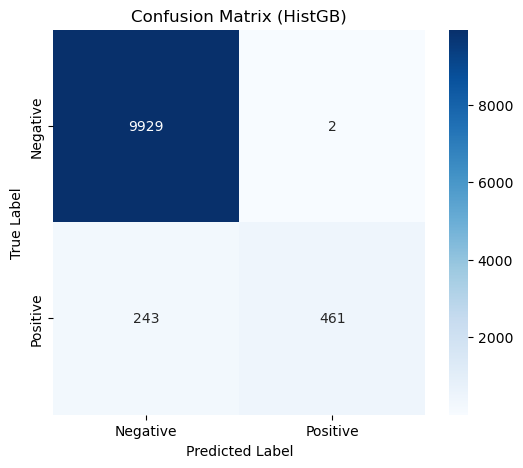

HistGB metrics:
	ROC_AUC: 0.9810053717239864
	Accuracy: 0.9769628584861307
	Precision: 0.9956803455723542
	Recall: 0.6548295454545454
	F1-Score: 0.7900599828620394


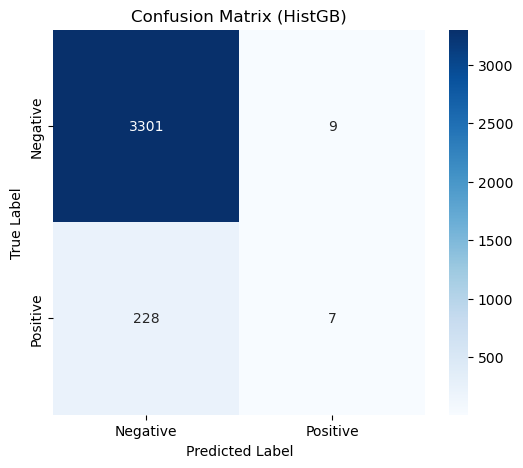

HistGB metrics:
	ROC_AUC: 0.7924959825159092
	Accuracy: 0.9331452750352609
	Precision: 0.4375
	Recall: 0.029787234042553193
	F1-Score: 0.055776892430278883
Training Time: 189.0939 seconds


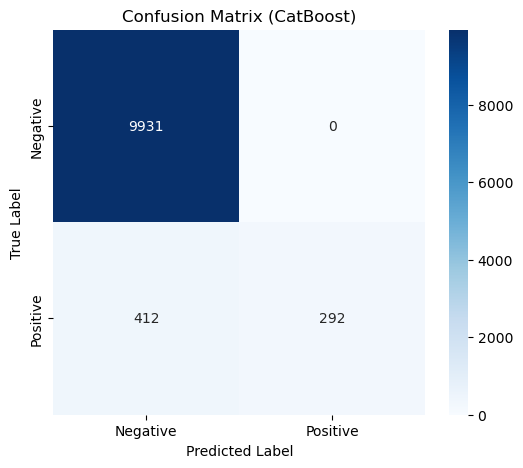

CatBoost metrics:
	ROC_AUC: 0.9929743211111213
	Accuracy: 0.9612599905970851
	Precision: 1.0
	Recall: 0.4147727272727273
	F1-Score: 0.5863453815261044


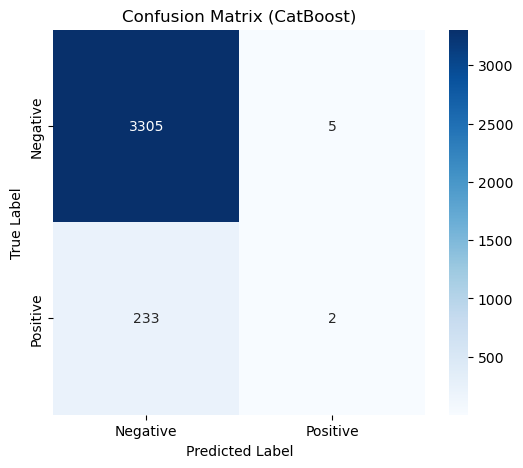

CatBoost metrics:
	ROC_AUC: 0.8049906794369095
	Accuracy: 0.9328631875881523
	Precision: 0.2857142857142857
	Recall: 0.00851063829787234
	F1-Score: 0.01652892561983471
[LightGBM] [Info] Number of positive: 704, number of negative: 9931
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.329980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 393714
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 1928
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.066197 -> initscore=-2.646638
[LightGBM] [Info] Start training from score -2.646638
Training Time: 16.9684 seconds


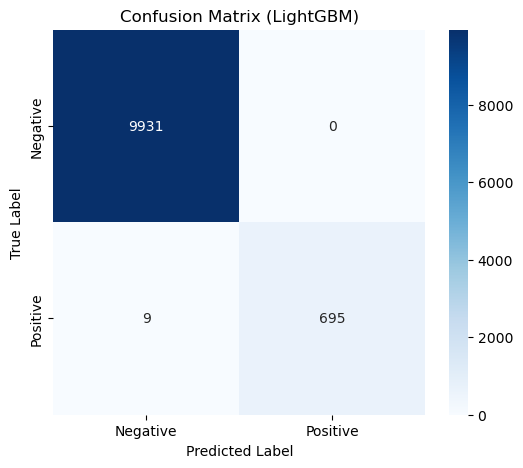

LightGBM metrics:
	ROC_AUC: 0.9999980690628976
	Accuracy: 0.9991537376586742
	Precision: 1.0
	Recall: 0.9872159090909091
	F1-Score: 0.993566833452466


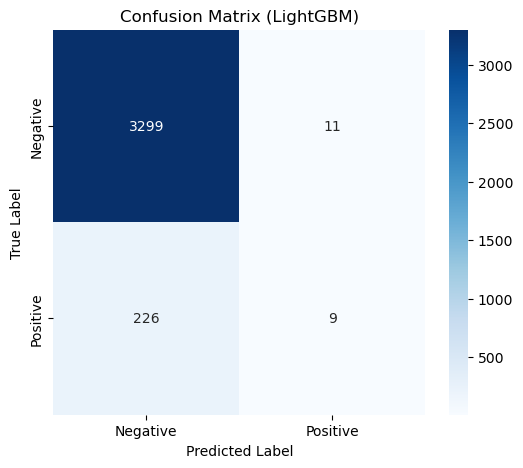

LightGBM metrics:
	ROC_AUC: 0.7895583981487434
	Accuracy: 0.9331452750352609
	Precision: 0.45
	Recall: 0.03829787234042553
	F1-Score: 0.07058823529411765


/home/drmathew/.local/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [02:40:40] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training Time: 37.6062 seconds


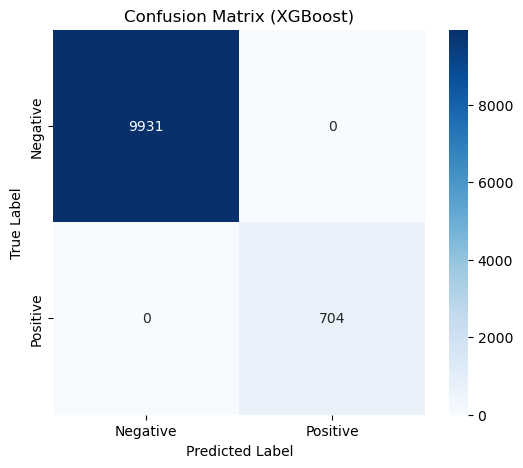

XGBoost metrics:
	ROC_AUC: 1.0
	Accuracy: 1.0
	Precision: 1.0
	Recall: 1.0
	F1-Score: 1.0


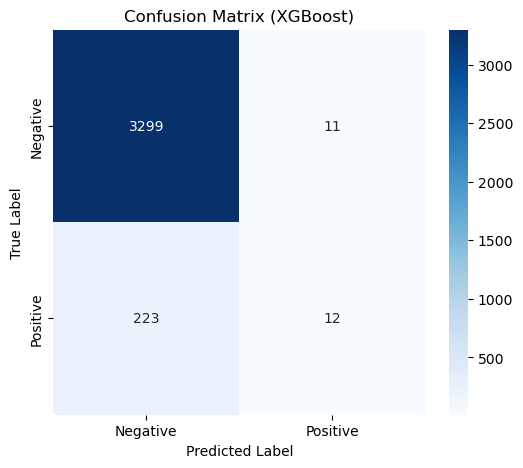

XGBoost metrics:
	ROC_AUC: 0.7797274538792827
	Accuracy: 0.9339915373765867
	Precision: 0.5217391304347826
	Recall: 0.05106382978723404
	F1-Score: 0.09302325581395349
Training Time: 7.3899 seconds


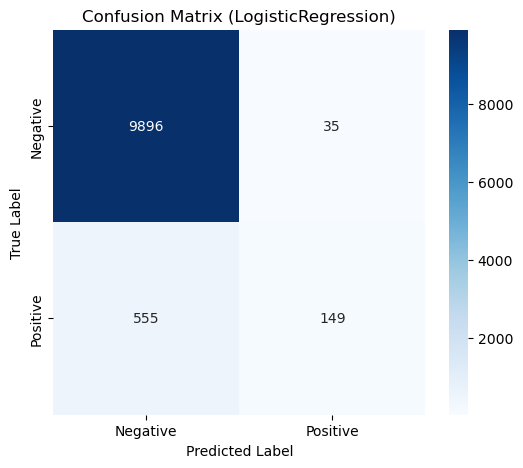

LogisticRegression metrics:
	ROC_AUC: 0.9129985536565941
	Accuracy: 0.9445228020686413
	Precision: 0.8097826086956522
	Recall: 0.21164772727272727
	F1-Score: 0.3355855855855856


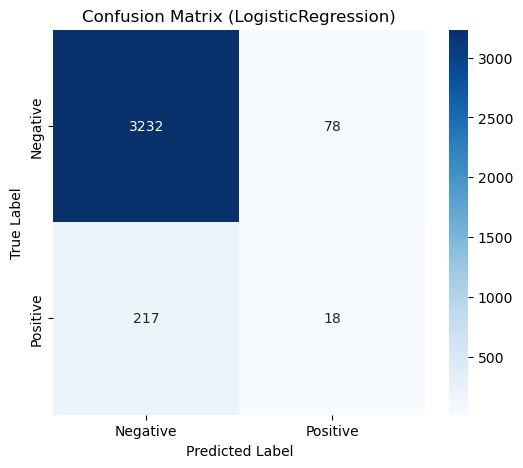

LogisticRegression metrics:
	ROC_AUC: 0.7226740374108118
	Accuracy: 0.9167842031029619
	Precision: 0.1875
	Recall: 0.07659574468085106
	F1-Score: 0.10876132930513595


In [63]:
# testing models with scoring exclusions
model_types = ["HistGB", "CatBoost", "LightGBM", "XGBoost", "LogisticRegression"]
model_metrics = {}
for model_type in model_types:
    model, metrics = train_and_evaluate(
        X_train_standardized_score_exc, y_train_score_exc, X_test_standardized_score_exc, y_test_score_exc, model_type=model_type
    )
    model_metrics[model_type] = [model, metrics]

## Week 9

#### Shapley Values

In [34]:
import shap
shap.initjs()

In [82]:
def get_top_reasons(explainer, X, shap_values, i, n=3):
    shap_instance = shap_values[i].values
    features = X.columns
    
    top = np.argsort(np.abs(shap_instance))[-n:]
    filtered_shap = shap_instance[top]
    filtered_features = features[top]
    feature_labels = [
        f"{feature}_HIGH" if shap_value > 0 else f"{feature}_LOW"
        for feature, shap_value in zip(filtered_features, filtered_shap)
    ]

    return feature_labels #, shap.force_plot(explainer.expected_value, filtered_shap, X.iloc[i, top])

In [83]:
def get_reason_codes(explainer, X, shap_values):
    reason_codes_by_consumer = []
    for i in range(len(X)):
        top_3_features = get_top_reasons(explainer, X, shap_values, i)
        reason_codes_by_consumer.append(list(top_3_features))
    reason_codes_by_consumer = np.array(reason_codes_by_consumer)
    return reason_codes_by_consumer

In [102]:
def plot_reason_codes_distribution(reason_codes_by_consumer):
    reason_codes = reason_codes_by_consumer.ravel()
    unique_reason_codes, reason_codes_counts = np.unique(reason_codes, return_counts=True)
    unique_reason_codes = unique_reason_codes[np.argsort(-reason_codes_counts)][:25]
    reason_codes_counts = reason_codes_counts[np.argsort(-reason_codes_counts)][:25]
    reason_codes_props = reason_codes_counts[np.argsort(-reason_codes_counts)][:25] / reason_codes_counts.sum()
    
    plt.figure(figsize=(10,5))
    plt.bar(unique_reason_codes, reason_codes_props, color='skyblue', edgecolor='black')
    plt.xticks(rotation=45, ha="right")
    
    for i, (prop, count) in enumerate(zip(reason_codes_props, reason_codes_counts)):
        plt.text(i, prop + 0.001, str(count), ha="center", fontsize=10)
    
    plt.title("Distribution of Reason Codes")
    plt.xlabel("Reason Code")
    plt.ylabel("Proportion")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('../../q2_result/reason_codes_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

In [85]:
final_X_train, final_X_train_cs, final_y_train = (
    features_df_DQ_no_na.drop(columns=['prism_consumer_id', 'DQ_TARGET', 'evaluation_date', 'credit_score']),
    features_df_DQ_no_na.drop(columns=['prism_consumer_id', 'DQ_TARGET', 'evaluation_date',]),
    features_df_DQ_no_na['DQ_TARGET']
)

In [86]:
X_holdout = features_df[features_df.DQ_TARGET.isna()].drop(columns=['prism_consumer_id', 'DQ_TARGET', 'evaluation_date', 'credit_score'])
X_holdout_cs = features_df[features_df.DQ_TARGET.isna()].drop(columns=['prism_consumer_id', 'DQ_TARGET', 'evaluation_date',])

In [87]:
final_X_train_std, X_holdout_std = standardize(final_X_train, X_holdout)
final_X_train_cs_std, X_holdout_cs_std = standardize(final_X_train_cs, X_holdout_cs)

In [88]:
final_X_train_resampled, final_y_train_resampled = resample_data(final_X_train_std, final_y_train)
final_X_train_cs_resampled, final_y_train_cs_resampled = resample_data(final_X_train_cs_std, final_y_train)

In [89]:
hp_model = CatBoostClassifier(verbose=0)
hp_model.fit(final_X_train_resampled, final_y_train_resampled)

In [90]:
hp_model_cs = CatBoostClassifier(verbose=0)
hp_model_cs.fit(final_X_train_cs_resampled, final_y_train_cs_resampled)

In [91]:
holdout_preds = hp_model.predict(X_holdout_std)
holdout_probs = hp_model.predict_proba(X_holdout_std)

In [92]:
holdout_preds_cs = hp_model_cs.predict(X_holdout_cs_std)
holdout_probs_cs = hp_model_cs.predict_proba(X_holdout_cs_std)

In [93]:
explainer = shap.Explainer(hp_model, final_X_train_resampled)
shap_values_holdout = explainer(X_holdout_std, check_additivity=False)

100%|===================| 2991/3000 [01:54<00:00]        

In [71]:
explainer_cs = shap.Explainer(hp_model_cs, final_X_train_cs_resampled)
shap_values_cs_holdout = explainer(X_holdout_cs_std, check_additivity=False)

100%|===================| 2986/3000 [02:01<00:00]        

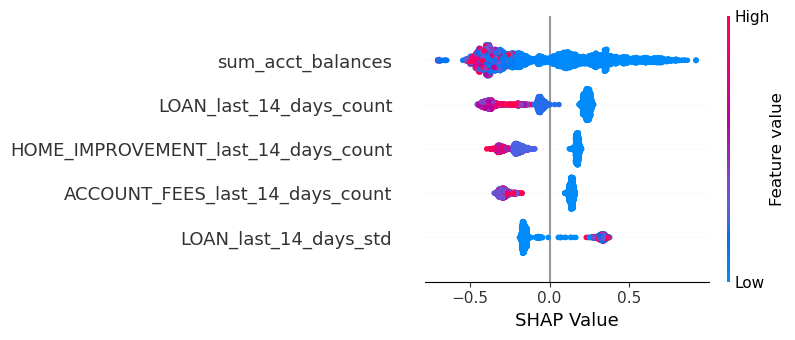

In [70]:
shap.summary_plot(shap_values_holdout, X_holdout_std, max_display=5, show=False)
plt.xlabel("SHAP Value")
plt.show()

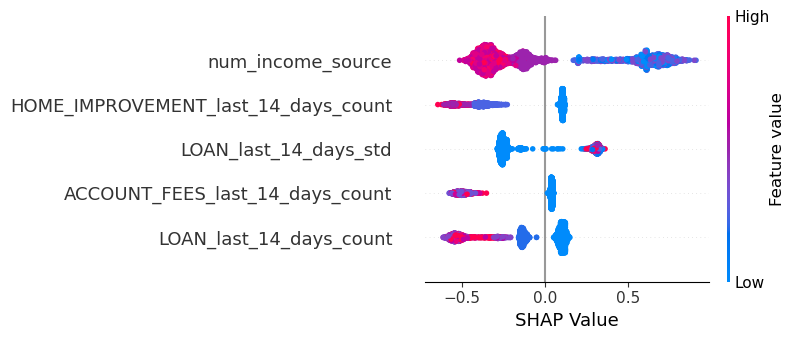

In [72]:
shap.summary_plot(shap_values_cs_holdout, X_holdout_cs_std, max_display=5, show=False)
plt.xlabel("SHAP Value")
plt.show()

In [136]:
holdout_ids = features_df[features_df.DQ_TARGET.isna()].prism_consumer_id
holdout_scores_df = pd.DataFrame({
    'prism_consumer_id': holdout_ids.values, 
    'prob_with_credit_score': holdout_probs_cs[:, 1],
    'reason_code_with_credit_score_1': reason_codes_cs_holdout[:, 0],
    'reason_code_with_credit_score_2': reason_codes_cs_holdout[:, 1],
    'reason_code_with_credit_score_3': reason_codes_cs_holdout[:, 2],
    'prob_without_credit_score': holdout_probs[:, 1],
    'reason_code_without_credit_score_1': reason_codes_holdout[:, 0],
    'reason_code_without_credit_score_2': reason_codes_holdout[:, 1],
    'reason_code_without_credit_score_3': reason_codes_holdout[:, 2]
})
holdout_scores_df

prism_consumer_id  prob_with_credit_score  \
0                  4000                0.002905   
1                  4001                0.027607   
2                  4002                0.003494   
3                  4003                0.026808   
4                  4004                0.003219   
...                 ...                     ...   
2995              14995                0.048757   
2996              14996                0.032265   
2997              14997                0.083984   
2998              14998                0.036829   
2999              14999                0.015923   

                reason_code_with_credit_score_1  \
0                    LOAN_last_14_days_std_HIGH   
1     ESSENTIAL_SERVICES_last_14_days_count_LOW   
2              INSURANCE_last_30_days_count_LOW   
3          ACCOUNT_FEES_last_6_months_count_LOW   
4     ESSENTIAL_SERVICES_last_14_days_count_LOW   
...                                         ...   
2995  ESSENTIAL_SERVICES_last_14_days_count_LOW   
2996                      num_income_source_LOW   
2997       ACCOUNT_FEES_last_6_months_count_LOW   
2998    HOME_IMPROVEMENT_last_14_days_count_LOW   
2999       ACCOUNT_FEES_last_6_months_count_LOW   

              reason_code_with_credit_score_2  \
0                 LOAN_last_14_days_count_LOW   
1     HOME_IMPROVEMENT_last_14_days_count_LOW   
2                       num_income_source_LOW   
3     HOME_IMPROVEMENT_last_14_days_count_LOW   
4     HOME_IMPROVEMENT_last_14_days_count_LOW   
...                                       ...   
2995                    num_income_source_LOW   
2996      ACCOUNT_FEES_last_14_days_count_LOW   
2997               LOAN_last_14_days_std_HIGH   
2998                             GAMBLING_LOW   
2999                LOAN_last_14_days_std_LOW   

                reason_code_with_credit_score_3  prob_without_credit_score  \
0                        num_income_source_HIGH                   0.004302   
1                        num_income_source_HIGH                   0.025481   
2       HOME_IMPROVEMENT_last_14_days_count_LOW                   0.001952   
3     ESSENTIAL_SERVICES_last_14_days_count_LOW                   0.019821   
4                         num_income_source_LOW                   0.005996   
...                                         ...                        ...   
2995    HOME_IMPROVEMENT_last_14_days_count_LOW                   0.061924   
2996    HOME_IMPROVEMENT_last_14_days_count_LOW                   0.027563   
2997                LOAN_last_14_days_count_LOW                   0.060530   
2998                                   BNPL_LOW                   0.060039   
2999                      num_income_source_LOW                   0.020397   

               reason_code_without_credit_score_1  \
0                      LOAN_last_14_days_std_HIGH   
1         HOME_IMPROVEMENT_last_14_days_count_LOW   
2                            HAS_SAVINGS_ACCT_LOW   
3                            HAS_SAVINGS_ACCT_LOW   
4                            HAS_SAVINGS_ACCT_LOW   
...                                           ...   
2995                             num_accounts_LOW   
2996          ACCOUNT_FEES_last_14_days_count_LOW   
2997  CREDIT_CARD_PAYMENT_last_3_months_count_LOW   
2998                  LOAN_last_14_days_count_LOW   
2999     HOME_IMPROVEMENT_last_14_days_count_HIGH   

           reason_code_without_credit_score_2  \
0                       sum_acct_balances_LOW   
1                        HAS_SAVINGS_ACCT_LOW   
2     HOME_IMPROVEMENT_last_14_days_count_LOW   
3                LOAN_last_14_days_count_HIGH   
4                LOAN_last_14_days_count_HIGH   
...                                       ...   
2995                          balance_min_LOW   
2996  HOME_IMPROVEMENT_last_14_days_count_LOW   
2997               LOAN_last_14_days_std_HIGH   
2998               LOAN_last_14_days_std_HIGH   
2999                LOAN_last_14_days_std_LOW   

     reason_code_without_cre

In [137]:
holdout_scores_df.to_csv('holdout_scores.csv', index=False)

In [8]:
holdout_scores_df = pd.read_csv('holdout_scores.csv')

In [5]:
# with open('keep_consumers_df.pkl', 'wb') as f:
#     pickle.dump(keep_consumers_df, f)

In [6]:
with open('keep_consumers_df.pkl', 'rb') as f:
    keep_consumers_df = pickle.load(f)

In [21]:
exclude_consumers = keep_consumers_df[~(keep_consumers_df['has_at_least_2_trxns'] & keep_consumers_df['has_both_credits_debits'])].prism_consumer_id

In [9]:
holdout_scores_df_copy = holdout_scores_df.copy()

In [36]:
exclude_consumers_df = keep_consumers_df[~(keep_consumers_df['has_at_least_2_trxns'] & keep_consumers_df['has_both_credits_debits'])]

In [49]:
exclude_consumers_df['EXCLUDED_has_at_least_2_trxns'] = 'EXCLUDED_has_at_least_2_trxns_' + exclude_consumers_df['has_at_least_2_trxns'].astype(str)
exclude_consumers_df['EXCLUDED_has_both_credits_debits'] = 'EXCLUDED_has_both_credits_debits_' + exclude_consumers_df['has_both_credits_debits'].astype(str)

/tmp/ipykernel_494/85624007.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exclude_consumers_df['EXCLUDED_has_at_least_2_trxns'] = 'EXCLUDED_has_at_least_2_trxns_' + exclude_consumers_df['has_at_least_2_trxns'].astype(str)
/tmp/ipykernel_494/85624007.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exclude_consumers_df['EXCLUDED_has_both_credits_debits'] = 'EXCLUDED_has_both_credits_debits_' + exclude_consumers_df['has_both_credits_debits'].astype(str)


In [66]:
test_df = holdout_scores_df.merge(exclude_consumers_df, on='prism_consumer_id', how='left')
test_df.loc[test_df.prism_consumer_id.isin(exclude_consumers), 'reason_code_with_credit_score_1'] = test_df.loc[test_df.prism_consumer_id.isin(exclude_consumers), 'EXCLUDED_has_at_least_2_trxns'] 
test_df.loc[test_df.prism_consumer_id.isin(exclude_consumers), 'reason_code_with_credit_score_2'] = test_df.loc[test_df.prism_consumer_id.isin(exclude_consumers), 'EXCLUDED_has_both_credits_debits'] 
test_df.loc[test_df.prism_consumer_id.isin(exclude_consumers), 'reason_code_with_credit_score_3'] = np.NaN
test_df.loc[test_df.prism_consumer_id.isin(exclude_consumers), 'reason_code_without_credit_score_1'] = test_df.loc[test_df.prism_consumer_id.isin(exclude_consumers), 'EXCLUDED_has_at_least_2_trxns'] 
test_df.loc[test_df.prism_consumer_id.isin(exclude_consumers), 'reason_code_without_credit_score_2'] = test_df.loc[test_df.prism_consumer_id.isin(exclude_consumers), 'EXCLUDED_has_both_credits_debits'] 
test_df.loc[test_df.prism_consumer_id.isin(exclude_consumers), 'reason_code_without_credit_score_3'] = np.NaN

In [71]:
df = test_df.drop(columns=['has_at_least_2_trxns', 'has_both_credits_debits', 'EXCLUDED_has_at_least_2_trxns', 'EXCLUDED_has_both_credits_debits'])
df.to_csv('holdout_scores.csv', index=False)

In [41]:
holdout_scores_df.loc[holdout_scores_df.prism_consumer_id.isin(exclude_consumers), 'new_test'] = exclude_consumers_df['has_at_least_2_trxns']

In [24]:
exclude_consumers = keep_consumers_df[~(keep_consumers_df['has_at_least_2_trxns'] & keep_consumers_df['has_both_credits_debits'])].prism_consumer_id
holdout_scores_df.loc[holdout_scores_df.prism_consumer_id.isin(exclude_consumers), 'prob_with_credit_score'] = np.nan
holdout_scores_df.loc[holdout_scores_df.prism_consumer_id.isin(exclude_consumers), 'reason_code_with_credit_score_1'] = 
holdout_scores_df.loc[holdout_scores_df.prism_consumer_id.isin(exclude_consumers), 'prob_with_credit_score'] = np.nan

In [94]:
reason_codes_holdout = get_reason_codes(explainer, X_holdout_std, shap_values_holdout)

In [83]:
reason_codes_cs_holdout = get_reason_codes(explainer, X_holdout_cs_std, shap_values_cs_holdout)

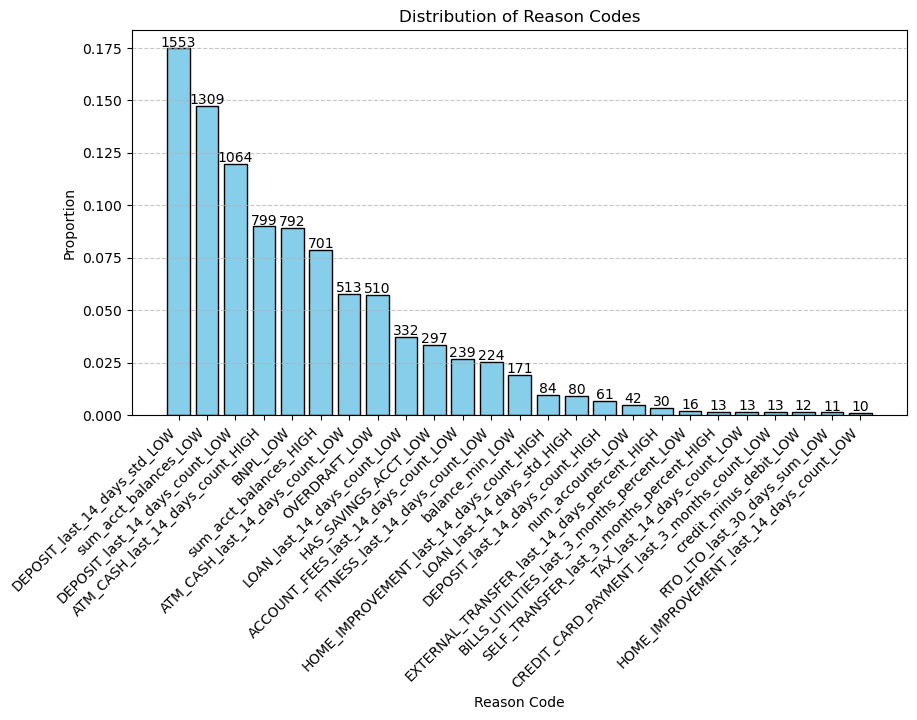

In [103]:
plot_reason_codes_distribution(reason_codes_holdout)

In [73]:
# shap.force_plot(explainer.expected_value, shap_values[0].values, X_val_standardized.iloc[0])

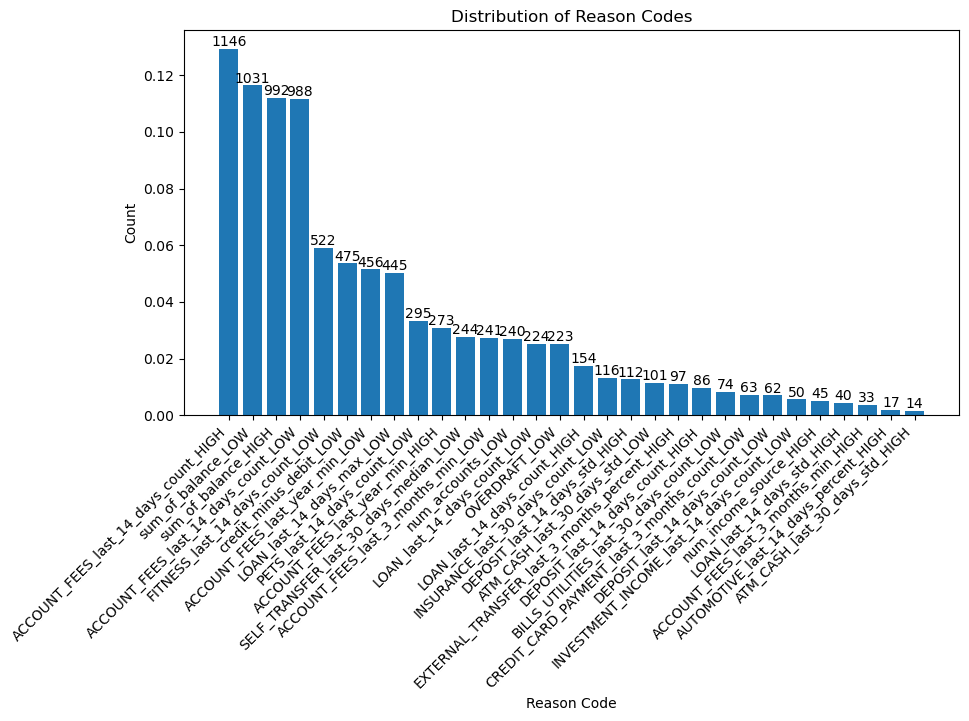

In [241]:
reason_codes_by_consumer_holdout = get_reason_codes(explainer, X_holdout_standardized, shap_values)
plot_reason_codes_distribution(reason_codes_by_consumer_holdout)

## Week 10

#### Binned Bad Rates Plots

In [38]:
# created new split function to drop different columns for the sake of comparing with credit score
def split_data(final_features_df, test_size=0.25):
    # do not drop prism consumer id and credit score, need to have them for comparison
    X_train, X_test, y_train, y_test = train_test_split(
        final_features_df.drop(columns=['DQ_TARGET', 'evaluation_date']), 
        final_features_df['DQ_TARGET'], test_size=test_size, stratify=final_features_df['DQ_TARGET']
    )
    return X_train, X_test, y_train, y_test

In [76]:
NUM_FEATURES = 500
X_train_with_id, X_test_with_id, y_train, y_test = split_data(features_df_DQ_no_na, test_size=0.5)

In [77]:
# splitting data with prism consumer id and credit score
X_train_id_cs, X_test_id_cs = X_train_with_id[['prism_consumer_id', 'credit_score']], X_test_with_id[['prism_consumer_id', 'credit_score']]
X_train_final, X_test_final = (X_train_with_id.drop(columns=['prism_consumer_id', 'credit_score']), 
                               X_test_with_id.drop(columns=['prism_consumer_id', 'credit_score']))
# standardizing and feature selecting
X_train_final_std, X_test_final_std = standardize(X_train_final, X_test_final)
feature_coefs = get_lasso_features(X_train_final_std, y_train)
selected_features = select_top_features(feature_coefs, NUM_FEATURES, limit=np.inf) # change limit parameter to np.inf to keep redundant features
X_train_final_top_features, X_test_final_top_features = \
    get_feature_selection_datasets(X_train_final_std, selected_features), \
    get_feature_selection_datasets(X_train_final_std, selected_features), 
# SMOTE
# note that this shuffles the dataset too so I'll be making plots on test dataset
X_train_final_resampled, y_train_resampled = resample_data(X_train_final_top_features, y_train, new_0=0.75, new_1=0.25)

Training Time: 18.9415 seconds


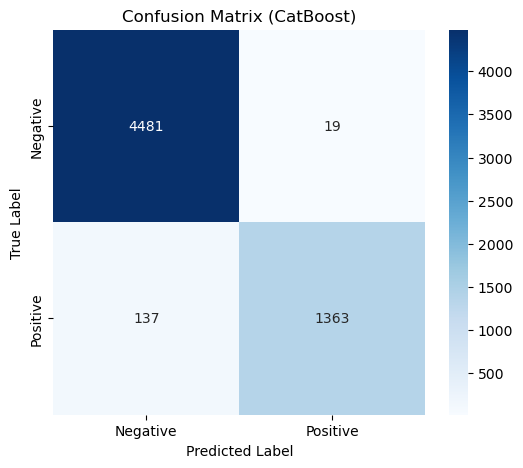

CatBoost metrics:
	ROC_AUC: 0.9981232592592593
	Accuracy: 0.974
	Precision: 0.9862518089725036
	Recall: 0.9086666666666666
	F1-Score: 0.9458709229701596


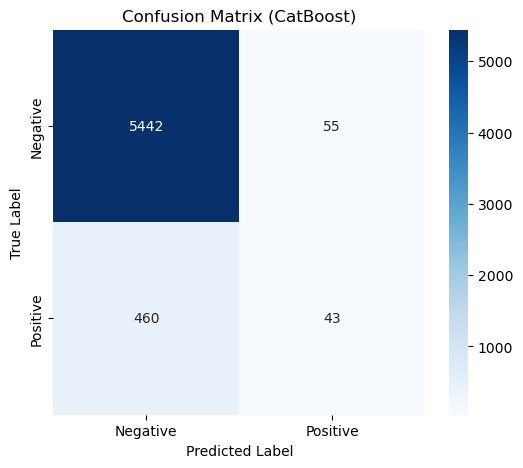

CatBoost metrics:
	ROC_AUC: 0.7726797302414365
	Accuracy: 0.9141666666666667
	Precision: 0.4387755102040816
	Recall: 0.08548707753479125
	F1-Score: 0.14309484193011648


In [78]:
# FINAL MODEL -- TODO: replace with actual hyperparameters
catboost_final, catboost_final_metrics = train_and_evaluate(
    X_train_final_resampled, y_train_resampled, X_test_final_std, y_test, model_type='CatBoost'
)

In [79]:
explainer = shap.Explainer(catboost_final, X_train_final_resampled)
# shap_values_test = explainer(X_test_final_std, check_additivity=False)

In [80]:
X_subset = X_train_final_std.sample(frac=0.5)

In [71]:
shap_values_subset = explainer(X_subset, check_additivity=False)

100%|===================| 2991/3000 [02:16<00:00]        

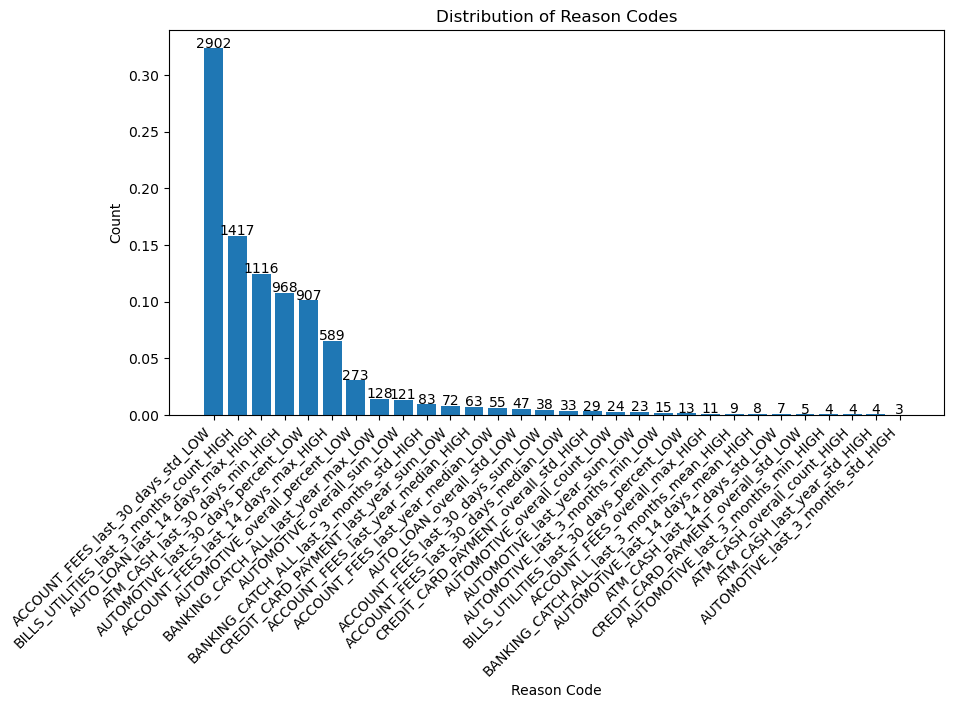

In [81]:
reason_codes_subset = get_reason_codes(explainer, X_subset, shap_values_subset)
plot_reason_codes_distribution(reason_codes_subset)

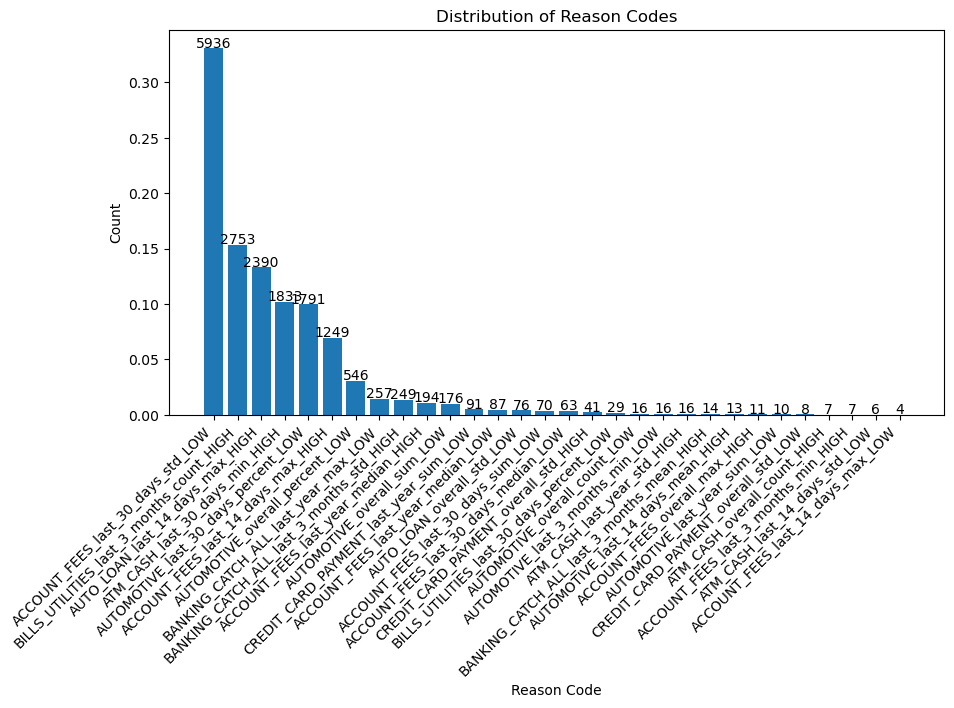

In [72]:
reason_codes_subset = get_reason_codes(explainer, X_subset, shap_values_subset)
plot_reason_codes_distribution(reason_codes_subset)

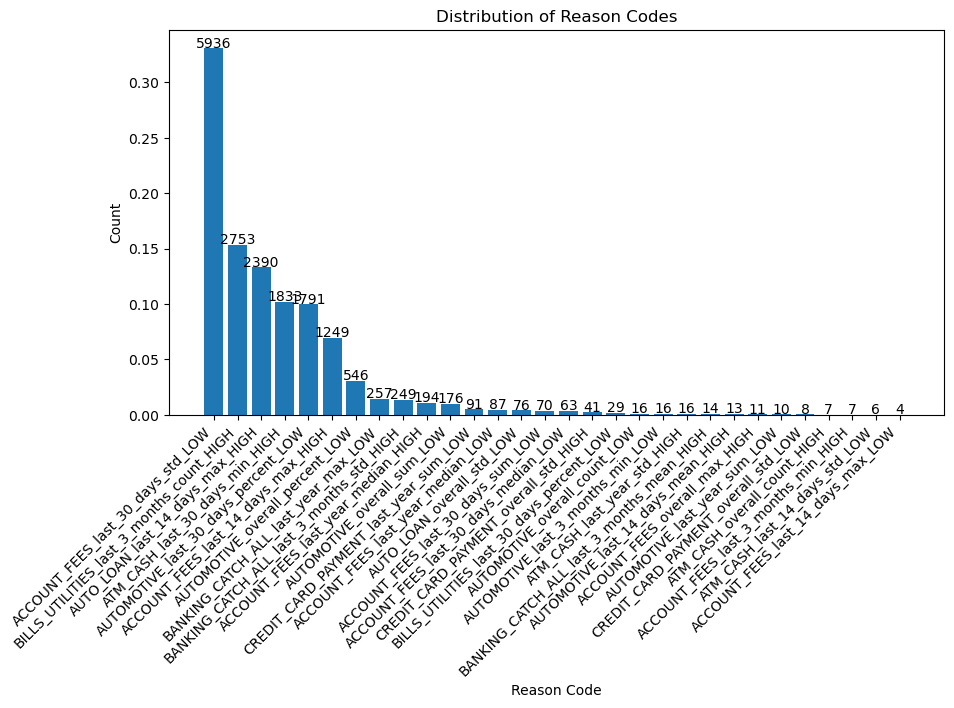

In [68]:
reason_codes_test = get_reason_codes(explainer, X_test_final_std, shap_values_test)
plot_reason_codes_distribution(reason_codes_test)

In [42]:
# adding credit score to model
X_train_cs_final, X_test_cs_final = (X_train_with_id.drop(columns=['prism_consumer_id',]), 
                                     X_test_with_id.drop(columns=['prism_consumer_id',]))
# standardizing and feature selecting
X_train_cs_final_std, X_test_cs_final_std = standardize(X_train_cs_final, X_test_cs_final)
feature_coefs_cs = get_lasso_features(X_train_cs_final_std, y_train)
selected_features_cs = select_top_features(feature_coefs_cs, NUM_FEATURES, limit=np.inf) # change limit parameter to np.inf to keep redundant features
X_train_cs_final_top_features, X_test_cs_final_top_features = \
    get_feature_selection_datasets(X_train_cs_final_std, selected_features_cs), \
    get_feature_selection_datasets(X_test_cs_final_std, selected_features_cs), 
# SMOTE
# note that this shuffles the dataset too so I'll be making plots on test dataset
X_train_cs_final_resampled, y_train_resampled = resample_data(X_train_cs_final_top_features, y_train, new_0=0.75, new_1=0.25)

Training Time: 19.2670 seconds


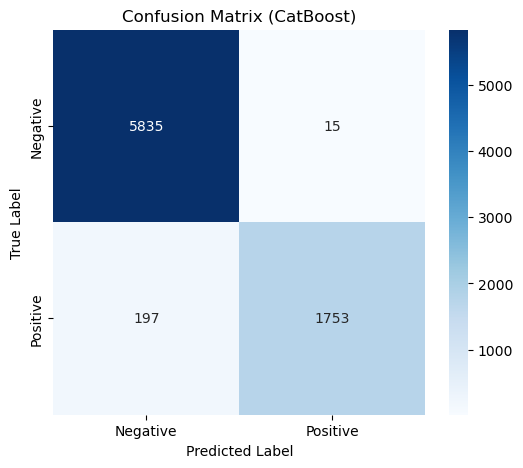

CatBoost metrics:
	ROC_AUC: 0.9977652859960552
	Accuracy: 0.9728205128205129
	Precision: 0.9915158371040724
	Recall: 0.898974358974359
	F1-Score: 0.9429800968262507


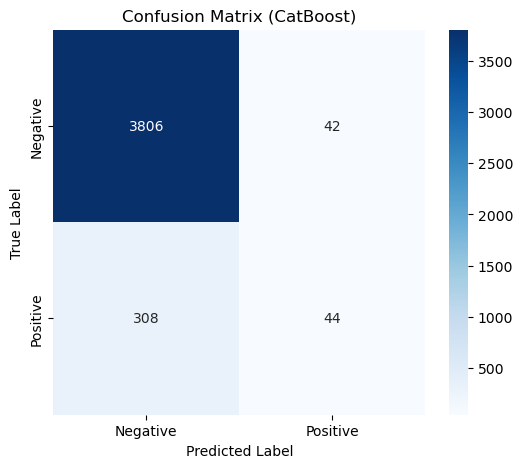

CatBoost metrics:
	ROC_AUC: 0.8048477071914572
	Accuracy: 0.9166666666666666
	Precision: 0.5116279069767442
	Recall: 0.125
	F1-Score: 0.2009132420091324


In [65]:
# model performance with credit score
catboost_cs_final, catboost_cs_final_metrics = train_and_evaluate(
    X_train_cs_final_resampled, y_train_resampled, X_test_cs_final_std, y_test, model_type='CatBoost'
)

In [45]:
def create_binned_scores_df(model, X, X_id_cs, y):
    # credit score
    test_probs = model.predict_proba(X)[:, 1]
    test_cash_scores = (999 - (998 * test_probs)).astype(int)
    test_credit_scores = X_id_cs['credit_score']
    df = pd.DataFrame({'cash_scores': test_cash_scores, 'credit_scores': test_credit_scores, 'target': y})
    cash_score_bins = pd.cut(df['cash_scores'], bins=5).cat.categories  
    credit_scores_bins = pd.cut(df['credit_scores'], bins=5).cat.categories
    df['cash_score_bins'] = pd.cut(df['cash_scores'], bins=5, labels=cash_score_bins)  
    df['credit_score_bins'] = pd.cut(df['credit_scores'], bins=5, labels=credit_scores_bins) 
    return df

In [54]:
df = create_binned_scores_df(catboost_final, X_test_final_std, X_test_id_cs, y_test)

In [47]:
# this is so sad -- dropping a outlier consumer
# df_ = df.drop(index=7183)
df_ = df

In [ ]:
df_cs = create_binned_scores_df(catboost_cs_final, X_test_cs_final_std, X_test_id_cs, y_test)

**Bar Chart of Delinquency Rates for Cash Scores vs Credit Scores**

/tmp/ipykernel_562/3798347462.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = df_.groupby('temp_cash_score_bins')['target'].mean()  # Convert to percentage


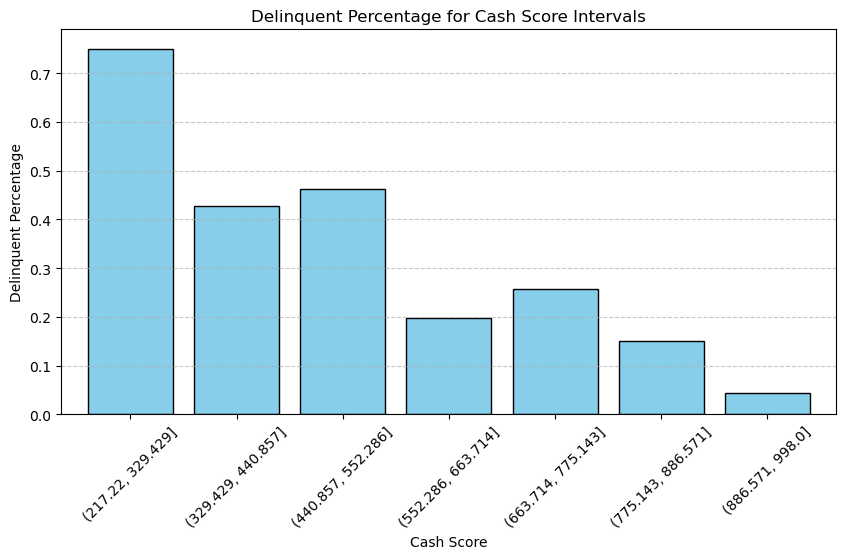

In [61]:
df_['temp_cash_score_bins'] = pd.cut(df['cash_scores'], bins=7)
bin_summary = df_.groupby('temp_cash_score_bins')['target'].mean()  # Convert to percentage

# Plot the bar chart
plt.figure(figsize=(10, 5))
bin_summary.plot(kind='bar', color='skyblue', edgecolor='black', width=0.8)
plt.xlabel('Cash Score')
plt.ylabel('Delinquent Percentage')
plt.ylim(0.0, 0.79)
plt.title('Delinquent Percentage for Cash Score Intervals')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('../../q2_result/delinquent_percentage_by_cash_score.png', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_562/987321427.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = df_.groupby('temp_credit_score_bins')['target'].mean() # Convert to percentage


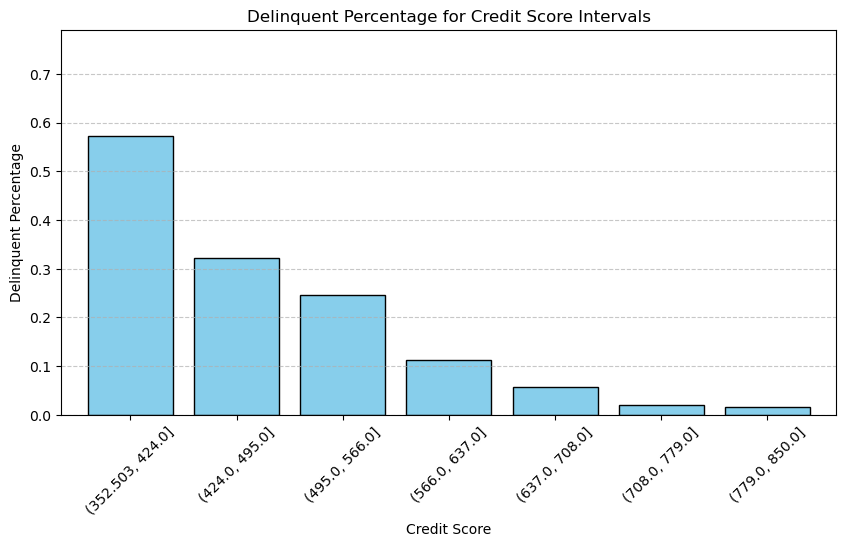

In [62]:
df_['temp_credit_score_bins'] = pd.cut(df_['credit_scores'], bins=7)
bin_summary = df_.groupby('temp_credit_score_bins')['target'].mean() # Convert to percentage

# Plot the bar chart
plt.figure(figsize=(10, 5))
bin_summary.plot(kind='bar', color='skyblue', edgecolor='black', width=0.8)
plt.xlabel('Credit Score')
plt.ylabel('Delinquent Percentage')
plt.ylim(0.0, 0.79)

plt.title('Delinquent Percentage for Credit Score Intervals')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('../../q2_result/delinquent_percentage_by_credit_score.png', dpi=300, bbox_inches='tight')
plt.show()

**Heatmap of Delinquency Rates for Cash vs Credit Score**

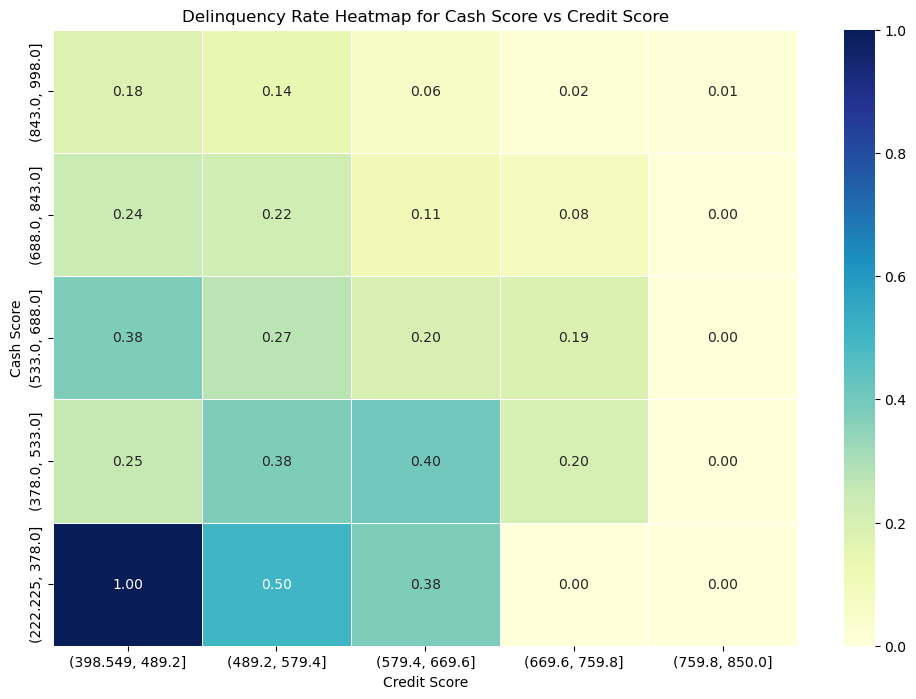

In [54]:
# Compute delinquency rate (percentage of 1's) for each combination of bins
# heatmap_data = df_.groupby(['cash_score_bins', 'credit_score_bins'])['target'].mean().unstack(fill_value=0).fillna(0)  # Percent delinquency
# heatmap_data = heatmap_data.reindex(index=bin1_labels, columns=bin2_labels, fill_value=0.0)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt='.2f', linewidths=0.5)
plt.gca().invert_yaxis()
plt.title('Delinquency Rate Heatmap for Cash Score vs Credit Score')
plt.xlabel('Credit Score')
plt.ylabel('Cash Score')
plt.savefig('../../q2_result/delinquency_rate_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

In [135]:
# with open('heatmap_data.pkl', 'wb') as f:
#     pickle.dump(heatmap_data, f)

In [6]:
with open('heatmap_data.pkl', 'rb') as f:
    heatmap_data = pickle.load(f)

#### Threshold Tuning

In [113]:
# see peformance on optimal test threshold, then try using optimal train threshold

In [128]:
y_train_probs = catboost_smote_500_final.predict_proba(X_train_resampled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_train_resampled, y_train_probs)

In [129]:
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.2784839077512603

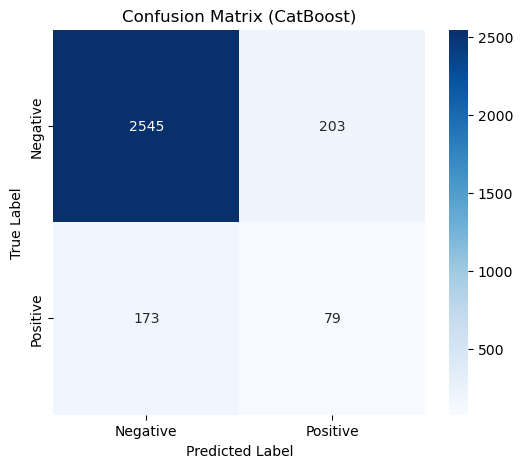

CatBoost metrics:
	ROC_AUC: 0.7628975474226567
	Accuracy: 0.8746666666666667
	Precision: 0.2801418439716312
	Recall: 0.3134920634920635
	F1-Score: 0.2958801498127341


In [130]:
y_test_preds = y_test_probs > optimal_threshold
y = y_test
y_prob = y_test_probs
y_pred = y_test_preds

metrics = {
    "ROC_AUC": roc_auc_score(y, y_prob),
    "Accuracy": accuracy_score(y, y_pred),
    "Precision": precision_score(y, y_pred),
    "Recall": recall_score(y, y_pred),
    "F1-Score": f1_score(y, y_pred),
    # "Confusion Matrix": confusion_matrix(y, y_pred)
}

# Confusion Matrix
cm = confusion_matrix(y, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix ({model_type})")
plt.show()

# Print Metrics
print(f'{model_type} metrics:')
for metric, value in metrics.items():
    print(f"\t{metric}: {value}")
